# transformer project
GD 노드 10

프로세스는 다음과 같다.
1. 데이터 로드 및 전처리
2. 모델링 (transformer)
3. 모델 훈련
4. 모델 평가

## 1. 데이터 로드 및 전처리 

In [1]:
# 한글 설정
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

print("슝=3")

Duplicate key in file PosixPath('/home/aiffel-dj28/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/mpl-data/matplotlibrc'), line 250 ('font.family:  NanumGothic')


슝=3


In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import re
import os
import io
import time
import random

import seaborn # Attention 시각화를 위해 필요!

print(tf.__version__)

2.2.0


### 데이터 전처리
먼저 중복을 제거한다.   
그리고 정제를 한다. 정제는 다음과 같다.    
모든 입력을 소문자로 변경하고 불필요한 알파벳을 모두 제거한다.   
또한 문장부호 양 옆에 공백을 추가하고 문장 앞뒤에 불필요한 공백을 제거한다.    
정제 후 sentencepiece를 이용하여 토크나이징을 한다. 이때 토큰 길이가 50 이하를 사용한다.    

### 중복제거

In [3]:
data_dir = os.getenv('HOME')+'/aiffel/transformer'
kor_path = data_dir+"/korean-english-park.train.ko"
eng_path = data_dir+"/korean-english-park.train.en"

# 데이터 정제 및 토큰화
def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r") as f: kor = f.read().splitlines()
    with open(eng_path, "r") as f: eng = f.read().splitlines()
    assert len(kor) == len(eng)

    sen_idx = {}
    cleaned_en = []
    cleaned_ko = []

    for sen1,sen2 in zip(eng,kor): 
        if sen1 not in sen_idx:
            sen_idx[sen1] = 1
            cleaned_en.append(sen1)
            cleaned_ko.append(sen2)

    return cleaned_ko, cleaned_en

cleaned_corpus_ko, cleaned_corpus_en  = clean_corpus(kor_path, eng_path)

In [4]:
print(cleaned_corpus_ko[237])
print(cleaned_corpus_en[237])

그래서 부시 행정부가 북한 지도자들에게 그들의 국가가 핵무기를 개발하고 있다는 증거를 제시했을 때에도 부시 행정부는 북한 정권이 그에 대해 거짓말을 할 것으로 예상했었다.
So when the Bush Administration presented evidence to North Korean leaders that their country was developing nuclear weapons, it expected the regime to lie about it.


### 데이터 정제 

In [5]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z?.!,]+", " ", sentence)

    sentence = sentence.strip()
    
    return sentence

### 토크나이징

In [6]:
# Sentencepiece를 활용하여 학습한 tokenizer를 생성합니다.
import sentencepiece as spm
def generate_tokenizer(corpus,
                        vocab_size,
                        lang="ko",
                        pad_id=0,
                        bos_id=1,
                        eos_id=2,
                        unk_id=3,
                        m=0):
    
    templates= '--input={} \
    --pad_id={} \
    --bos_id={} \
    --eos_id={} \
    --unk_id={} \
    --model_prefix={} \
    --vocab_size={} \
    --character_coverage={} \
    --model_type={}'

    
    temp_file = os.getenv('HOME')+'/aiffel/transformer/' + lang
    with open(temp_file, 'w') as f:
        for row in corpus:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
            f.write(str(row) + '\n')

    train_input_file = temp_file
    #pad_id=0  #<pad> token을 0으로 설정
    #vocab_size = 20000 # vocab 사이즈
    #bos_id=1 #<start> token을 1으로 설정
    #eos_id=2 #<end> token을 2으로 설정
    #unk_id=3 #<unknown> token을 3으로 설정
    character_coverage = 1.0 # to reduce character set 
    
    m_type = ['unigram','bpe','char','word']
    model_type = m_type[m]# Choose from unigram (default), bpe, char, or word
    
    prefix = lang + '_' + model_type + "_spm" # 저장될 tokenizer 모델에 붙는 이름
    

    cmd = templates.format(train_input_file,
                    pad_id,
                    bos_id,
                    eos_id,
                    unk_id,
                    prefix,
                    vocab_size,
                    character_coverage,
                    model_type)
    
    spm.SentencePieceTrainer.Train(cmd)
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load(lang + '_spm.model')
    
    return tokenizer
    

    
    
SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 20000

eng_corpus = []
kor_corpus = []

for k,e in zip(cleaned_corpus_ko, cleaned_corpus_en):
    kor_corpus.append(preprocess_sentence(k))
    eng_corpus.append(preprocess_sentence(e))

ko_tokenizer = generate_tokenizer(kor_corpus, SRC_VOCAB_SIZE, "ko")
en_tokenizer = generate_tokenizer(eng_corpus, TGT_VOCAB_SIZE, "en")
en_tokenizer.set_encode_extra_options("bos:eos")

True

In [7]:
from tqdm import tqdm_notebook    # Process 과정을 보기 위해

src_corpus = []
tgt_corpus = []

assert len(kor_corpus) == len(eng_corpus)

# 토큰의 길이가 50 이하인 문장만 남깁니다. 
for idx in tqdm_notebook(range(len(kor_corpus))):
    tmp_ko = ko_tokenizer.EncodeAsIds(kor_corpus[idx])
    tmp_en = en_tokenizer.EncodeAsIds(eng_corpus[idx])
    if len(tmp_ko) <= 50 and len(tmp_en) <= 50:
        src_corpus.append(tmp_ko)
        tgt_corpus.append(tmp_en)
    

# 패딩처리를 완료하여 학습용 데이터를 완성합니다. 
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post',maxlen=50)
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post',maxlen=50)

/home/aiffel-dj28/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


  0%|          | 0/75598 [00:00<?, ?it/s]

In [8]:
len(enc_train[0])

50

In [9]:
len(dec_train[0])

50

## 2. 모델링 (transformer)
- positional encoding : 각 단어의 순서를 나타내기 위한 모듈이다.
- multihead : 모델에서 어텐션을 여러 가지로 나타내기 위한 모듈이다.
- feedforward : 어텐션으로 얻은 값을 중간에 계산하기 위한 모듈이다.  
위의 모듈들을 결합하여 encoder와 decoder를 만들고 2개를 결합하여 transformer를 만든다.   
계산을 더 효율적으로 빠르게 하기 위해서 masking 기법도 추가를 한다.   
특별히 학습을 잘 하기 위해서 따로 learning rate와 optimzer를 세팅해준다.

### Positional encoding

In [10]:
# pos : 단어 위치, d_model : 임베딩 차원 수
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

    return sinusoid_table

print("슝=3")

슝=3


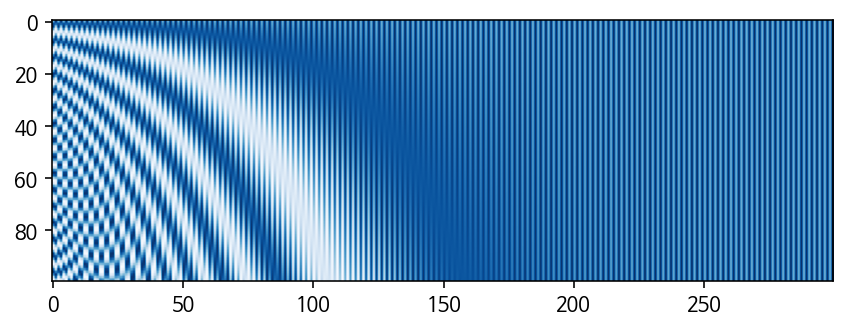

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 7))
plt.imshow(positional_encoding(100, 300), cmap='Blues')
plt.show()

### Multihead

In [12]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        self.depth = d_model // self.num_heads

        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)

        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions


    def split_heads(self, x):
        bsz = x.shape[0]
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))

        return combined_x


    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)

        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)

        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)

        out = self.combine_heads(out)
        out = self.linear(out)

        return out, attention_weights
print('!')

!


### Feedforward

In [13]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

print("슝=3")

슝=3


### Encoder

In [14]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual
        
        return out, enc_attn

print("슝=3")

슝=3


### Decoder

In [15]:
# DecoderLayer 클래스를 작성하세요.
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)

    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, causality_mask)
        out = self.do(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, padding_mask)
        out = self.do(out)
        out += residual

        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, dec_attn, dec_enc_attn

In [16]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
    
        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

print("슝=3")

슝=3


In [17]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

print("슝=3")

슝=3


### Transformer

In [18]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.3,
                    shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.do = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)

        return out


    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)

        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)

        logits = self.fc(dec_out)

        return logits, enc_attns, dec_attns, dec_enc_attns

print("슝=3")

슝=3


### Masking

In [19]:
import numpy as np
import tensorflow as tf

def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

print("슝=3")

슝=3


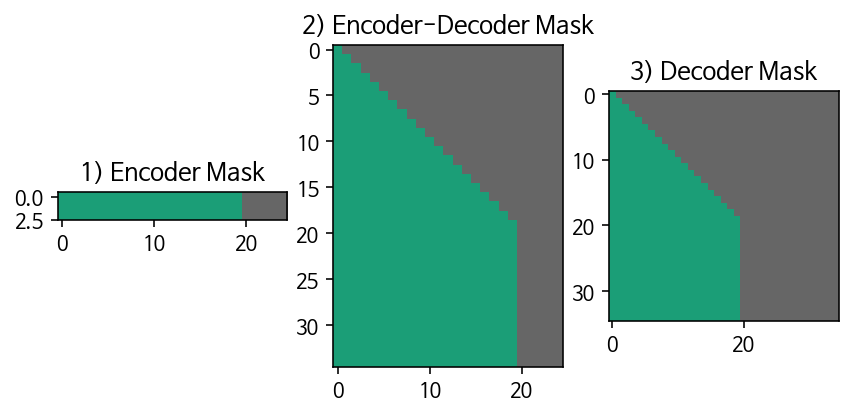

In [20]:
import matplotlib.pyplot as plt

batch, length = 16, 20
src_padding = 5
tgt_padding = 15

src_pad = tf.zeros(shape=(batch, src_padding))
tgt_pad = tf.zeros(shape=(batch, tgt_padding))

sample_data = tf.ones(shape=(batch, length))

sample_src = tf.concat([sample_data, src_pad], axis=-1)
sample_tgt = tf.concat([sample_data, tgt_pad], axis=-1)

enc_mask, dec_enc_mask, dec_mask = \
generate_masks(sample_src, sample_tgt)

fig = plt.figure(figsize=(7, 7))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.set_title('1) Encoder Mask')
ax2.set_title('2) Encoder-Decoder Mask')
ax3.set_title('3) Decoder Mask')

ax1.imshow(enc_mask[:3, 0, 0].numpy(), cmap='Dark2')
ax2.imshow(dec_enc_mask[0, 0].numpy(), cmap='Dark2')
ax3.imshow(dec_mask[0, 0].numpy(), cmap='Dark2')

plt.show()

### Learning rate and optimzer

In [21]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)

print("슝=3")

슝=3


## 3. 모델 훈련
하이퍼 파라미터는 다음과 같다.   
노드에서 encoder와 decoder의 수를 2로 고정하라 해서 고정한다.   
dim_m = 128   
dim_ff = 256      
heads = 8   
p_len = 50   

In [22]:
tf.keras.backend.clear_session()

dim_m = 128
dim_ff = 256
heads = 8
p_len = 50


transformer_model = Transformer(n_layers = 2,
                               d_model = dim_m,
                               d_ff = dim_ff,
                               n_heads = heads,
                               pos_len = p_len,
                               src_vocab_size = 20000,
                               tgt_vocab_size = 20000)

### Loss function

In [23]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

### Train and evaluation
각 epoch에 해당하는 결과를 보기 위해서 사용자 정의 함수로 학습을 시키고 결과를 확인한다.

In [24]:
# Train Step 함수 정의

@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)
    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
    variables = model.trainable_variables
    gradients = tape.gradient(loss,variables)
    optimizer.apply_gradients(zip(gradients,variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns

In [25]:
# Attention 시각화 함수

def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [26]:
# 번역 생성 함수
def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)
    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')   
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    output = tf.keras.preprocessing.sequence.pad_sequences(output,
                                                           maxlen=dec_train.shape[-1],
                                                           padding='post')
    
    for i in range(dec_train.shape[-1]):
        
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)
        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
    
            return pieces, result, enc_attns, dec_attns, dec_enc_attns
        
        
        ids.append(predicted_id)
        #output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)
        output[:,i+1:i+2] = predicted_id
    
    result = tgt_tokenizer.decode_ids(ids)
    
    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [27]:
# 번역 생성 및 Attention 시각화 결합
def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

In [28]:
from tqdm import tqdm_notebook 

BATCH_SIZE = 64
EPOCHS = 10

examples = [
            "오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다."
]


for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm_notebook(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer_model,
                    optimizer)

        total_loss += batch_loss

        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    for example in examples:
        translate(example, transformer_model, ko_tokenizer, en_tokenizer)

/home/aiffel-dj28/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/1016 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the  the the the the the the the the the the the the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the  the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: the the the the the the the the the the the the the the the the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the year


  0%|          | 0/1016 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama clinton barack the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: in  cnn cnn cnn the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: i is i you it . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: in   cnn cnn cnn cnn cnn . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/1016 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama bush . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s s s s s . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: there is there there . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: s    cnn police police . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/1016 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s s . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s s . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: s      . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/1016 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama barack barack . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: ss . .s . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: s       . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/1016 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is
Input: 시민들은 도시 속에 산다.
Predicted translation: s is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: coffee coffee coffee coffee . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: died died  .  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/1016 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: ss . . violen violen . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: coffee need need coffee coffee coffee . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: s death       . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/1016 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s are .
Input: 커피는 필요 없다.
Predicted translation: for need need need need . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: death death  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/1016 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: ss in . . are . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: for    . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: s  . . were  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/1016 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s people at . at . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: coffee need need need coffee . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: .  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


### 하이퍼 파라미터 탐색
파이프라인을 정의하여 여러 가지 하이퍼 파라미터에 대하여 실험을 한다.   
특별히 토크나이저의 종류를 바꾸어서 실험을 하였다.(spm의 모델)   

In [35]:
def pipeline(dim_m,dim_ff,heads,p_len=50,batch_size=64,epochs=10):
    transformer_model = Transformer(n_layers = 2,
                                   d_model = dim_m,
                                   d_ff = dim_ff,
                                   n_heads = heads,
                                   pos_len = p_len,
                                   src_vocab_size = 20000,
                                   tgt_vocab_size = 20000)
    BATCH_SIZE = batch_size
    EPOCHS = epochs

    examples = [
                "오바마는 대통령이다.",
                "시민들은 도시 속에 산다.",
                "커피는 필요 없다.",
                "일곱 명의 사망자가 발생했다."
    ]

    # Train Step 함수 정의
    @tf.function()
    def train_step(src, tgt, model, optimizer):
        gold = tgt[:, 1:]

        enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)
        # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
        with tf.GradientTape() as tape:
            predictions, enc_attns, dec_attns, dec_enc_attns = \
            model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
            loss = loss_function(gold, predictions[:, :-1])

        variables = model.trainable_variables
        gradients = tape.gradient(loss,variables)
        optimizer.apply_gradients(zip(gradients,variables))

        return loss, enc_attns, dec_attns, dec_enc_attns

    for epoch in range(EPOCHS):
        total_loss = 0

        idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
        random.shuffle(idx_list)
        t = tqdm_notebook(idx_list)

        for (batch, idx) in enumerate(t):
            batch_loss, enc_attns, dec_attns, dec_enc_attns = \
            train_step(enc_train[idx:idx+BATCH_SIZE],
                        dec_train[idx:idx+BATCH_SIZE],
                        transformer_model,
                        optimizer)

            total_loss += batch_loss

            t.set_description_str('Epoch %2d' % (epoch + 1))
            t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

        for example in examples:
            translate(example, transformer_model, ko_tokenizer, en_tokenizer)
    return transformer_model

In [30]:
# preprocessing
data_dir = os.getenv('HOME')+'/aiffel/transformer'
kor_path = data_dir+"/korean-english-park.train.ko"
eng_path = data_dir+"/korean-english-park.train.en"

# 데이터 정제 및 토큰화
def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r") as f: kor = f.read().splitlines()
    with open(eng_path, "r") as f: eng = f.read().splitlines()
    assert len(kor) == len(eng)

    sen_idx = {}
    cleaned_en = []
    cleaned_ko = []

    for sen1,sen2 in zip(eng,kor): 
        if sen1 not in sen_idx:
            sen_idx[sen1] = 1
            cleaned_en.append(sen1)
            cleaned_ko.append(sen2)

    return cleaned_ko, cleaned_en
    
cleaned_corpus_ko, cleaned_corpus_en  = clean_corpus(kor_path, eng_path)

SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 20000

eng_corpus = []
kor_corpus = []

for k,e in zip(cleaned_corpus_ko, cleaned_corpus_en):
    kor_corpus.append(preprocess_sentence(k))
    eng_corpus.append(preprocess_sentence(e))

ko_tokenizer = generate_tokenizer(kor_corpus, SRC_VOCAB_SIZE, "ko",m=1)
en_tokenizer = generate_tokenizer(eng_corpus, TGT_VOCAB_SIZE, "en",m=1)
en_tokenizer.set_encode_extra_options("bos:eos")

from tqdm import tqdm_notebook    # Process 과정을 보기 위해

src_corpus = []
tgt_corpus = []

assert len(kor_corpus) == len(eng_corpus)

# 토큰의 길이가 50 이하인 문장만 남깁니다. 
for idx in tqdm_notebook(range(len(kor_corpus))):
    tmp_ko = ko_tokenizer.EncodeAsIds(kor_corpus[idx])
    tmp_en = en_tokenizer.EncodeAsIds(eng_corpus[idx])
    if len(tmp_ko) <= 50 and len(tmp_en) <= 50:
        src_corpus.append(tmp_ko)
        tgt_corpus.append(tmp_en)


# 패딩처리를 완료하여 학습용 데이터를 완성합니다. 
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post',maxlen=50)
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post',maxlen=50)


i = dim_m = 128
j = dim_ff = 256
k = heads = 8
print("hyperparameters :",i,j,k)
pipeline(i,j,k)      

/home/aiffel-dj28/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:48: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/75598 [00:00<?, ?it/s]

hyperparameters : 128 256 8


/home/aiffel-dj28/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:42: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/1016 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: sssss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: .    . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on  ssss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/1016 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: sssss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: in in   died in . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/1016 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: sssss in . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: in in in in    . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/1016 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is he . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: sssssss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: in in in     . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/1016 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obamas . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: sssssss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: . . . no . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: ons in  in  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/1016 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: sssssss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: no no . no . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: ons on     . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/1016 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is in . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: ssssss in . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: no no no no . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: ons      . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/1016 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obamas in
Input: 시민들은 도시 속에 산다.
Predicted translation: sssssss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: s no  for . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: ons      . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/1016 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: sssssss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: no she no no . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on       . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/1016 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is in president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: sssssss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: no no no no  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: ons      province . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


In [31]:
# preprocessing
data_dir = os.getenv('HOME')+'/aiffel/transformer'
kor_path = data_dir+"/korean-english-park.train.ko"
eng_path = data_dir+"/korean-english-park.train.en"

# 데이터 정제 및 토큰화
def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r") as f: kor = f.read().splitlines()
    with open(eng_path, "r") as f: eng = f.read().splitlines()
    assert len(kor) == len(eng)

    sen_idx = {}
    cleaned_en = []
    cleaned_ko = []

    for sen1,sen2 in zip(eng,kor): 
        if sen1 not in sen_idx:
            sen_idx[sen1] = 1
            cleaned_en.append(sen1)
            cleaned_ko.append(sen2)

    return cleaned_ko, cleaned_en

cleaned_corpus_ko, cleaned_corpus_en  = clean_corpus(kor_path, eng_path)
SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 20000

eng_corpus = []
kor_corpus = []

for k,e in zip(cleaned_corpus_ko, cleaned_corpus_en):
    kor_corpus.append(preprocess_sentence(k))
    eng_corpus.append(preprocess_sentence(e))

ko_tokenizer = generate_tokenizer(kor_corpus, SRC_VOCAB_SIZE, "ko",m=2)
en_tokenizer = generate_tokenizer(eng_corpus, TGT_VOCAB_SIZE, "en",m=2)
en_tokenizer.set_encode_extra_options("bos:eos")

from tqdm import tqdm_notebook    # Process 과정을 보기 위해

src_corpus = []
tgt_corpus = []

assert len(kor_corpus) == len(eng_corpus)

# 토큰의 길이가 50 이하인 문장만 남깁니다. 
for idx in tqdm_notebook(range(len(kor_corpus))):
    tmp_ko = ko_tokenizer.EncodeAsIds(kor_corpus[idx])
    tmp_en = en_tokenizer.EncodeAsIds(eng_corpus[idx])
    if len(tmp_ko) <= 50 and len(tmp_en) <= 50:
        src_corpus.append(tmp_ko)
        tgt_corpus.append(tmp_en)


# 패딩처리를 완료하여 학습용 데이터를 완성합니다. 
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post',maxlen=50)
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post',maxlen=50)


i = dim_m = 128
j = dim_ff = 256
k = heads = 8
print("hyperparameters :",i,j,k)
pipeline(i,j,k)            

/home/aiffel-dj28/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:47: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/75598 [00:00<?, ?it/s]

hyperparameters : 128 256 8


/home/aiffel-dj28/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:42: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/1016 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: sssss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: isss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sssss   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/1016 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obamalyss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: sssss
Input: 커피는 필요 없다.
Predicted translation: andsss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sssss   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/1016 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama president president president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: .sss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: andss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: .s        . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/1016 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama president president president president
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: .ss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: died deaths death death  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/1016 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama president president
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: coffeelylyly . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: death death death death death death . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/1016 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama president presidently
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: coffeely coffeely coffee . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: death death death death death death death . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/1016 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama presidentlyly
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: coffeelylyly . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: death death death death death death death . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/1016 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama presidently .
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: coffeelylyly . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: death death death death death . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/1016 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president president president president president
Input: 시민들은 도시 속에 산다.
Predicted translation: peopleslyly . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: coffee coffee coffee coffee coffee coffee . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: death death death death death death . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/1016 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama presidentlyly
Input: 시민들은 도시 속에 산다.
Predicted translation: peoplessly
Input: 커피는 필요 없다.
Predicted translation: coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: death death death death death death death . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


In [32]:
# preprocessing
data_dir = os.getenv('HOME')+'/aiffel/transformer'
kor_path = data_dir+"/korean-english-park.train.ko"
eng_path = data_dir+"/korean-english-park.train.en"

# 데이터 정제 및 토큰화
def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r") as f: kor = f.read().splitlines()
    with open(eng_path, "r") as f: eng = f.read().splitlines()
    assert len(kor) == len(eng)

    sen_idx = {}
    cleaned_en = []
    cleaned_ko = []

    for sen1,sen2 in zip(eng,kor): 
        if sen1 not in sen_idx:
            sen_idx[sen1] = 1
            cleaned_en.append(sen1)
            cleaned_ko.append(sen2)

    return cleaned_ko, cleaned_en

cleaned_corpus_ko, cleaned_corpus_en  = clean_corpus(kor_path, eng_path)
SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 20000

eng_corpus = []
kor_corpus = []

for k,e in zip(cleaned_corpus_ko, cleaned_corpus_en):
    kor_corpus.append(preprocess_sentence(k))
    eng_corpus.append(preprocess_sentence(e))

ko_tokenizer = generate_tokenizer(kor_corpus, SRC_VOCAB_SIZE, "ko",m=3)
en_tokenizer = generate_tokenizer(eng_corpus, TGT_VOCAB_SIZE, "en",m=3)
en_tokenizer.set_encode_extra_options("bos:eos")

from tqdm import tqdm_notebook    # Process 과정을 보기 위해

src_corpus = []
tgt_corpus = []

assert len(kor_corpus) == len(eng_corpus)

# 토큰의 길이가 50 이하인 문장만 남깁니다. 
for idx in tqdm_notebook(range(len(kor_corpus))):
    tmp_ko = ko_tokenizer.EncodeAsIds(kor_corpus[idx])
    tmp_en = en_tokenizer.EncodeAsIds(eng_corpus[idx])
    if len(tmp_ko) <= 50 and len(tmp_en) <= 50:
        src_corpus.append(tmp_ko)
        tgt_corpus.append(tmp_en)


# 패딩처리를 완료하여 학습용 데이터를 완성합니다. 
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post',maxlen=50)
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post',maxlen=50)


i = dim_m = 128
j = dim_ff = 256
k = heads = 8
print("hyperparameters :",i,j,k)
pipeline(i,j,k)         

/home/aiffel-dj28/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:51: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/75598 [00:00<?, ?it/s]

hyperparameters : 128 256 8


/home/aiffel-dj28/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:42: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/1016 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: barackss barack barack barack barack barack barack barack barack barack barack barack barack
Input: 시민들은 도시 속에 산다.
Predicted translation: ssssssingssing . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: to     . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sssssedsss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/1016 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obamasss obama
Input: 시민들은 도시 속에 산다.
Predicted translation: ssssss
Input: 커피는 필요 없다.
Predicted translation: ss to . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sssssed . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/1016 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obamass obama obamass . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: sss thess . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: s to  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: ssss deads dead dead . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/1016 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obamas president president president .
Input: 시민들은 도시 속에 산다.
Predicted translation: ss the in
Input: 커피는 필요 없다.
Predicted translation: . . the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: ss deads dead deads . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/1016 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obamas president obamas . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: ss the ins in . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: . . the  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: s dieds died died died . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/1016 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obamas president obama president obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: ins thes in
Input: 커피는 필요 없다.
Predicted translation: s it it it it . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: inss died died in . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/1016 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: presidents obama obama president obama obama obama obama obama . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: ss thes
Input: 커피는 필요 없다.
Predicted translation: s forss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: onss died dieds . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/1016 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obamas obama obama  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: ins the in in province province province . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: gazas coffees . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: onss died died died . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/1016 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obamas obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: ss ins in in in . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: coffees coffee coffeessssssssssss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: s at died diedss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/1016 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obamas obama president president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: ss in area
Input: 커피는 필요 없다.
Predicted translation: s coffee coffees . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on s died dieds . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


In [38]:
# preprocessing
data_dir = os.getenv('HOME')+'/aiffel/transformer'
kor_path = data_dir+"/korean-english-park.train.ko"
eng_path = data_dir+"/korean-english-park.train.en"

# 데이터 정제 및 토큰화
def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r") as f: kor = f.read().splitlines()
    with open(eng_path, "r") as f: eng = f.read().splitlines()
    assert len(kor) == len(eng)

    sen_idx = {}
    cleaned_en = []
    cleaned_ko = []

    for sen1,sen2 in zip(eng,kor): 
        if sen1 not in sen_idx:
            sen_idx[sen1] = 1
            cleaned_en.append(sen1)
            cleaned_ko.append(sen2)

    return cleaned_ko, cleaned_en
    
cleaned_corpus_ko, cleaned_corpus_en  = clean_corpus(kor_path, eng_path)

SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 20000

eng_corpus = []
kor_corpus = []

for k,e in zip(cleaned_corpus_ko, cleaned_corpus_en):
    kor_corpus.append(preprocess_sentence(k))
    eng_corpus.append(preprocess_sentence(e))

ko_tokenizer = generate_tokenizer(kor_corpus, SRC_VOCAB_SIZE, "ko",m=1)
en_tokenizer = generate_tokenizer(eng_corpus, TGT_VOCAB_SIZE, "en",m=1)
en_tokenizer.set_encode_extra_options("bos:eos")

from tqdm import tqdm_notebook    # Process 과정을 보기 위해

src_corpus = []
tgt_corpus = []

assert len(kor_corpus) == len(eng_corpus)

# 토큰의 길이가 50 이하인 문장만 남깁니다. 
for idx in tqdm_notebook(range(len(kor_corpus))):
    tmp_ko = ko_tokenizer.EncodeAsIds(kor_corpus[idx])
    tmp_en = en_tokenizer.EncodeAsIds(eng_corpus[idx])
    if len(tmp_ko) <= 50 and len(tmp_en) <= 50:
        src_corpus.append(tmp_ko)
        tgt_corpus.append(tmp_en)


# 패딩처리를 완료하여 학습용 데이터를 완성합니다. 
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post',maxlen=50)
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post',maxlen=50)

i = dim_m = 128
j = dim_ff = 256
k = heads = 8
print("hyperparameters :",i,j,k)
model_t = pipeline(i,j,k,epochs=30)      

/home/aiffel-dj28/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:48: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/75598 [00:00<?, ?it/s]

hyperparameters : 128 256 8


/home/aiffel-dj28/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:42: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/1016 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the    . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: i is  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: police      . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/1016 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the   eses . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: you is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the   waseded . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/1016 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the  eseses . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: and
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: cnn     wasededededededed . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/1016 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the and and the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: cnn      . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/1016 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the  the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on    . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/1016 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama president president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the is and the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: and   was and . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/1016 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the is and the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: but you you you  . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: at . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/1016 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama president president president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the is  the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: liver drink drink drink is . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/1016 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama president president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the is and the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: coffee coffee coffee coffee is isededededededededededededededed
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/1016 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama president president president president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the is and the city city . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: coffee coffee coffee coffee is . .ededededededed . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on . . were and . kill . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/1016 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the is and the city city city . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: coffee coffee coffee is . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: two . were and were . kill . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/1016 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the is and the baghdad . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: coffee coffee coffee coffee is coffee is . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on . . were and and kill . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/1016 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama president president president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the is and . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: coffee coffee coffee coffee is????
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on . . were and . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/1016 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama president president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the is and . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: the you you you is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on . . were and . kill . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/1016 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama president president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the is and . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: for coffee coffee is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: two . . were was anded . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/1016 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama president president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the is andshed baghdad . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: if you you you is .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: and were were  wasededededededededededededededededededededededededededededededededededed . . . . . . . . .


  0%|          | 0/1016 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the is and . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: if oil you you is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: and were  was  eded . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/1016 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the is and . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: for you you you is is is is
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: and . were . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/1016 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama president president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the is throughshedshed site streets . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: for is you or . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on . was and was wasededededededededededededededededededededededededededededededededededededededededededed .


  0%|          | 0/1016 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the is and territor territor territor baghdad . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: and . were . was .ed . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/1016 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama president president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the is for . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: for is you you you
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: and . were was wasededed . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/1016 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the is for . territor lot population . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: for is you is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on . and were . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/1016 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the is for territor territor lot lot . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: for is you you you . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on . and were . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/1016 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama president president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the is . rate site .ground . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: for is you you is
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: and . were . . . accident . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/1016 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama president president president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: is  through territor territor territor baghdad . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: for is you you is
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: . was and was .eded . . .ededededededededededed . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/1016 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama president president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: is  for roads territor roads roads . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: for is you you  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on . . was and . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/1016 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama president president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: is  through internet baghdad city . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: for is you you to
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on . . was and . accident . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/1016 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama president president president president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: is  territor baghdad window . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: for is you you to
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: and . were . accident . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/1016 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama president president president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: is  light rate rate with . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: for for you you 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: and . was . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/1016 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama president president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: is for for . vessel . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: for is you you for
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: and . was was accident .eded . .ededededededededededededededededededededededededededed . . . . . . . . . . . .


## 4. 모델 평가
여러 가지 하이퍼 파라미터로 모델을 실험한 결과, 대부분의 하이퍼 파라미터에 대해서 비슷하게 나왔다.      
그리고 그 성능도 좋다고 표현하기 힘든 것 같다. 그래도 일부 그럴듯한 문장을 생성해내기는 한다.    
그 결과를 attention에 대해서 시각화한 것을 아래에서 볼 수 있다.

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama president president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Encoder Layer 1


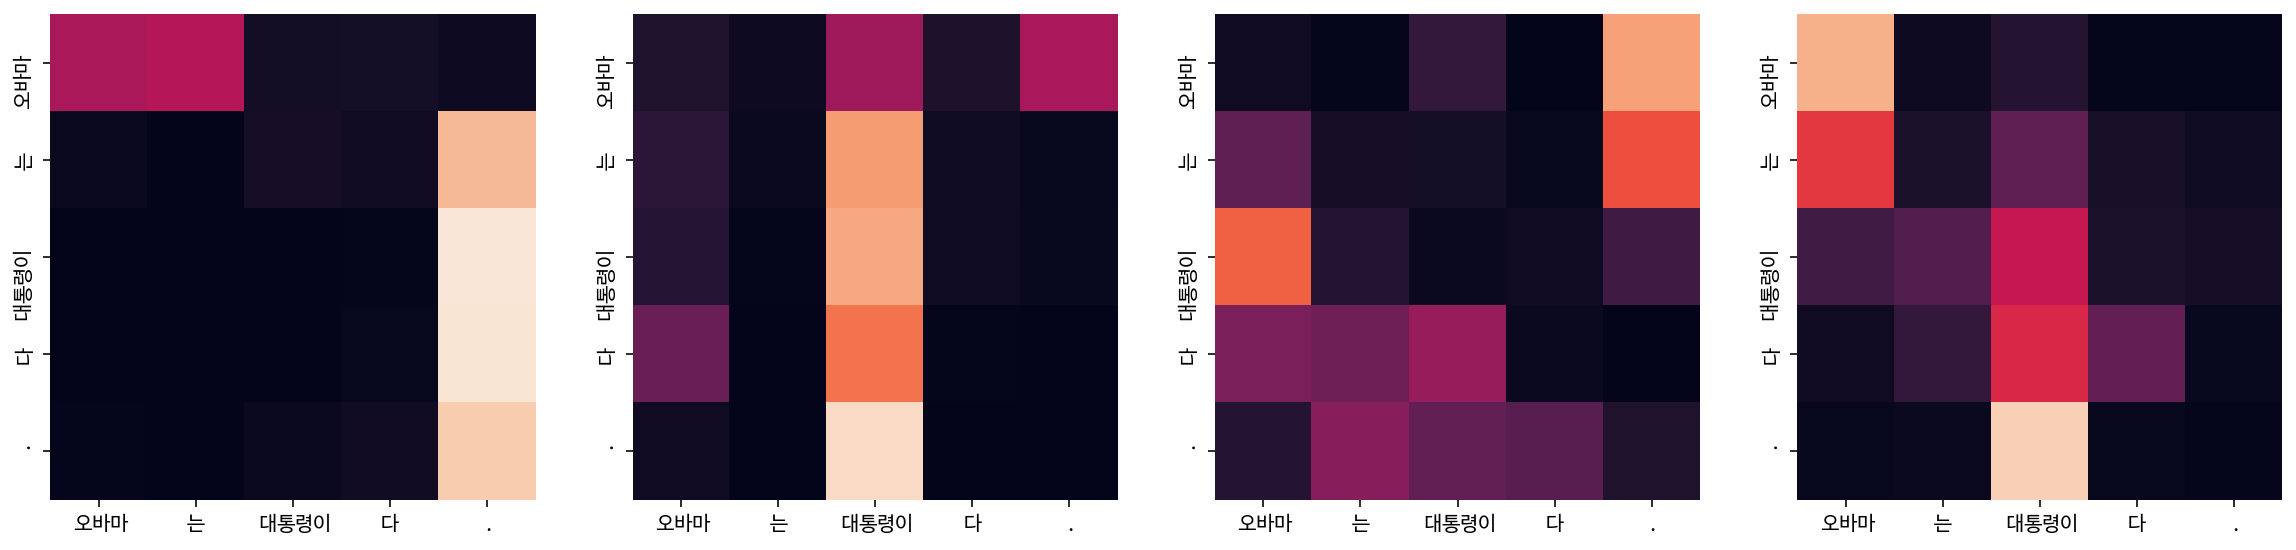

Encoder Layer 2


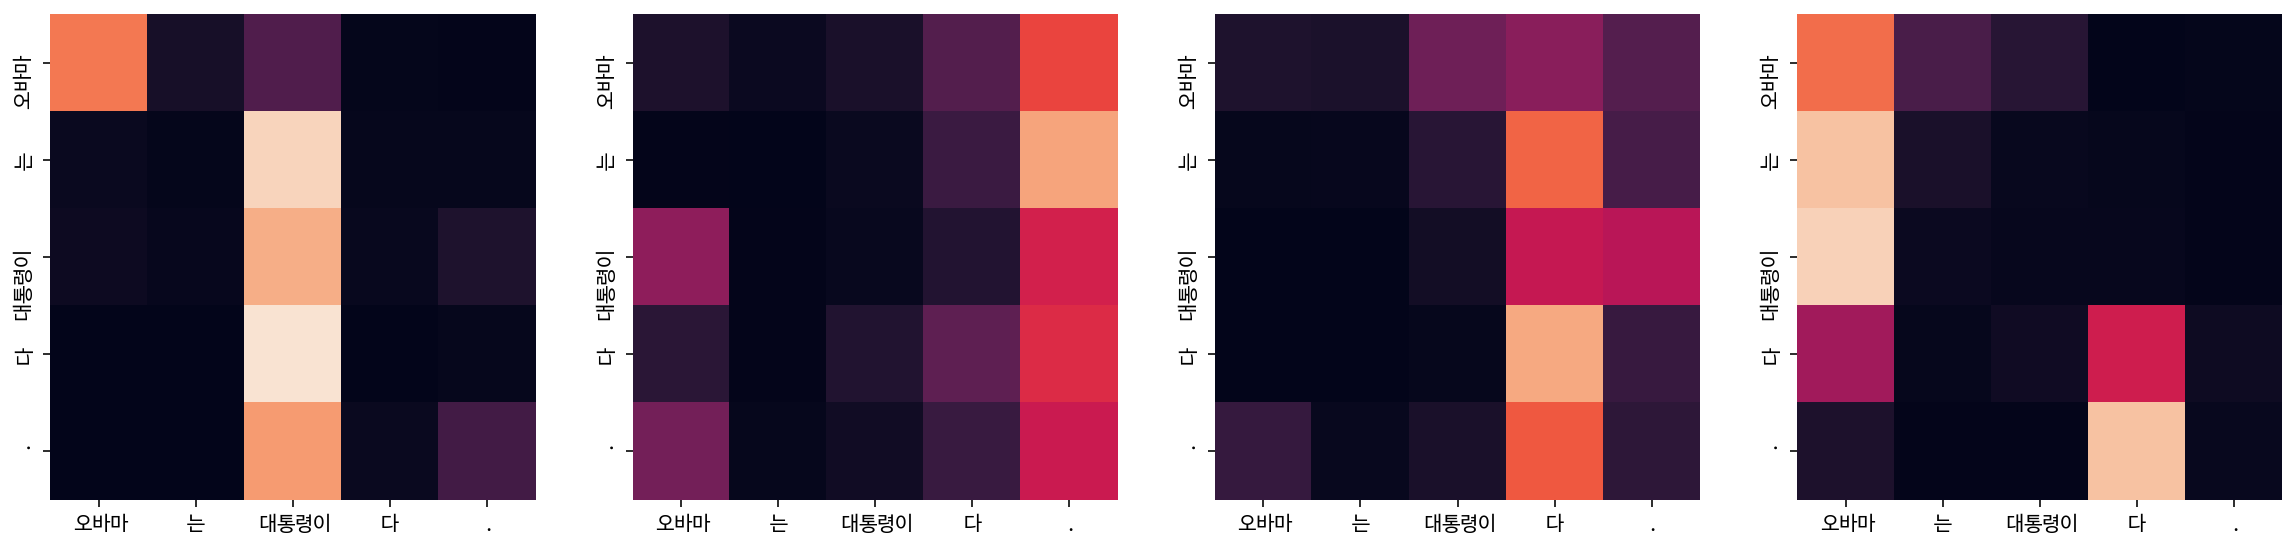

Decoder Self Layer 1


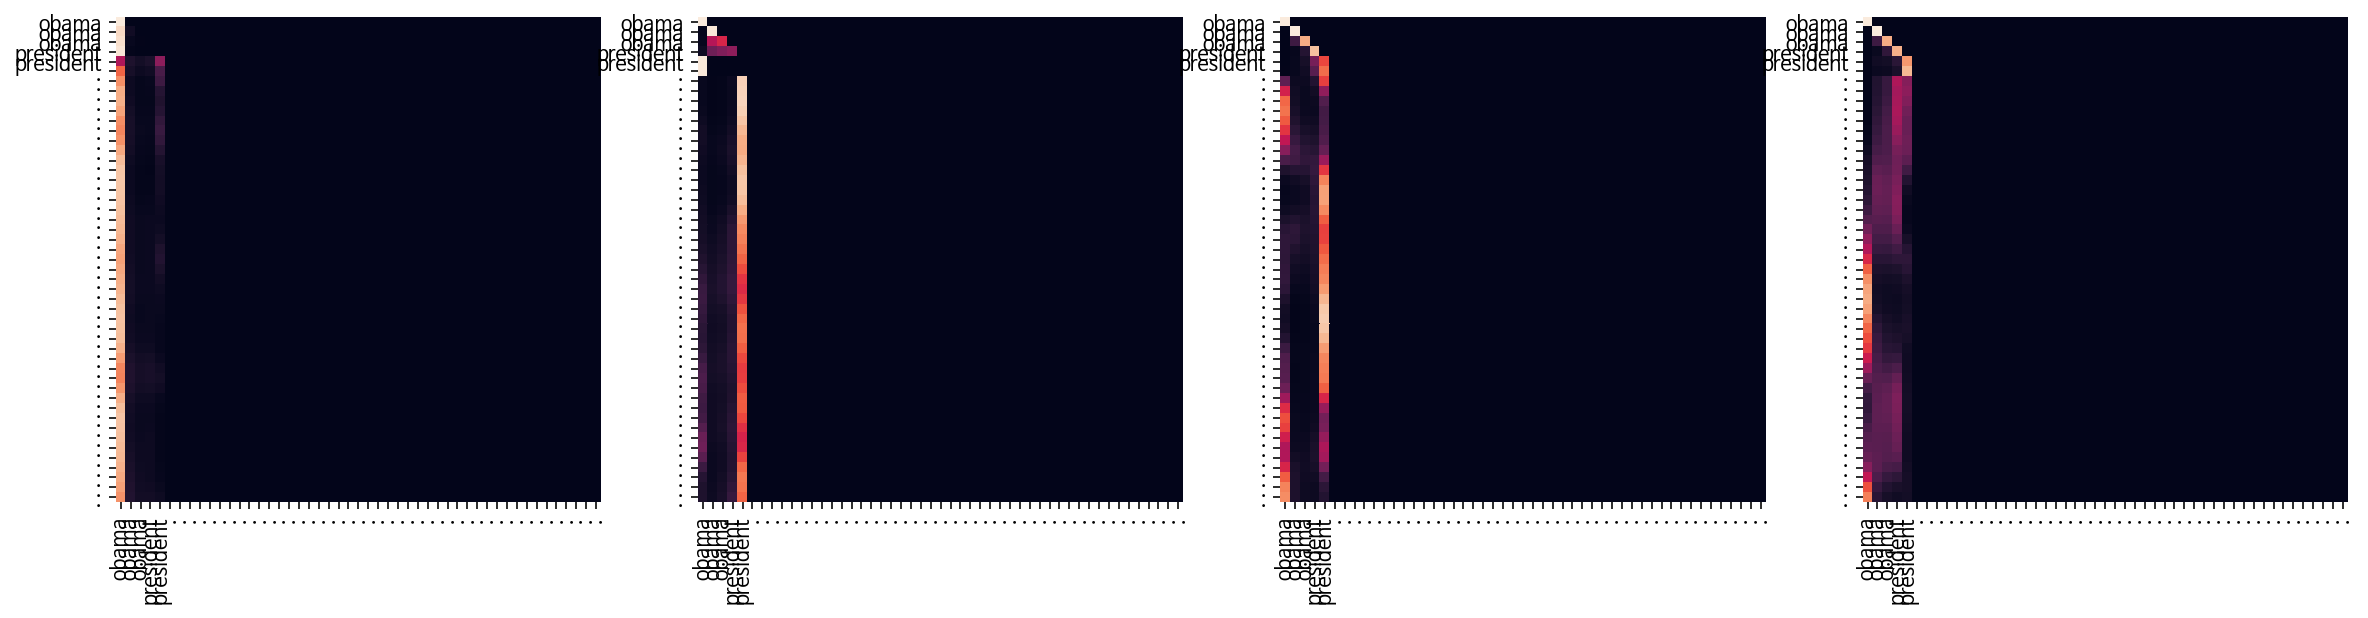

Decoder Src Layer 1


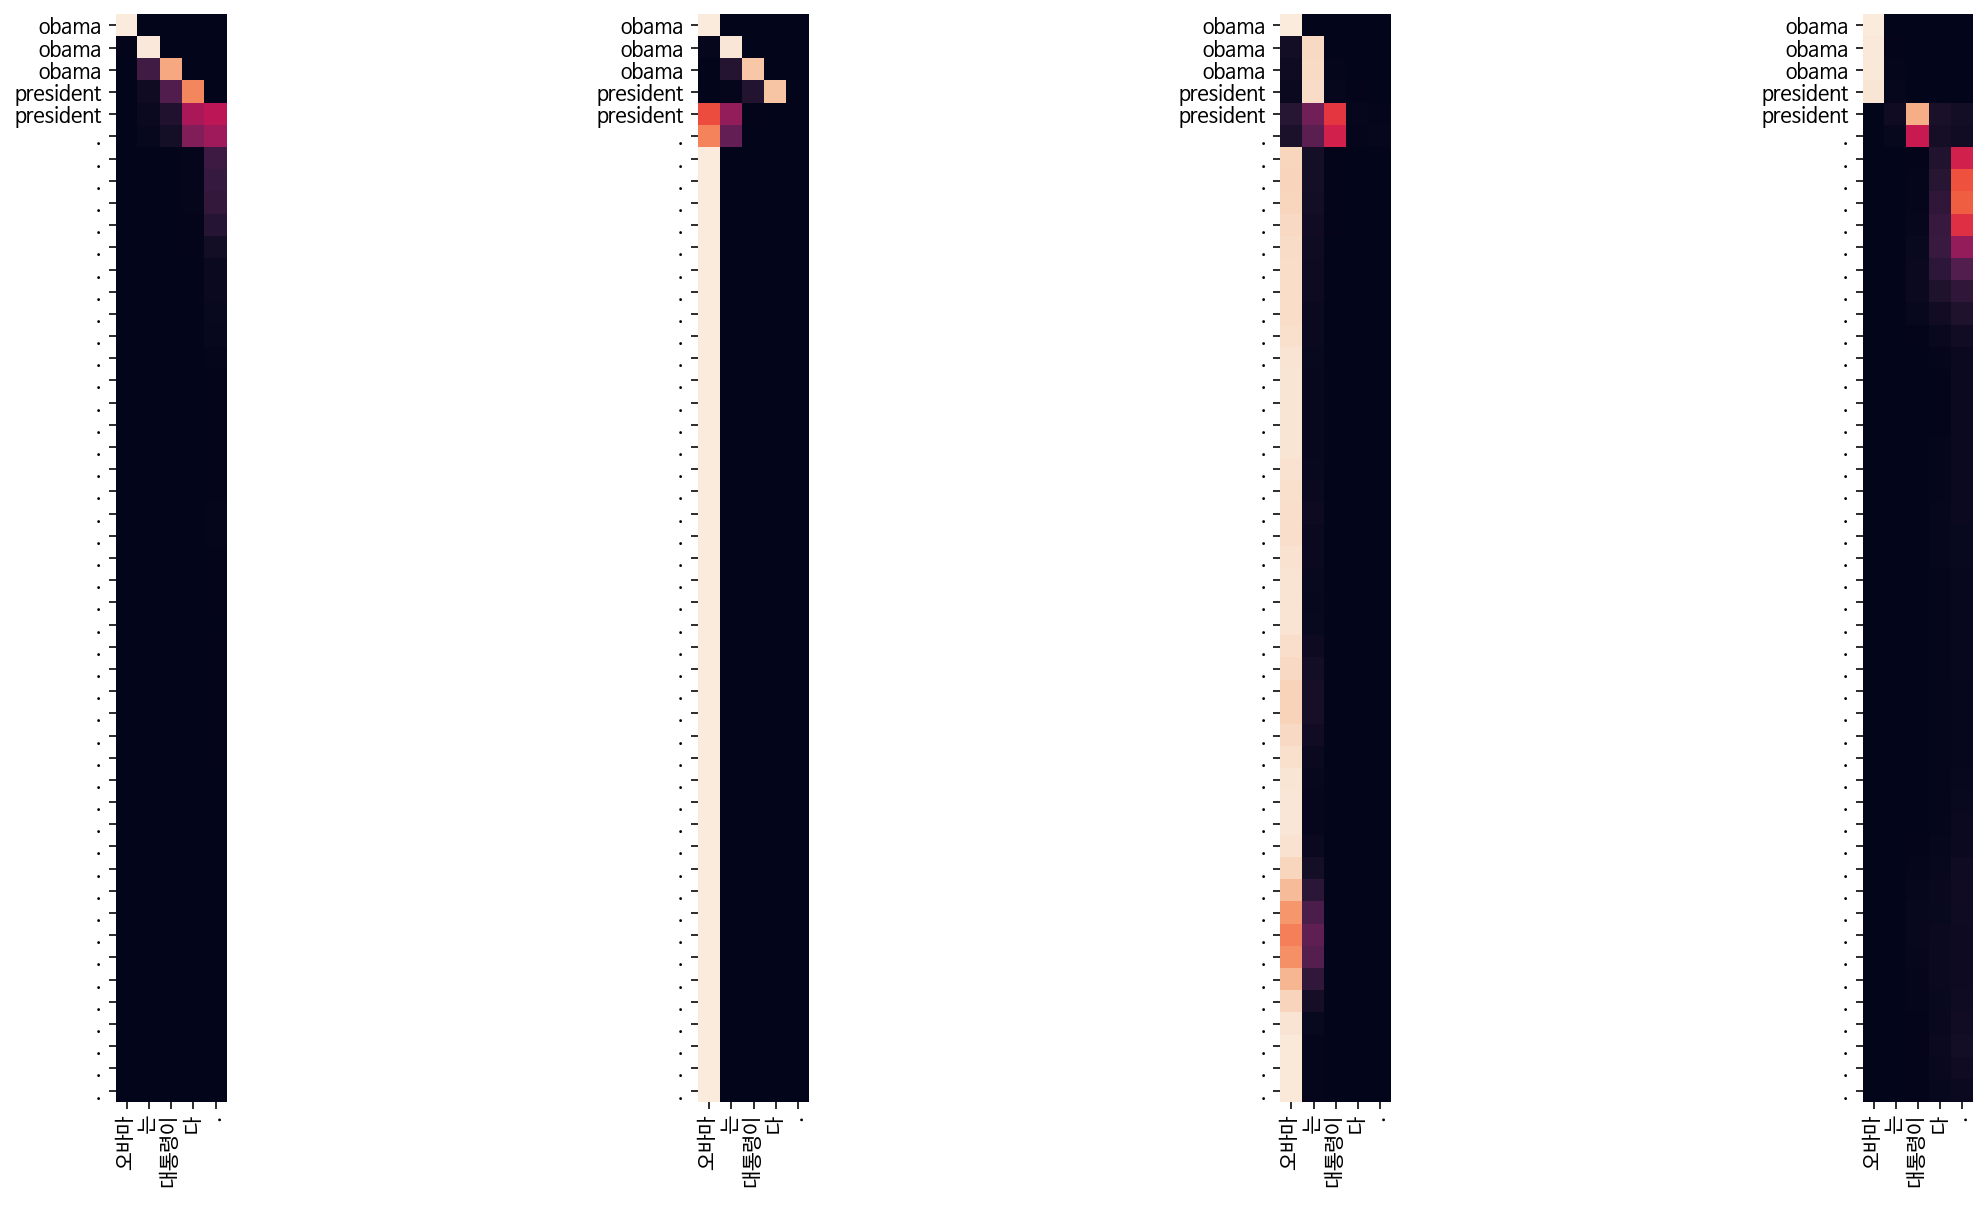

Decoder Self Layer 2


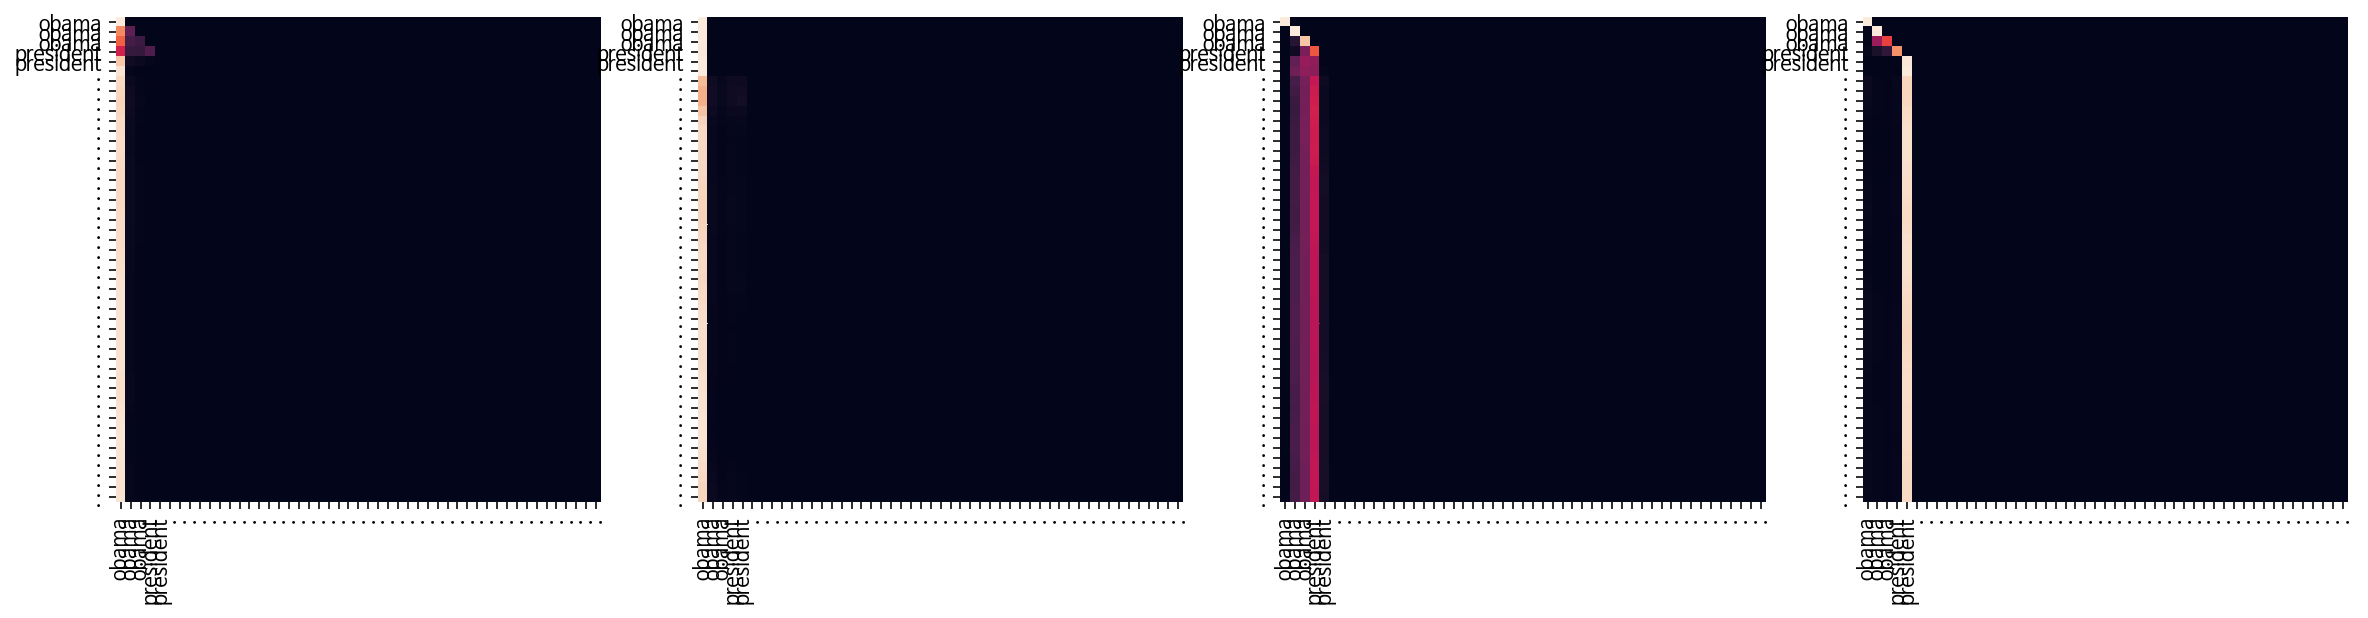

Decoder Src Layer 2


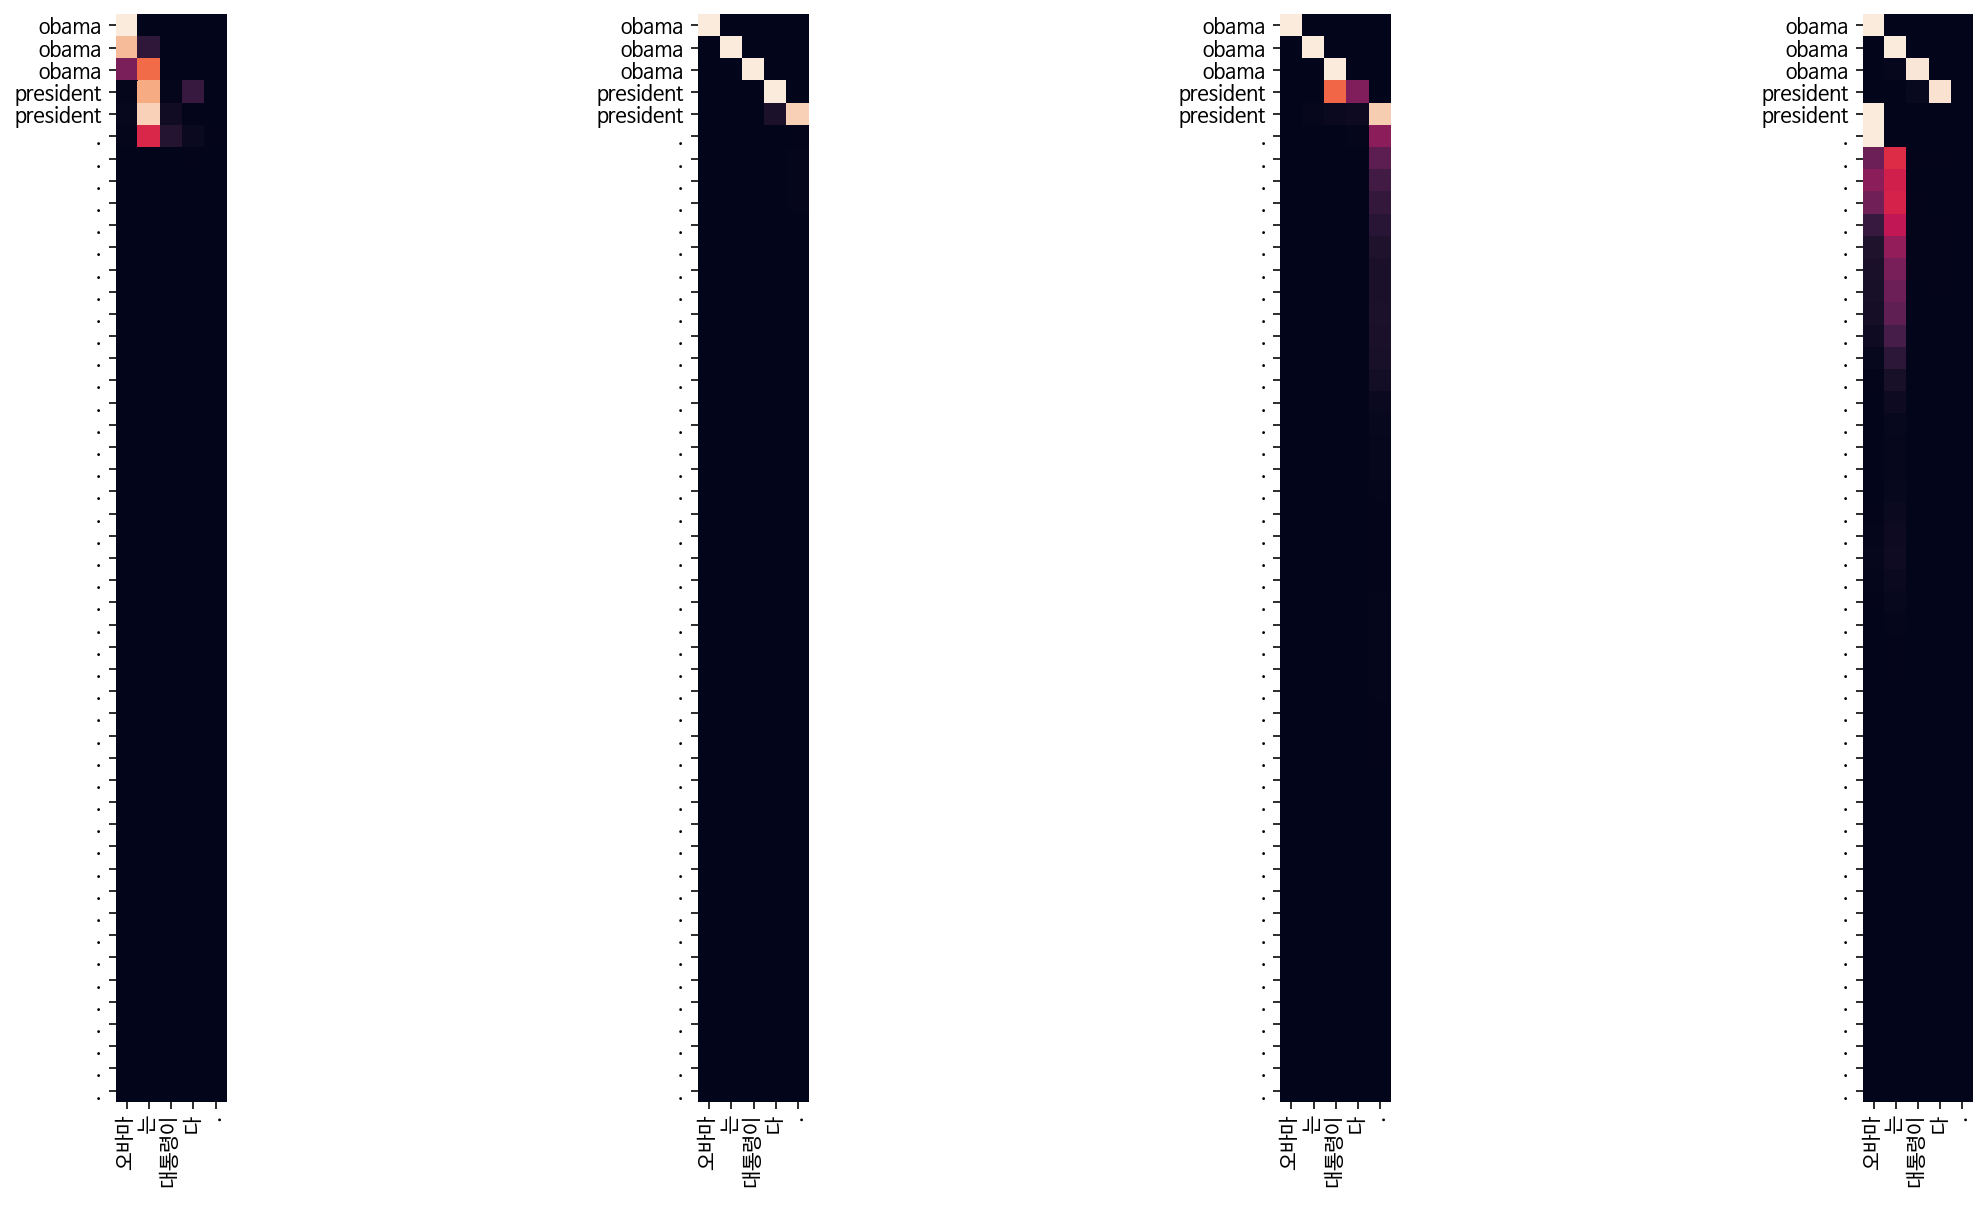

Input: 시민들은 도시 속에 산다.
Predicted translation: is for for . vessel . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Encoder Layer 1


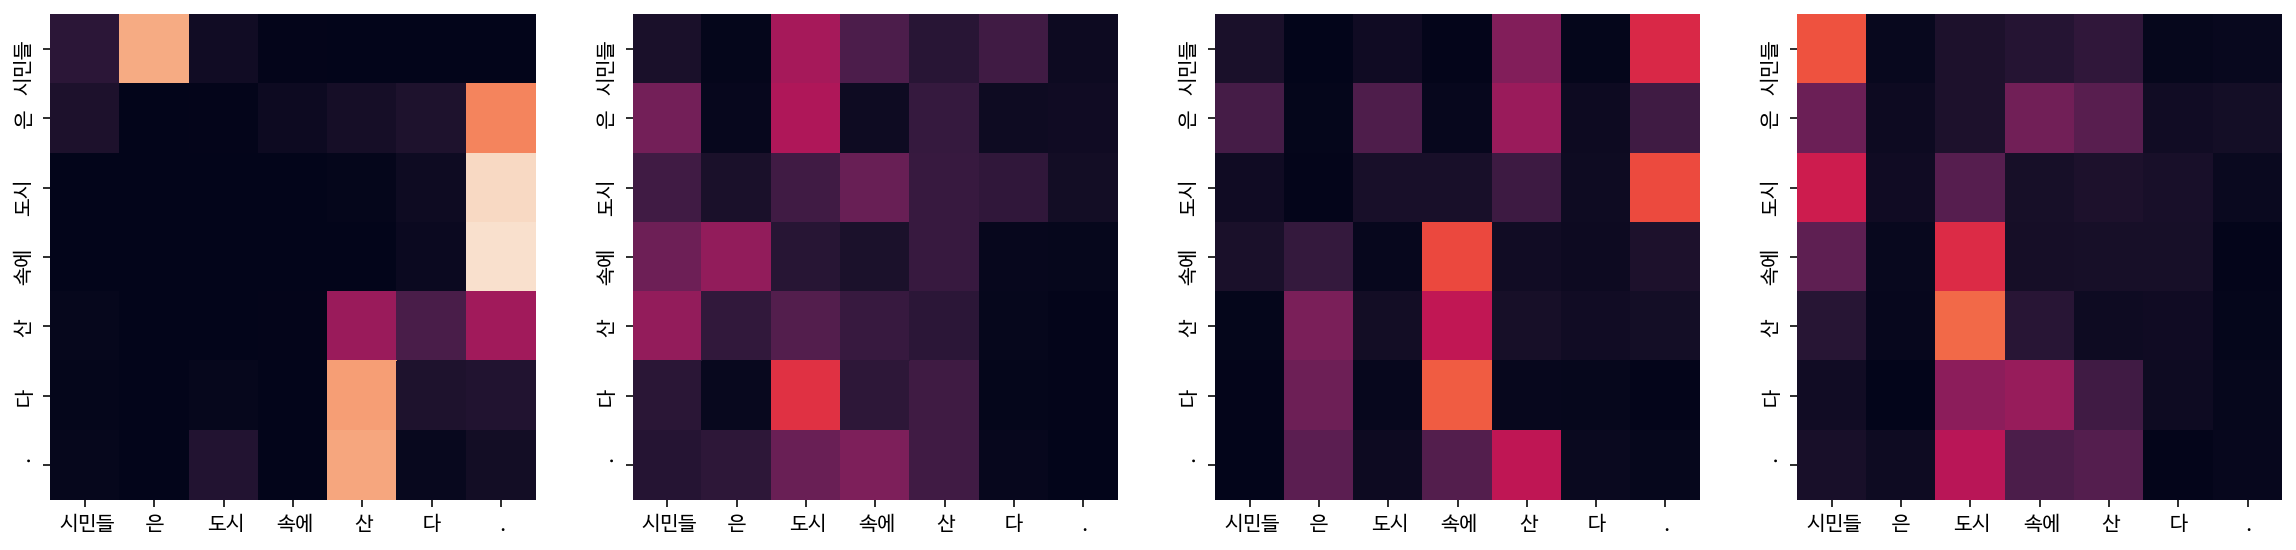

Encoder Layer 2


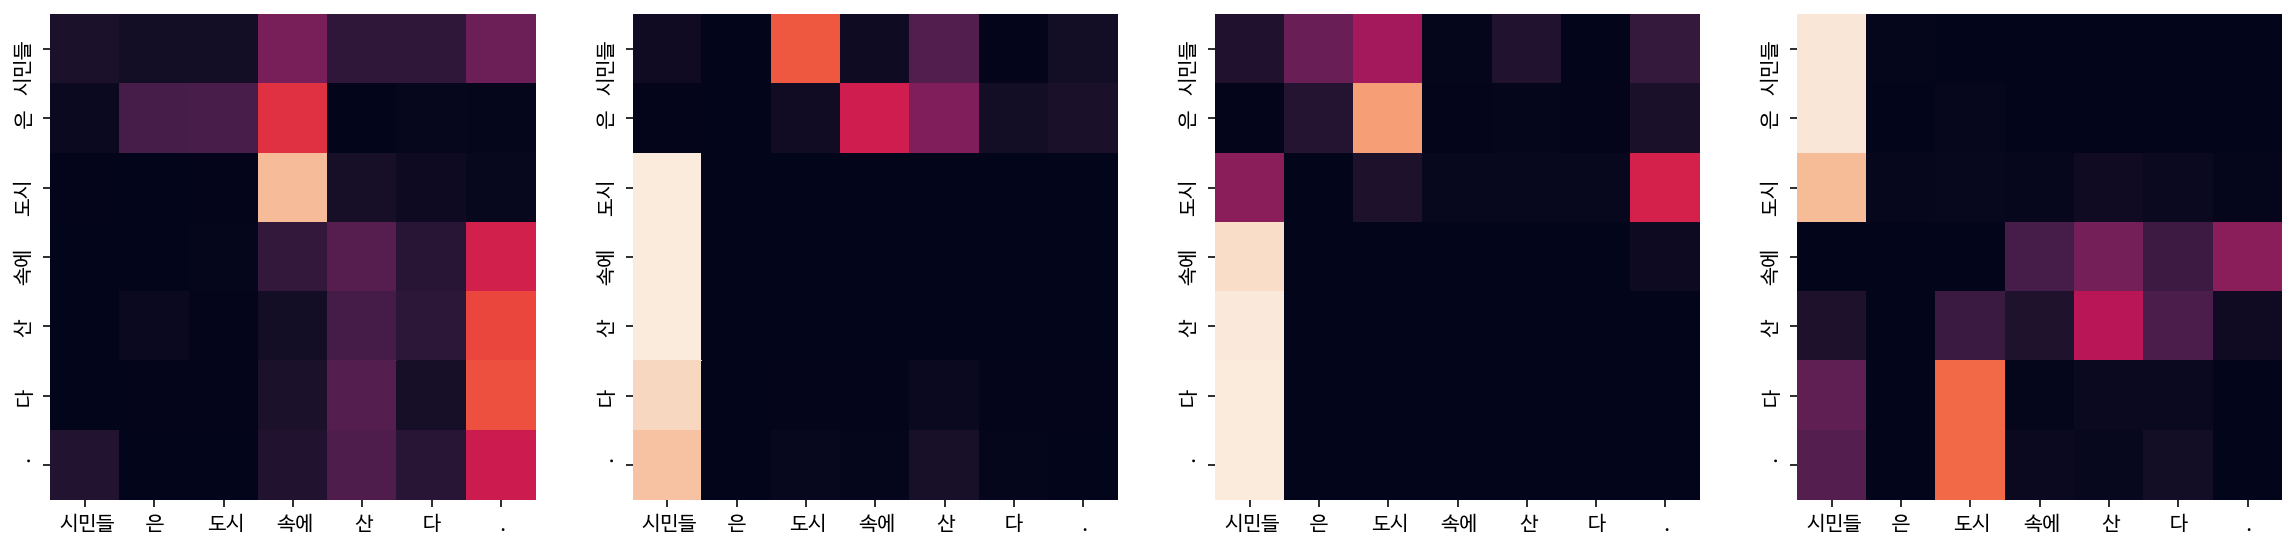

Decoder Self Layer 1


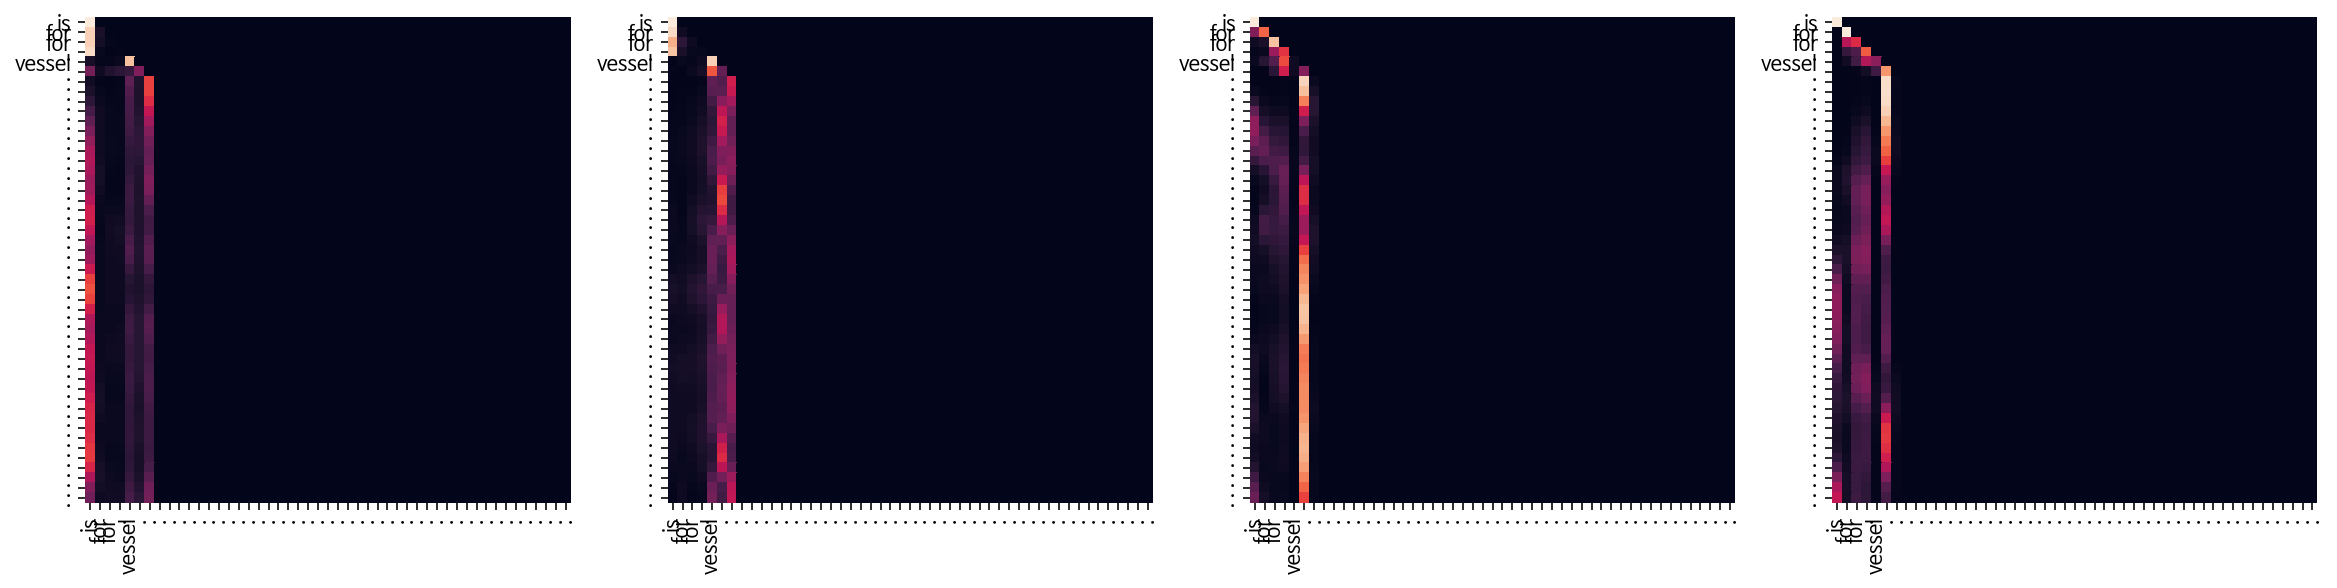

Decoder Src Layer 1


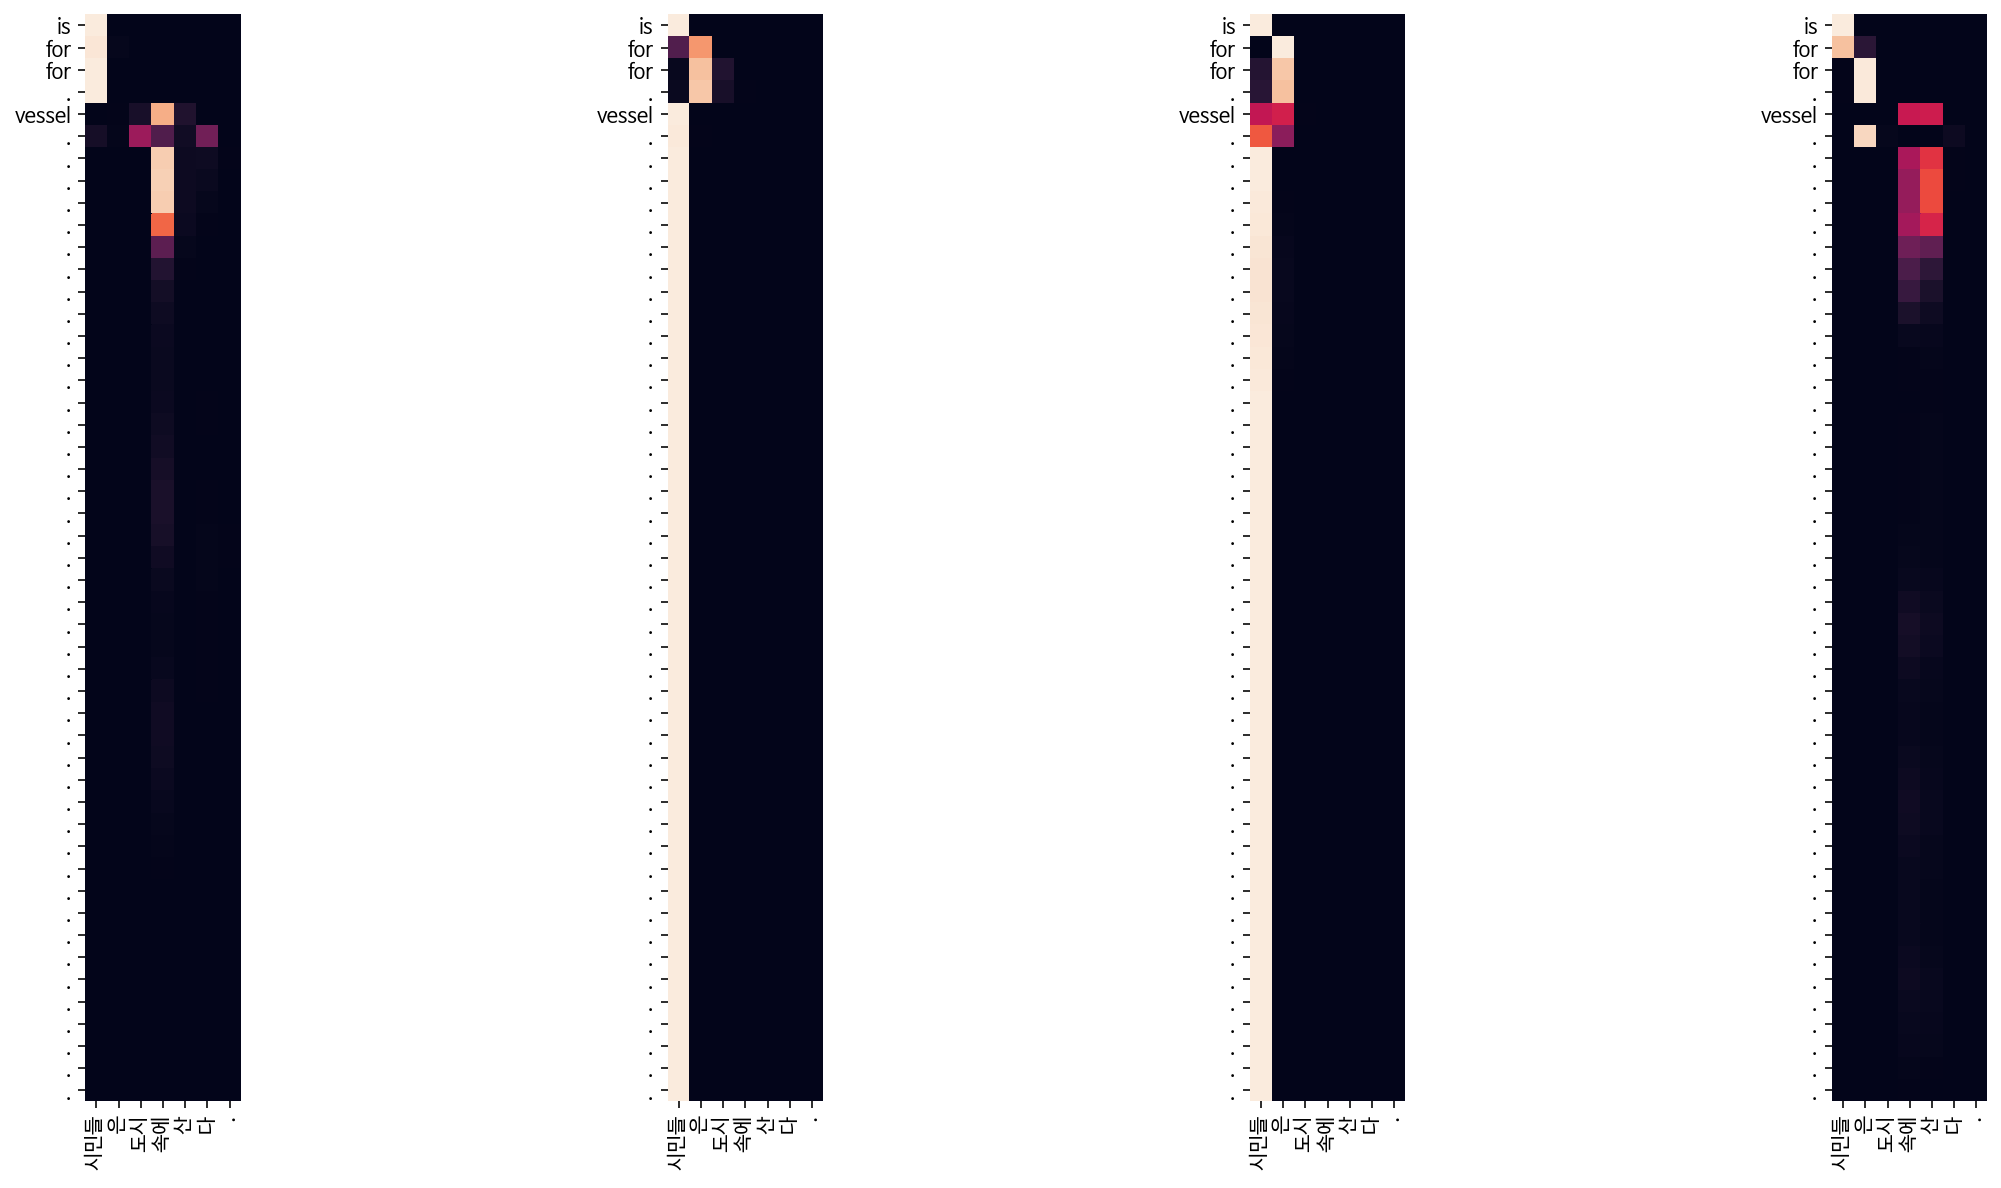

Decoder Self Layer 2


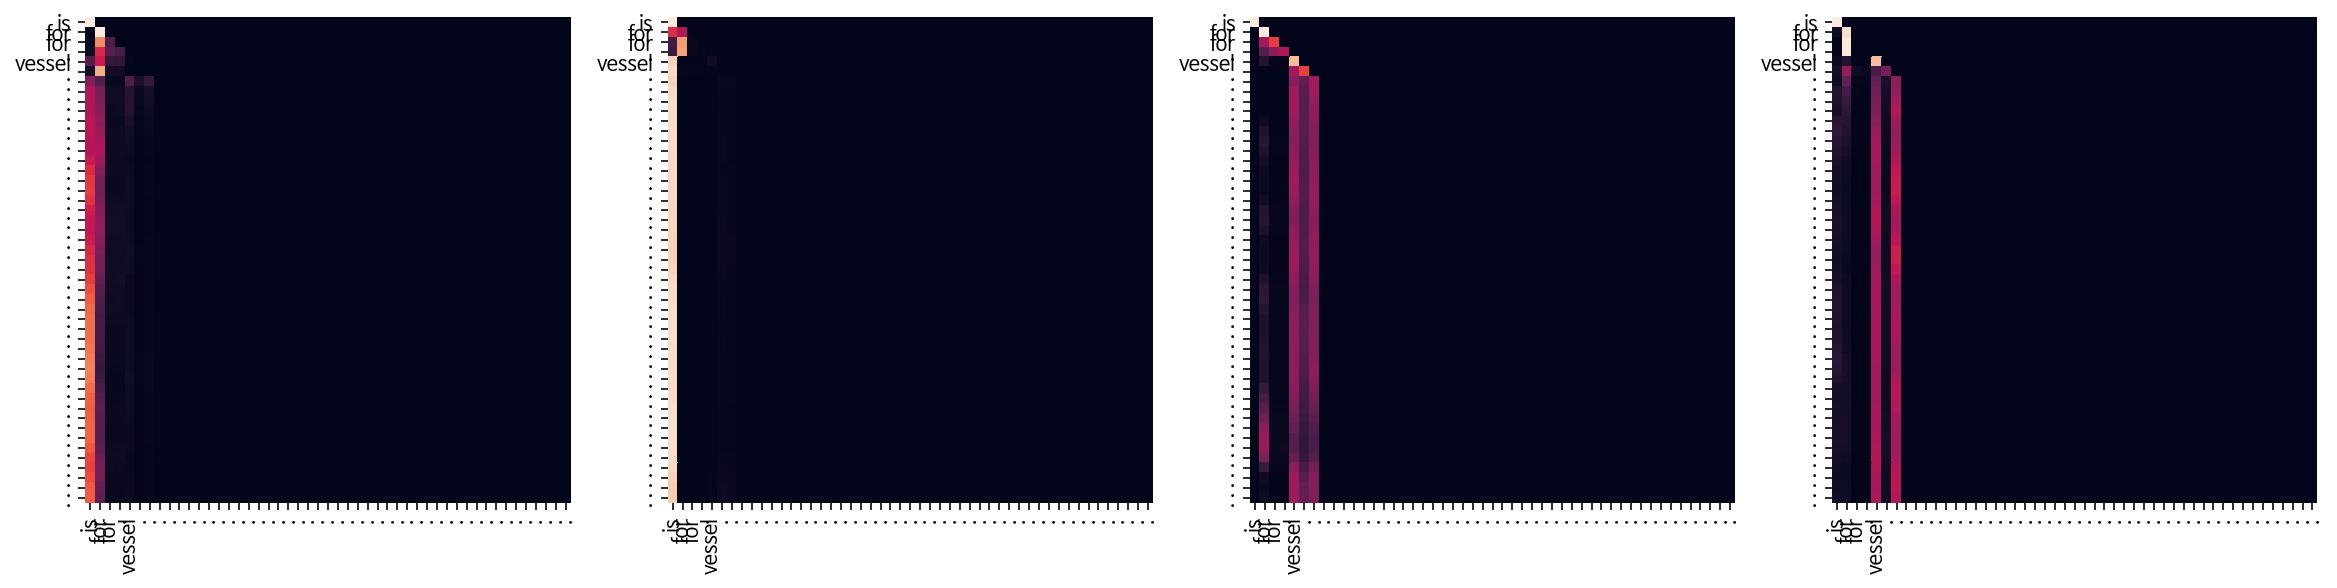

Decoder Src Layer 2


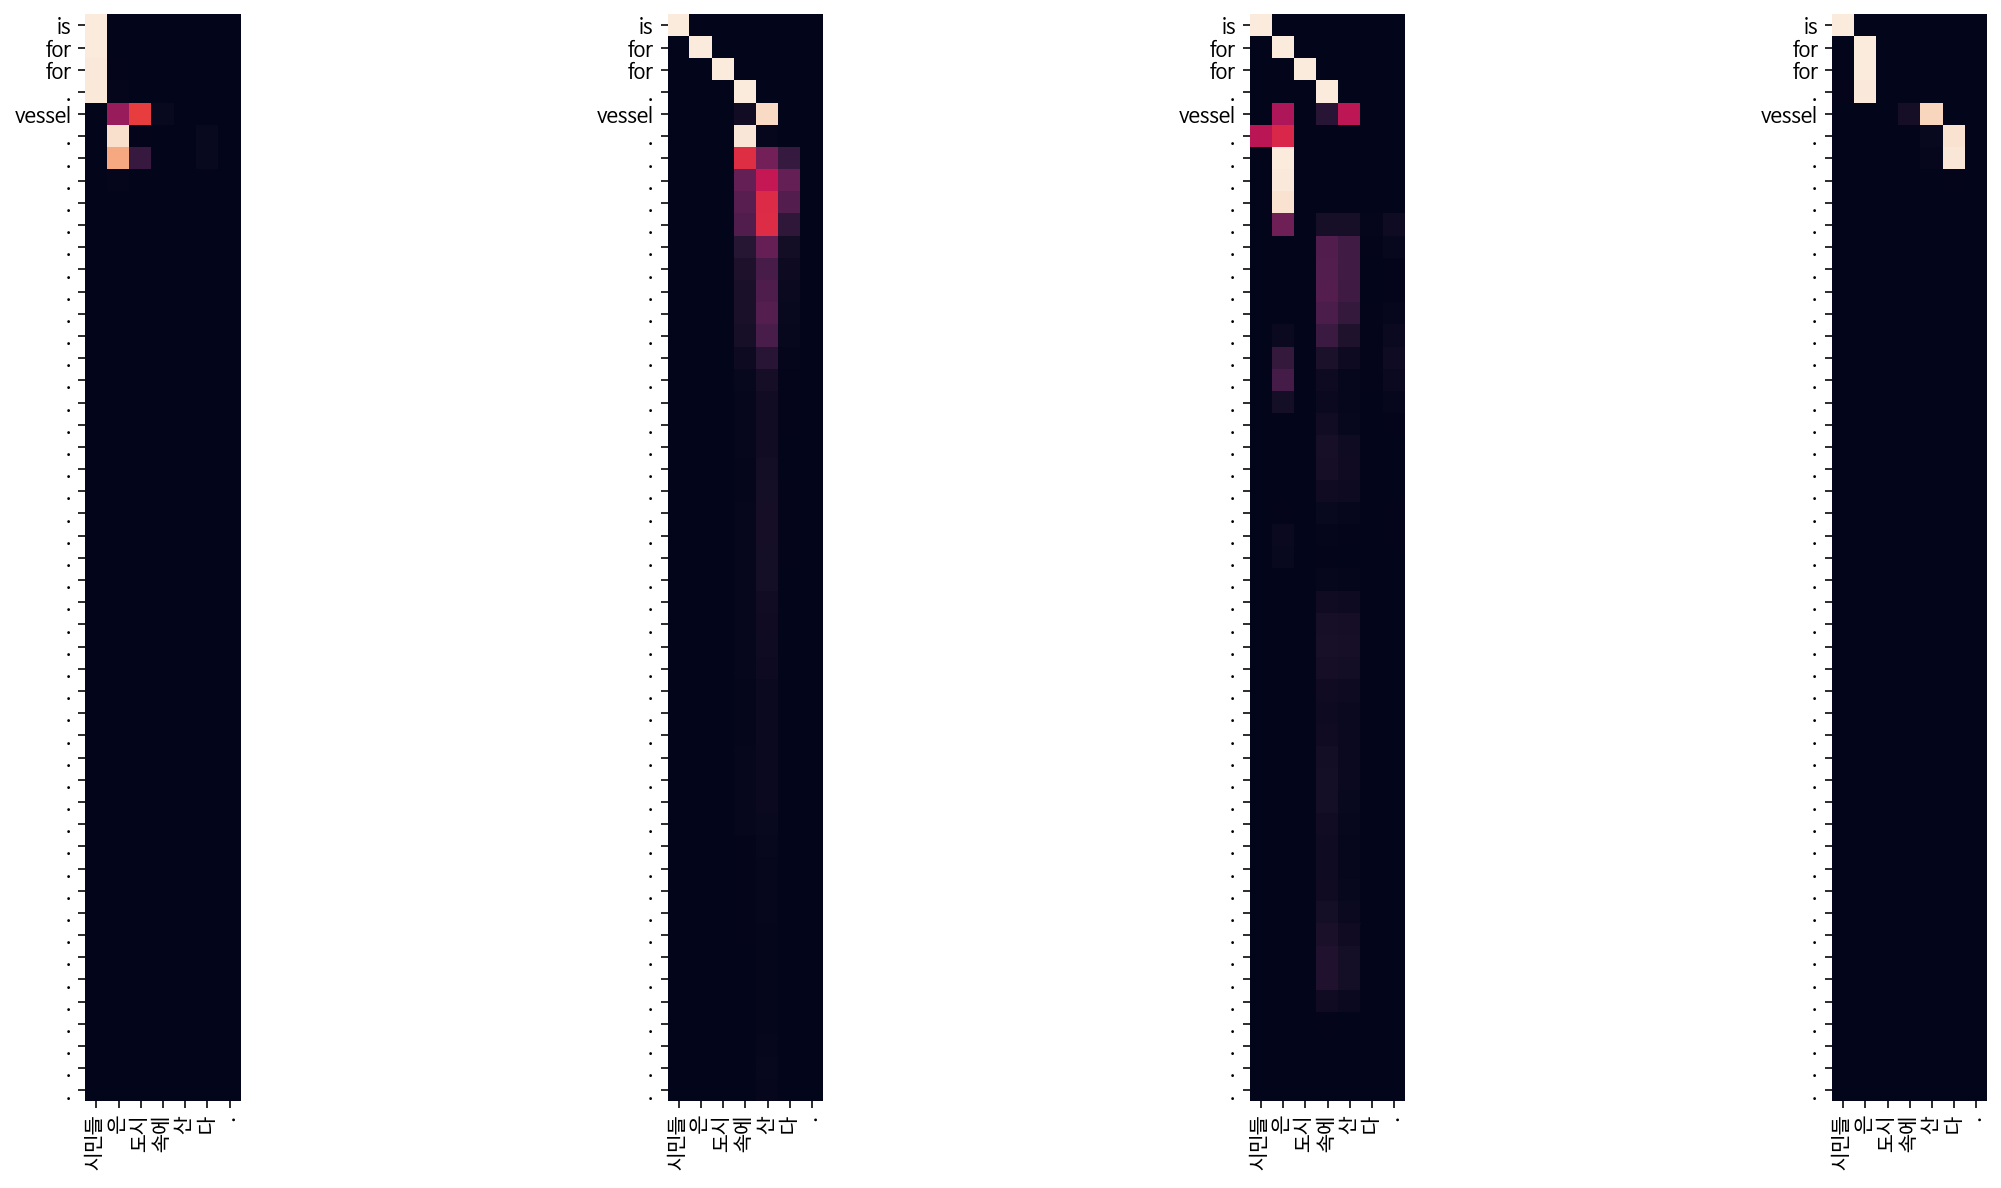

Input: 커피는 필요 없다.
Predicted translation: for is you you for
Encoder Layer 1


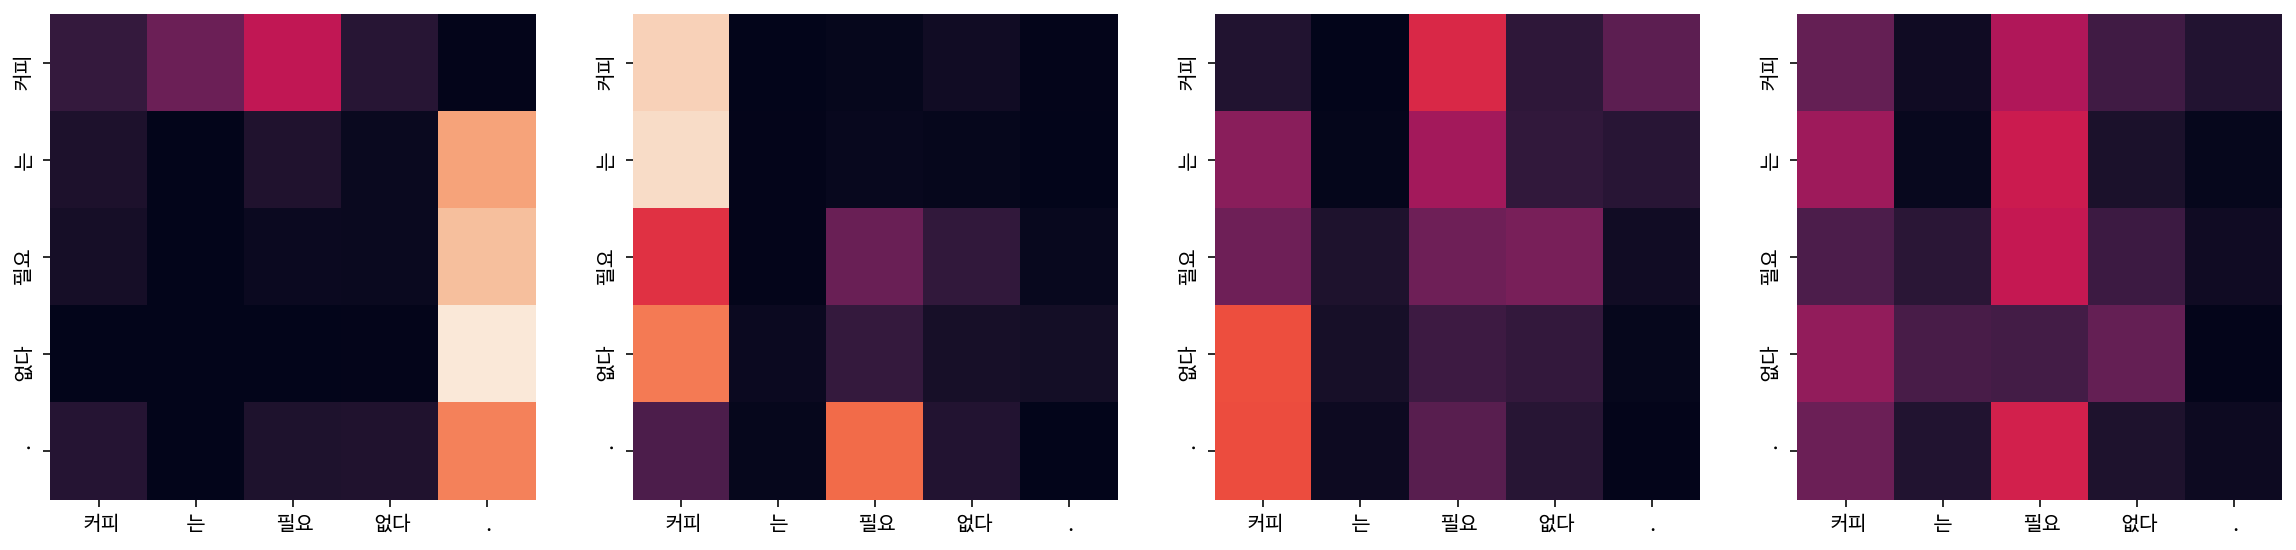

Encoder Layer 2


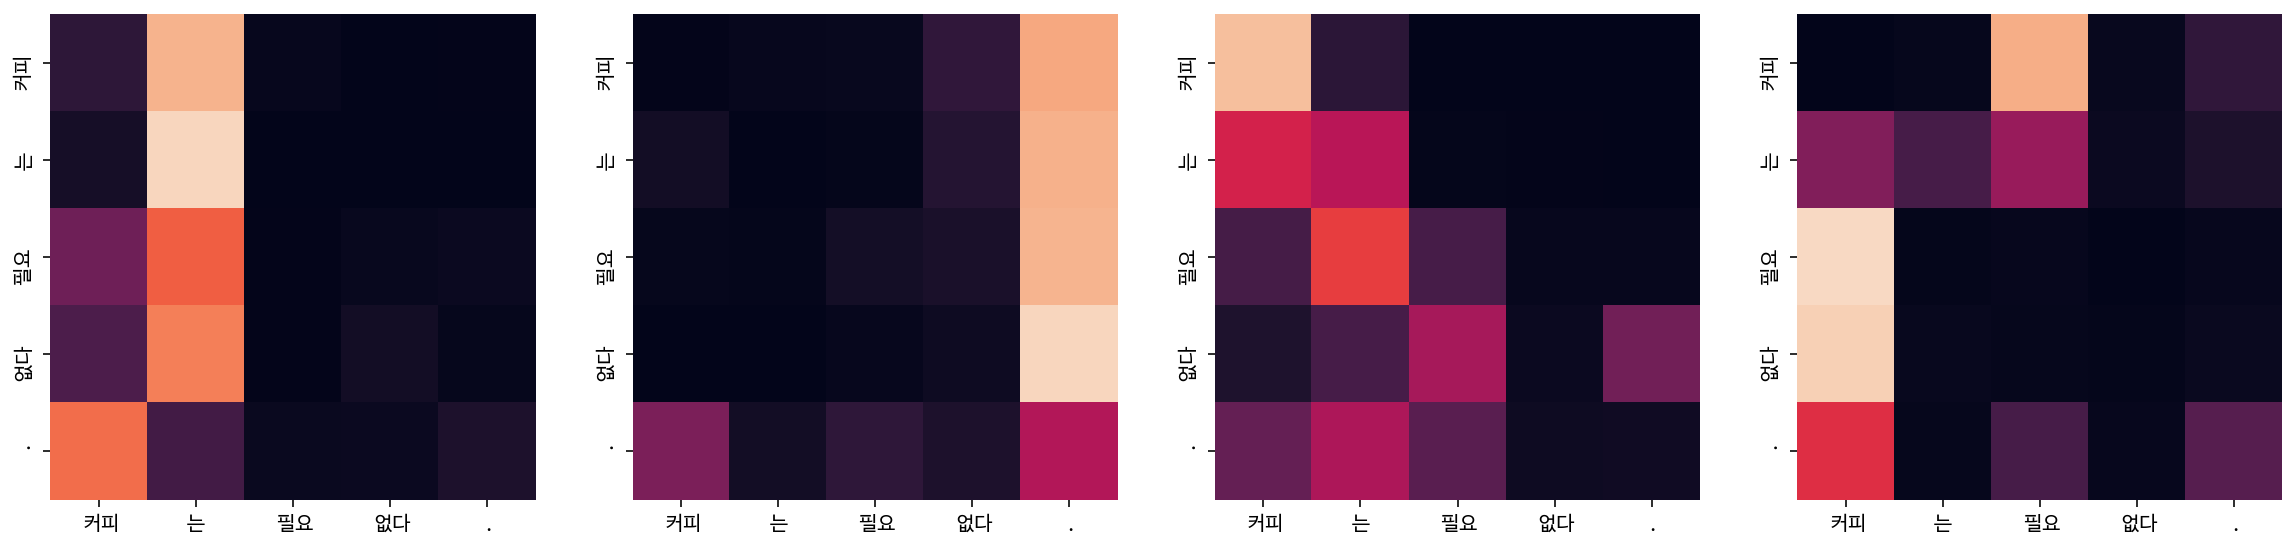

Decoder Self Layer 1


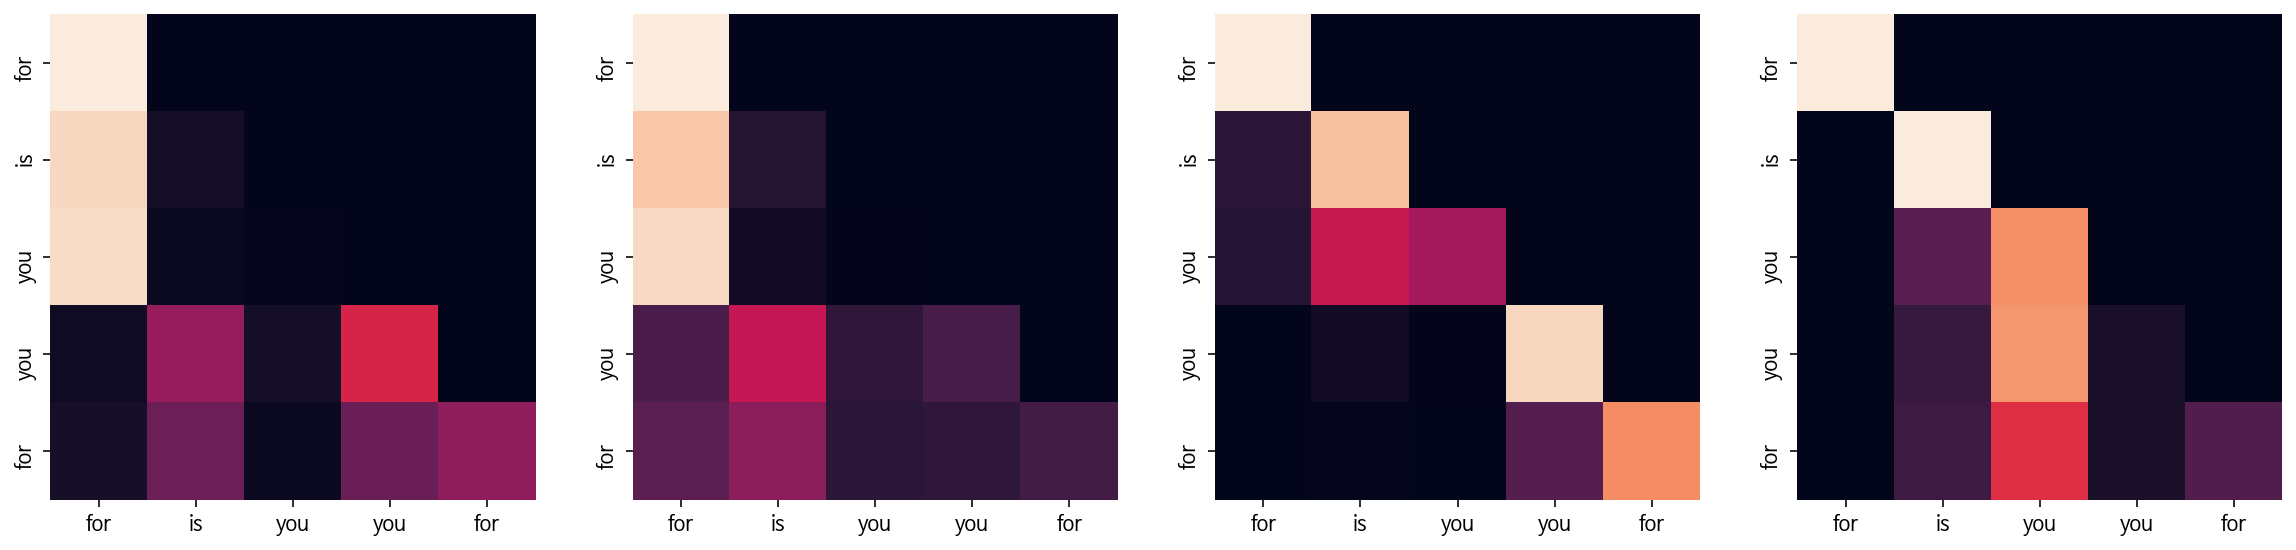

Decoder Src Layer 1


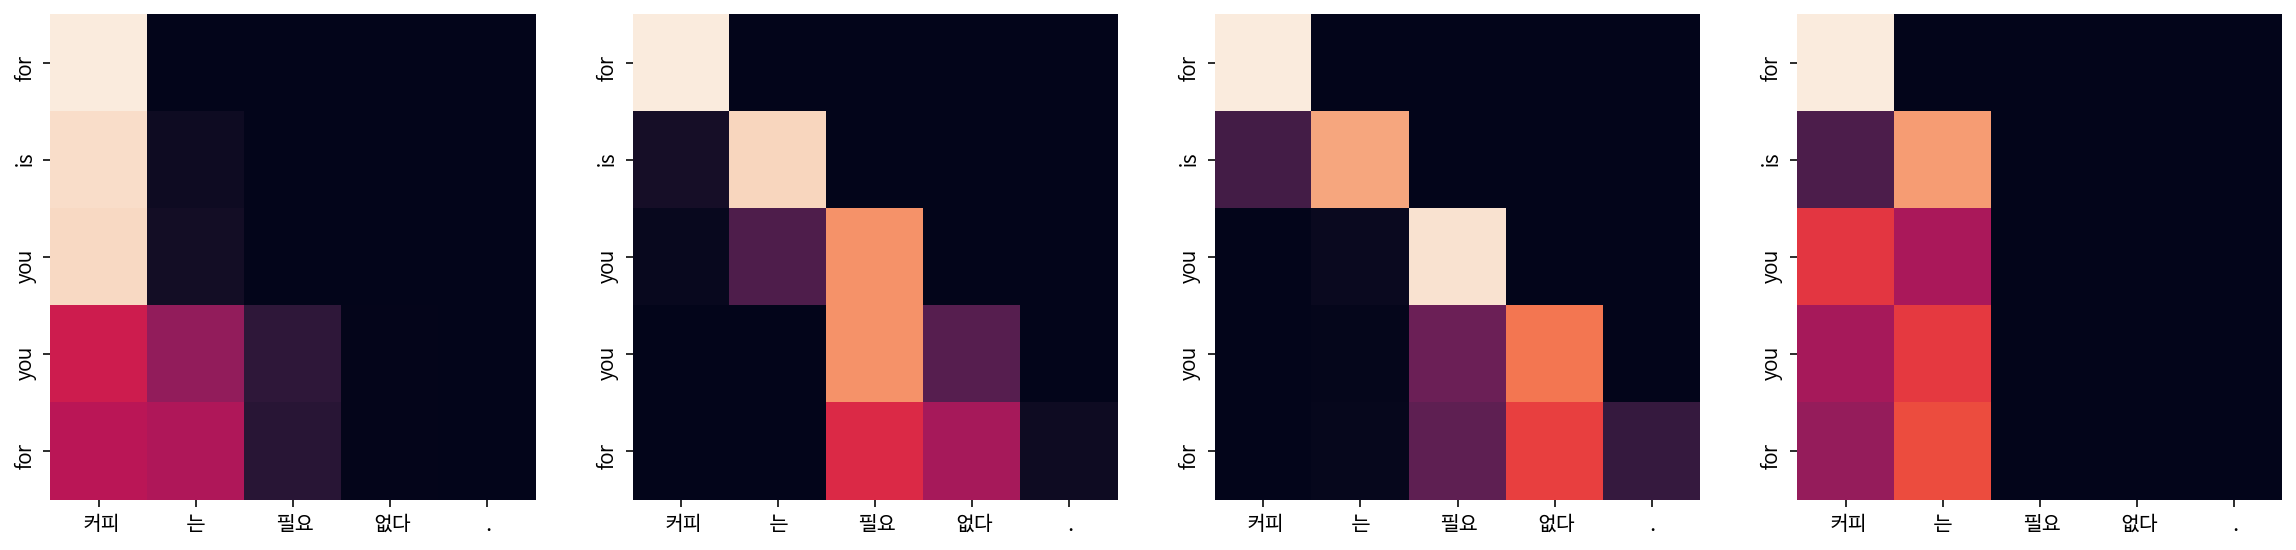

Decoder Self Layer 2


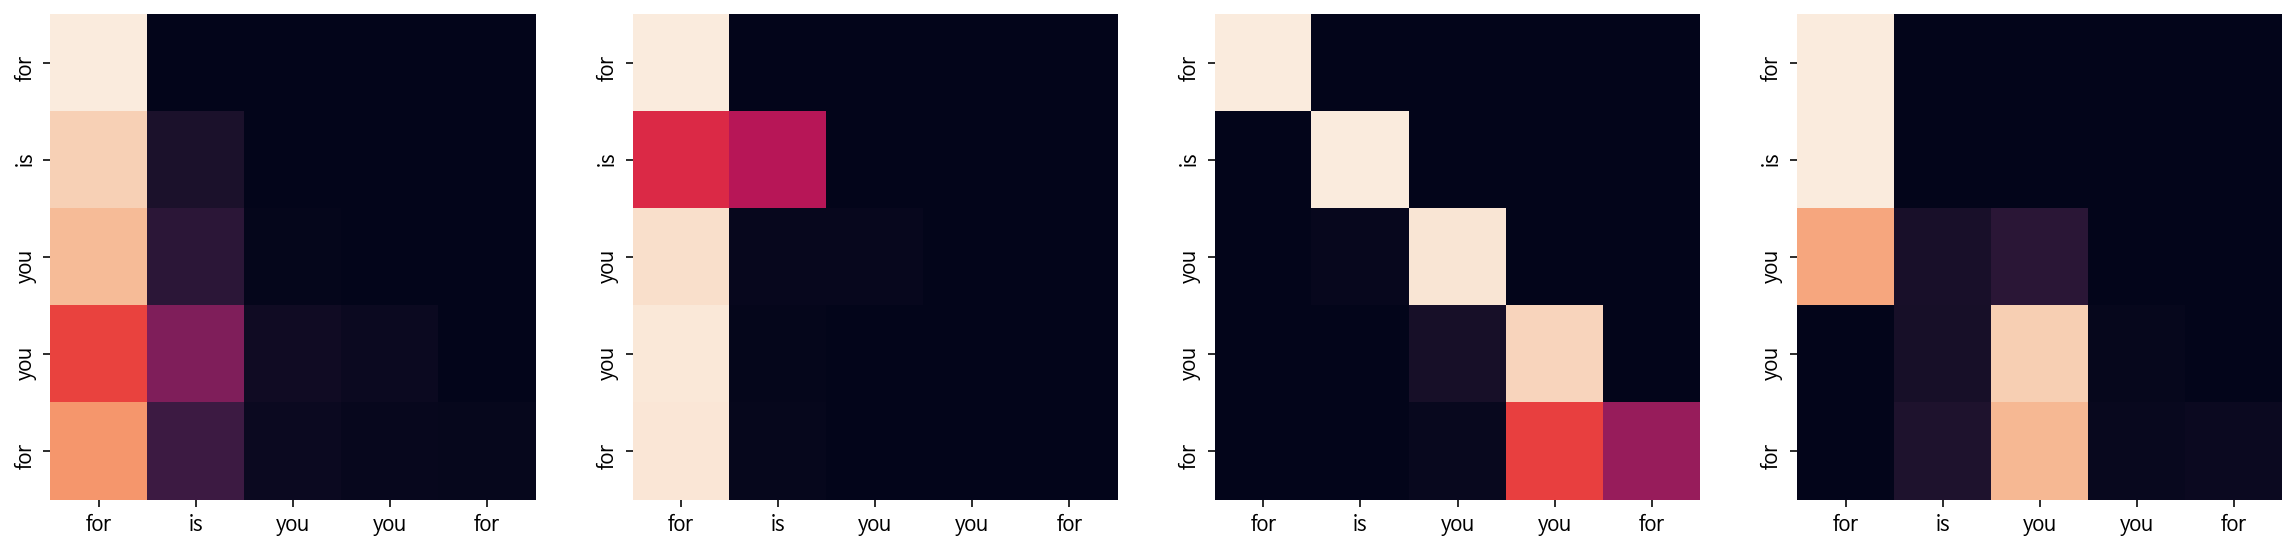

Decoder Src Layer 2


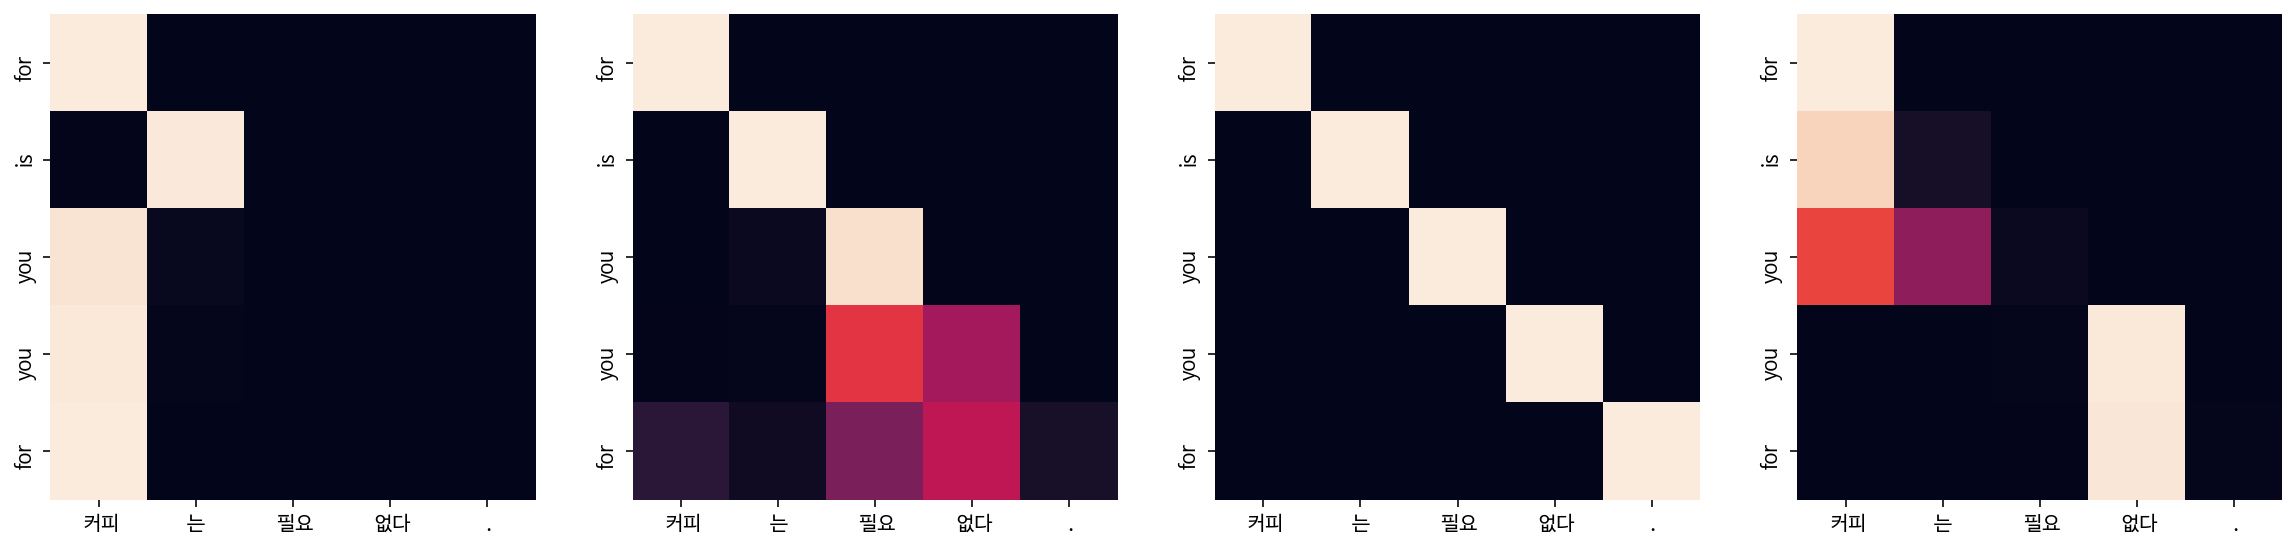

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: and . was was accident .eded . .ededededededededededededededededededededededededededed . . . . . . . . . . . .
Encoder Layer 1


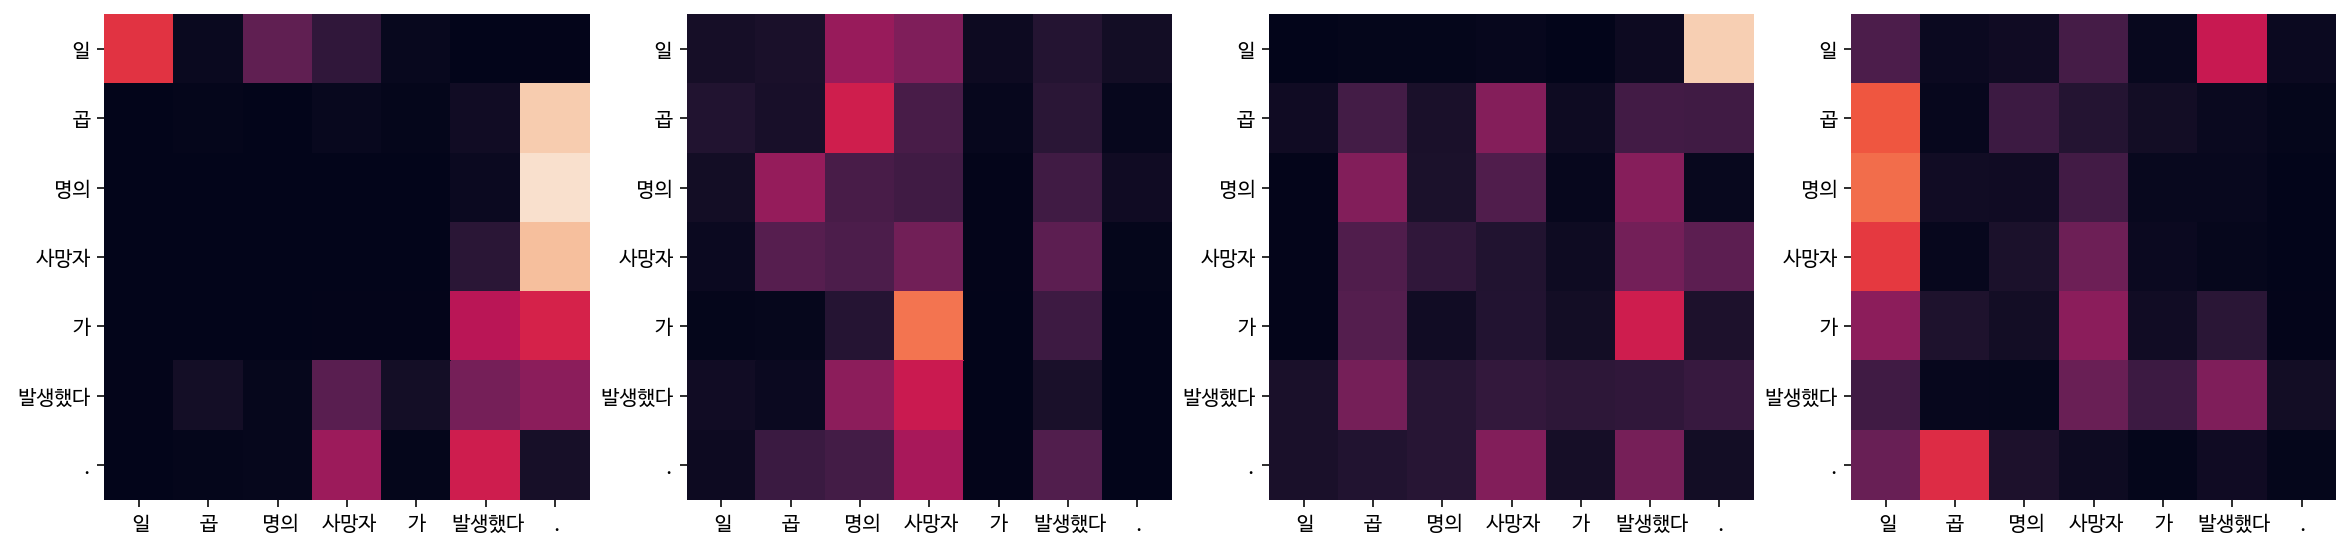

Encoder Layer 2


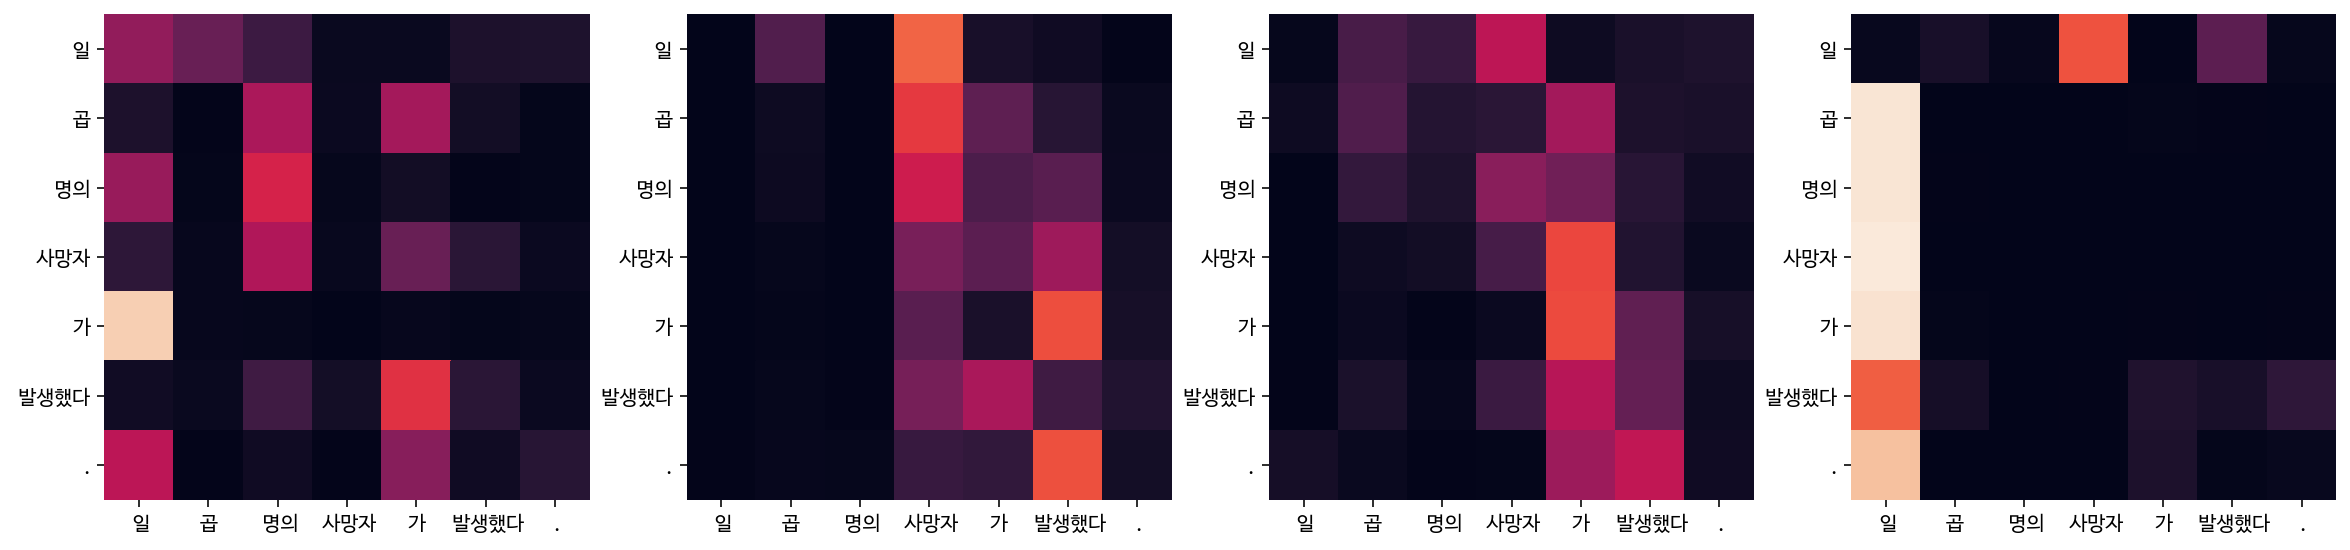

Decoder Self Layer 1


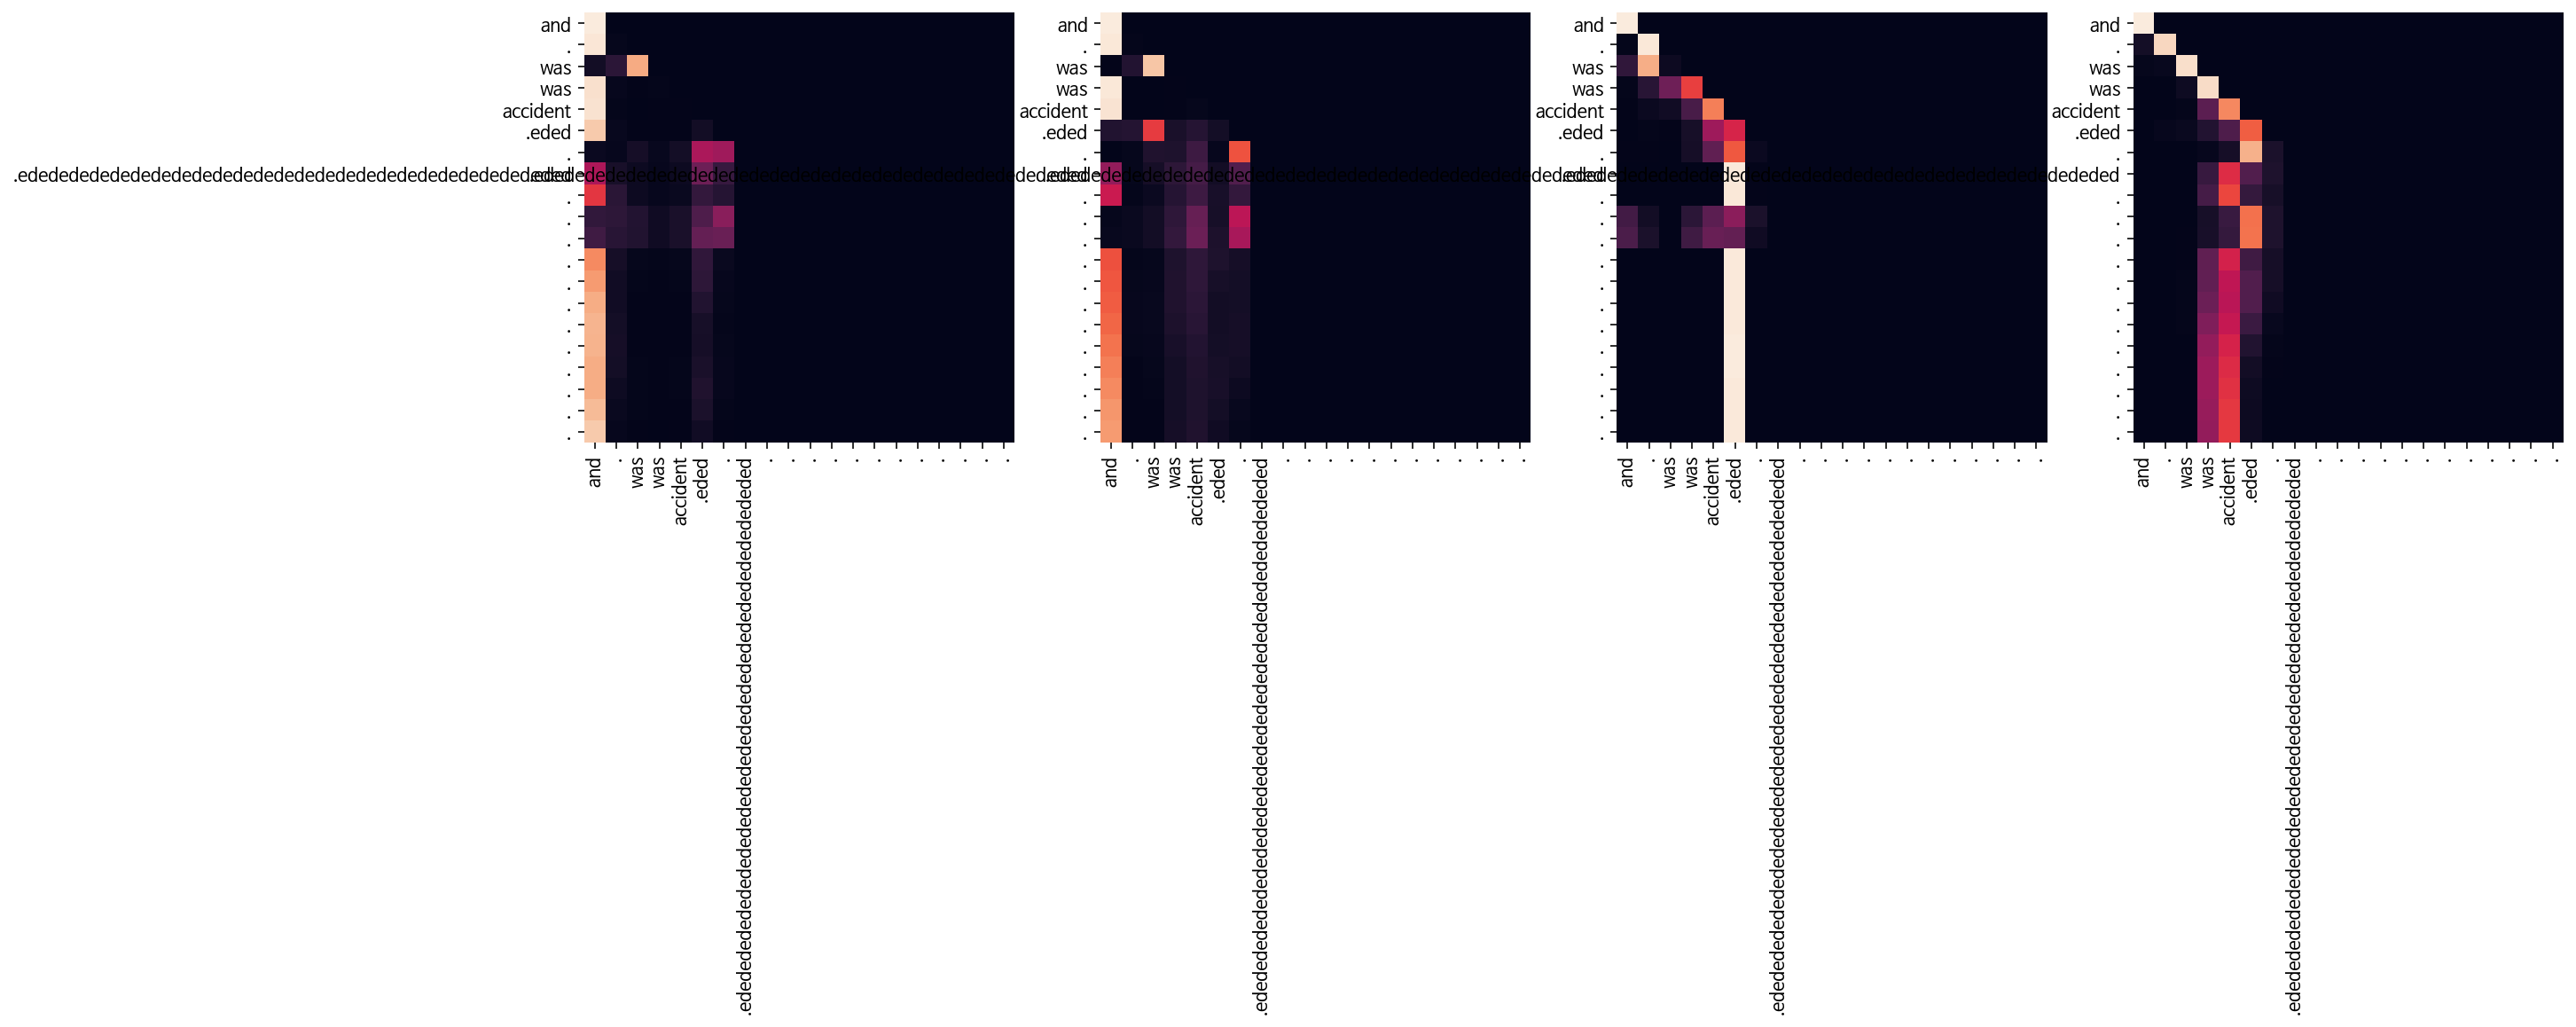

Decoder Src Layer 1


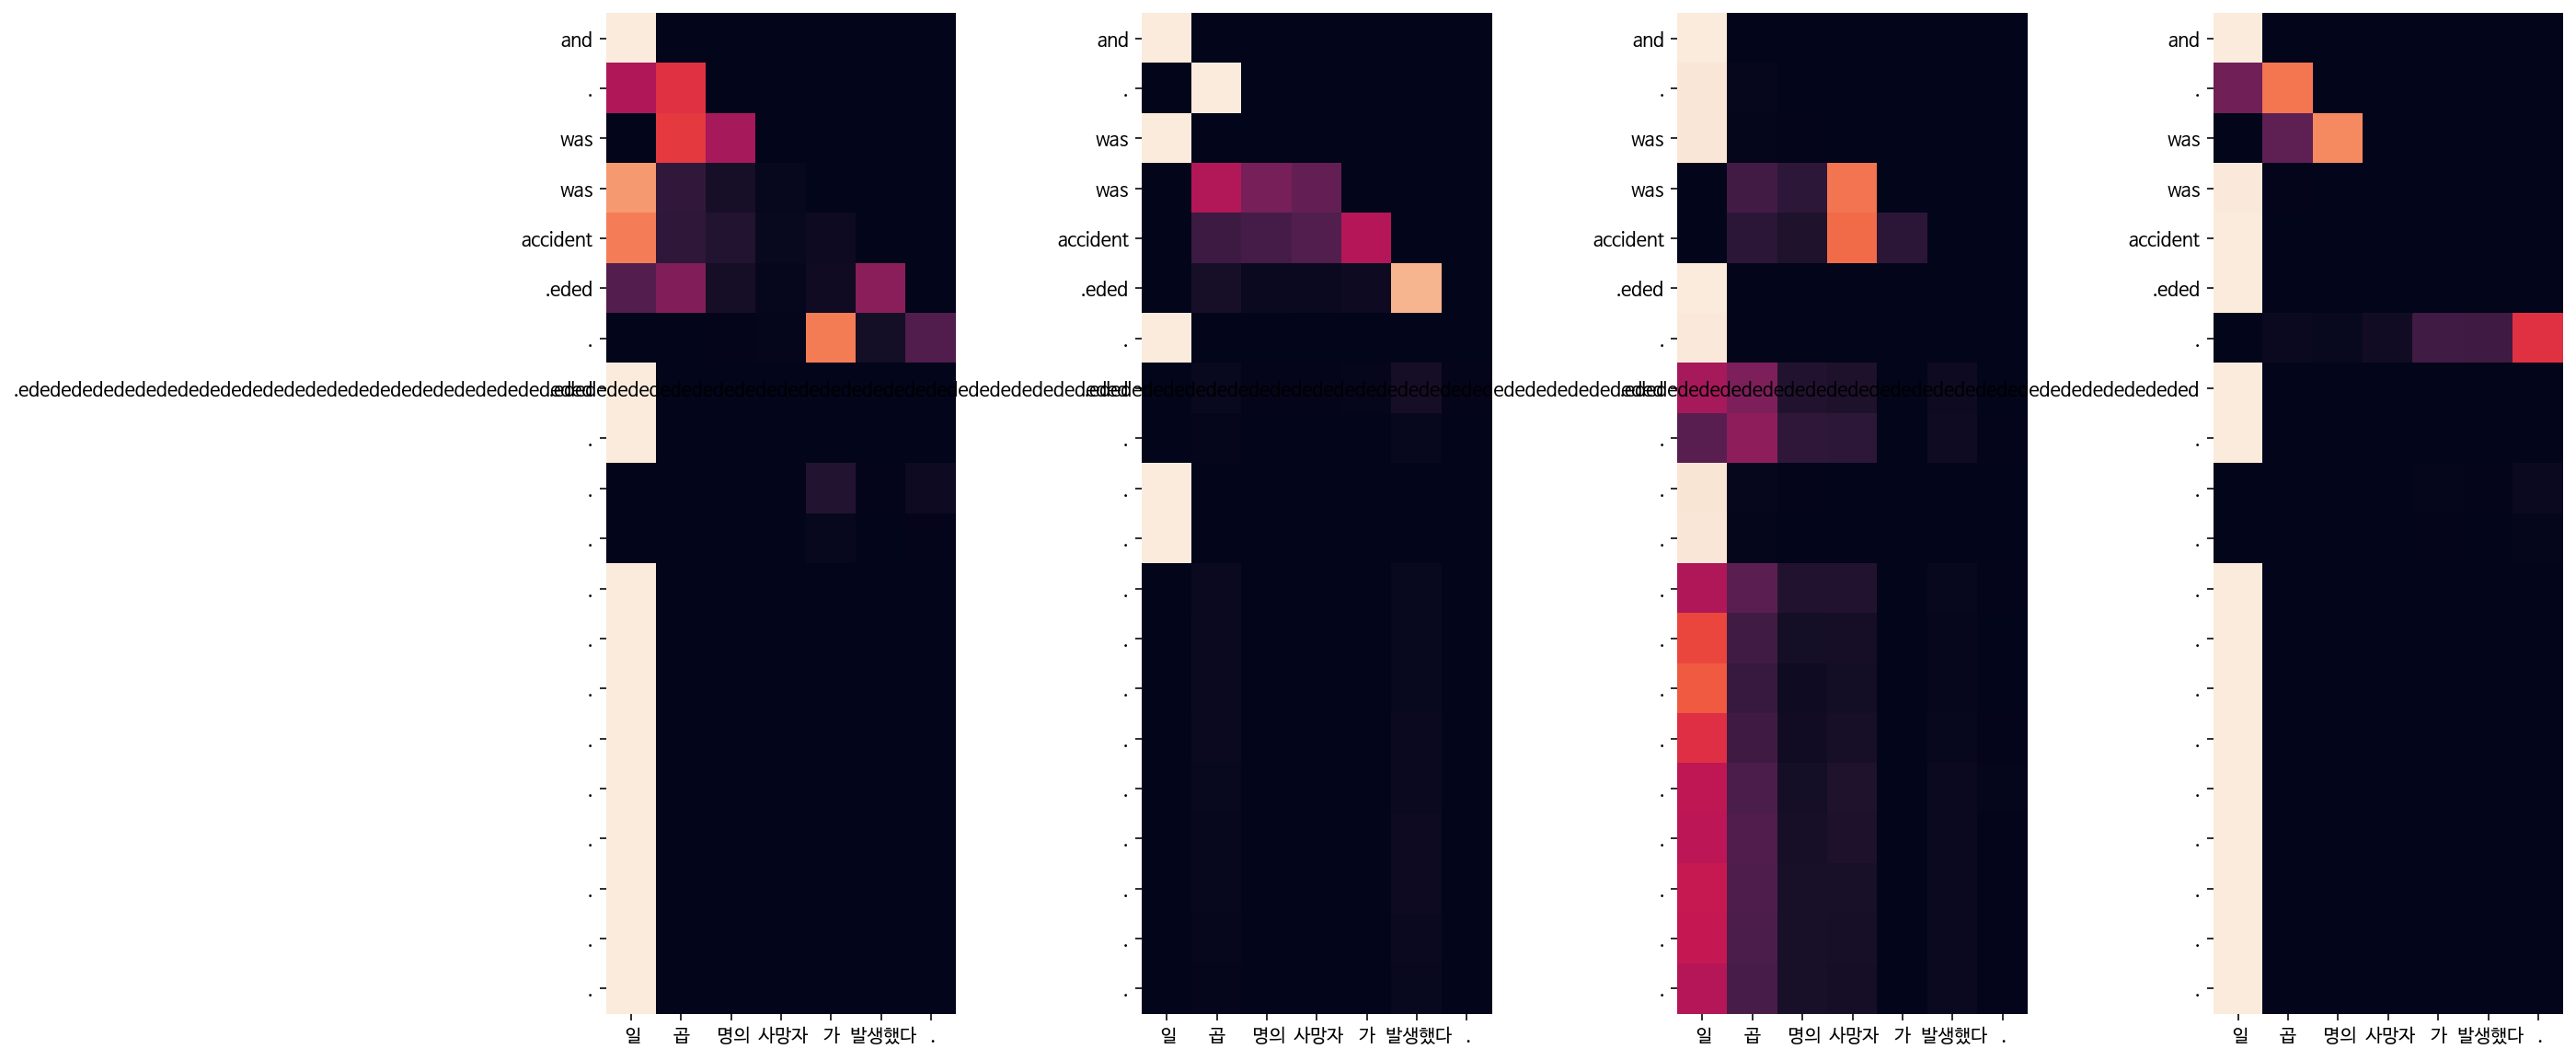

Decoder Self Layer 2


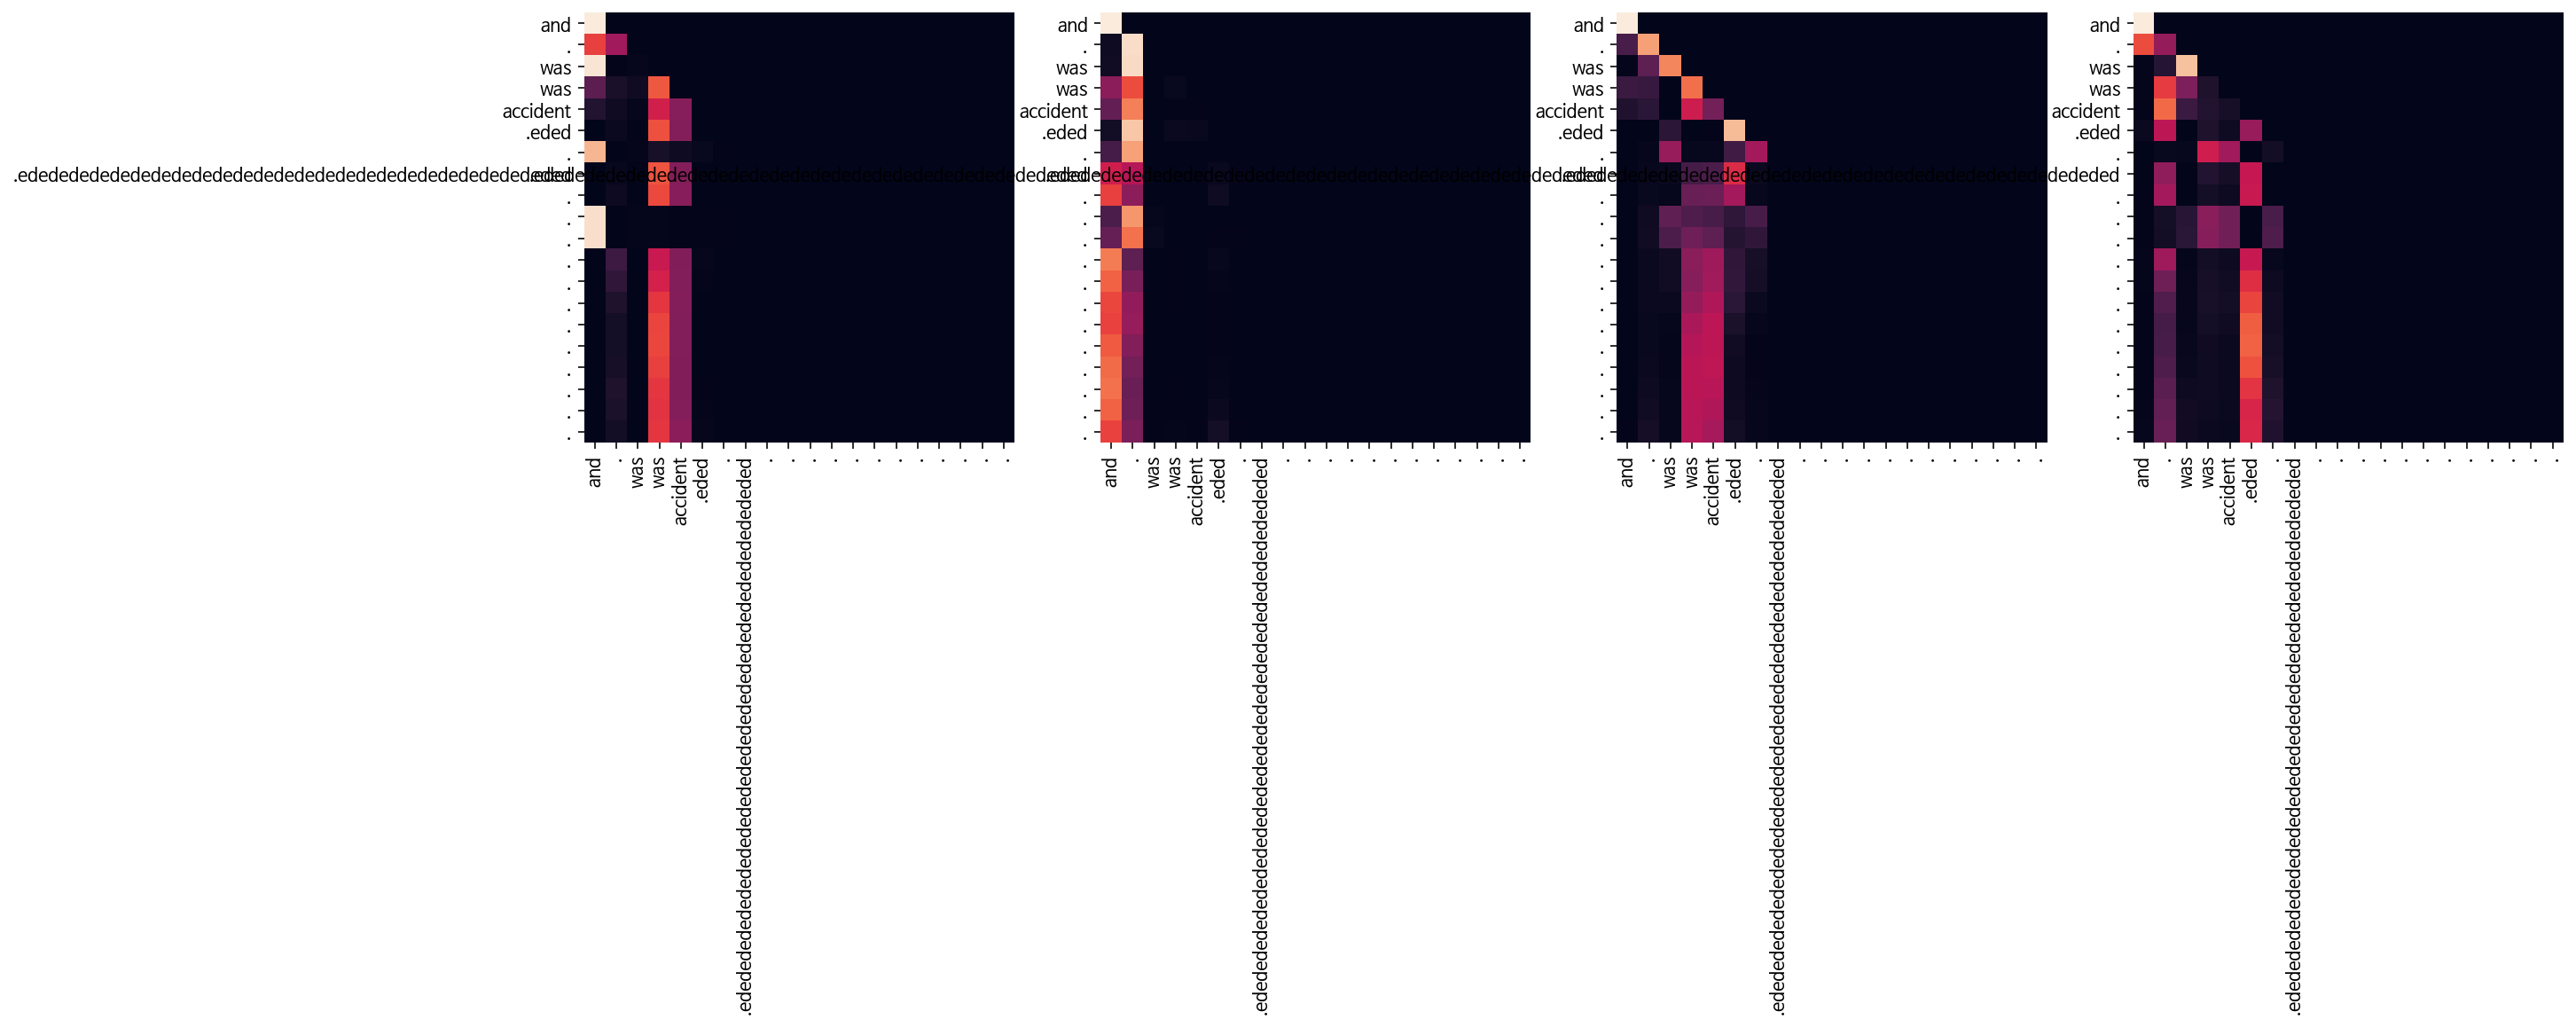

Decoder Src Layer 2


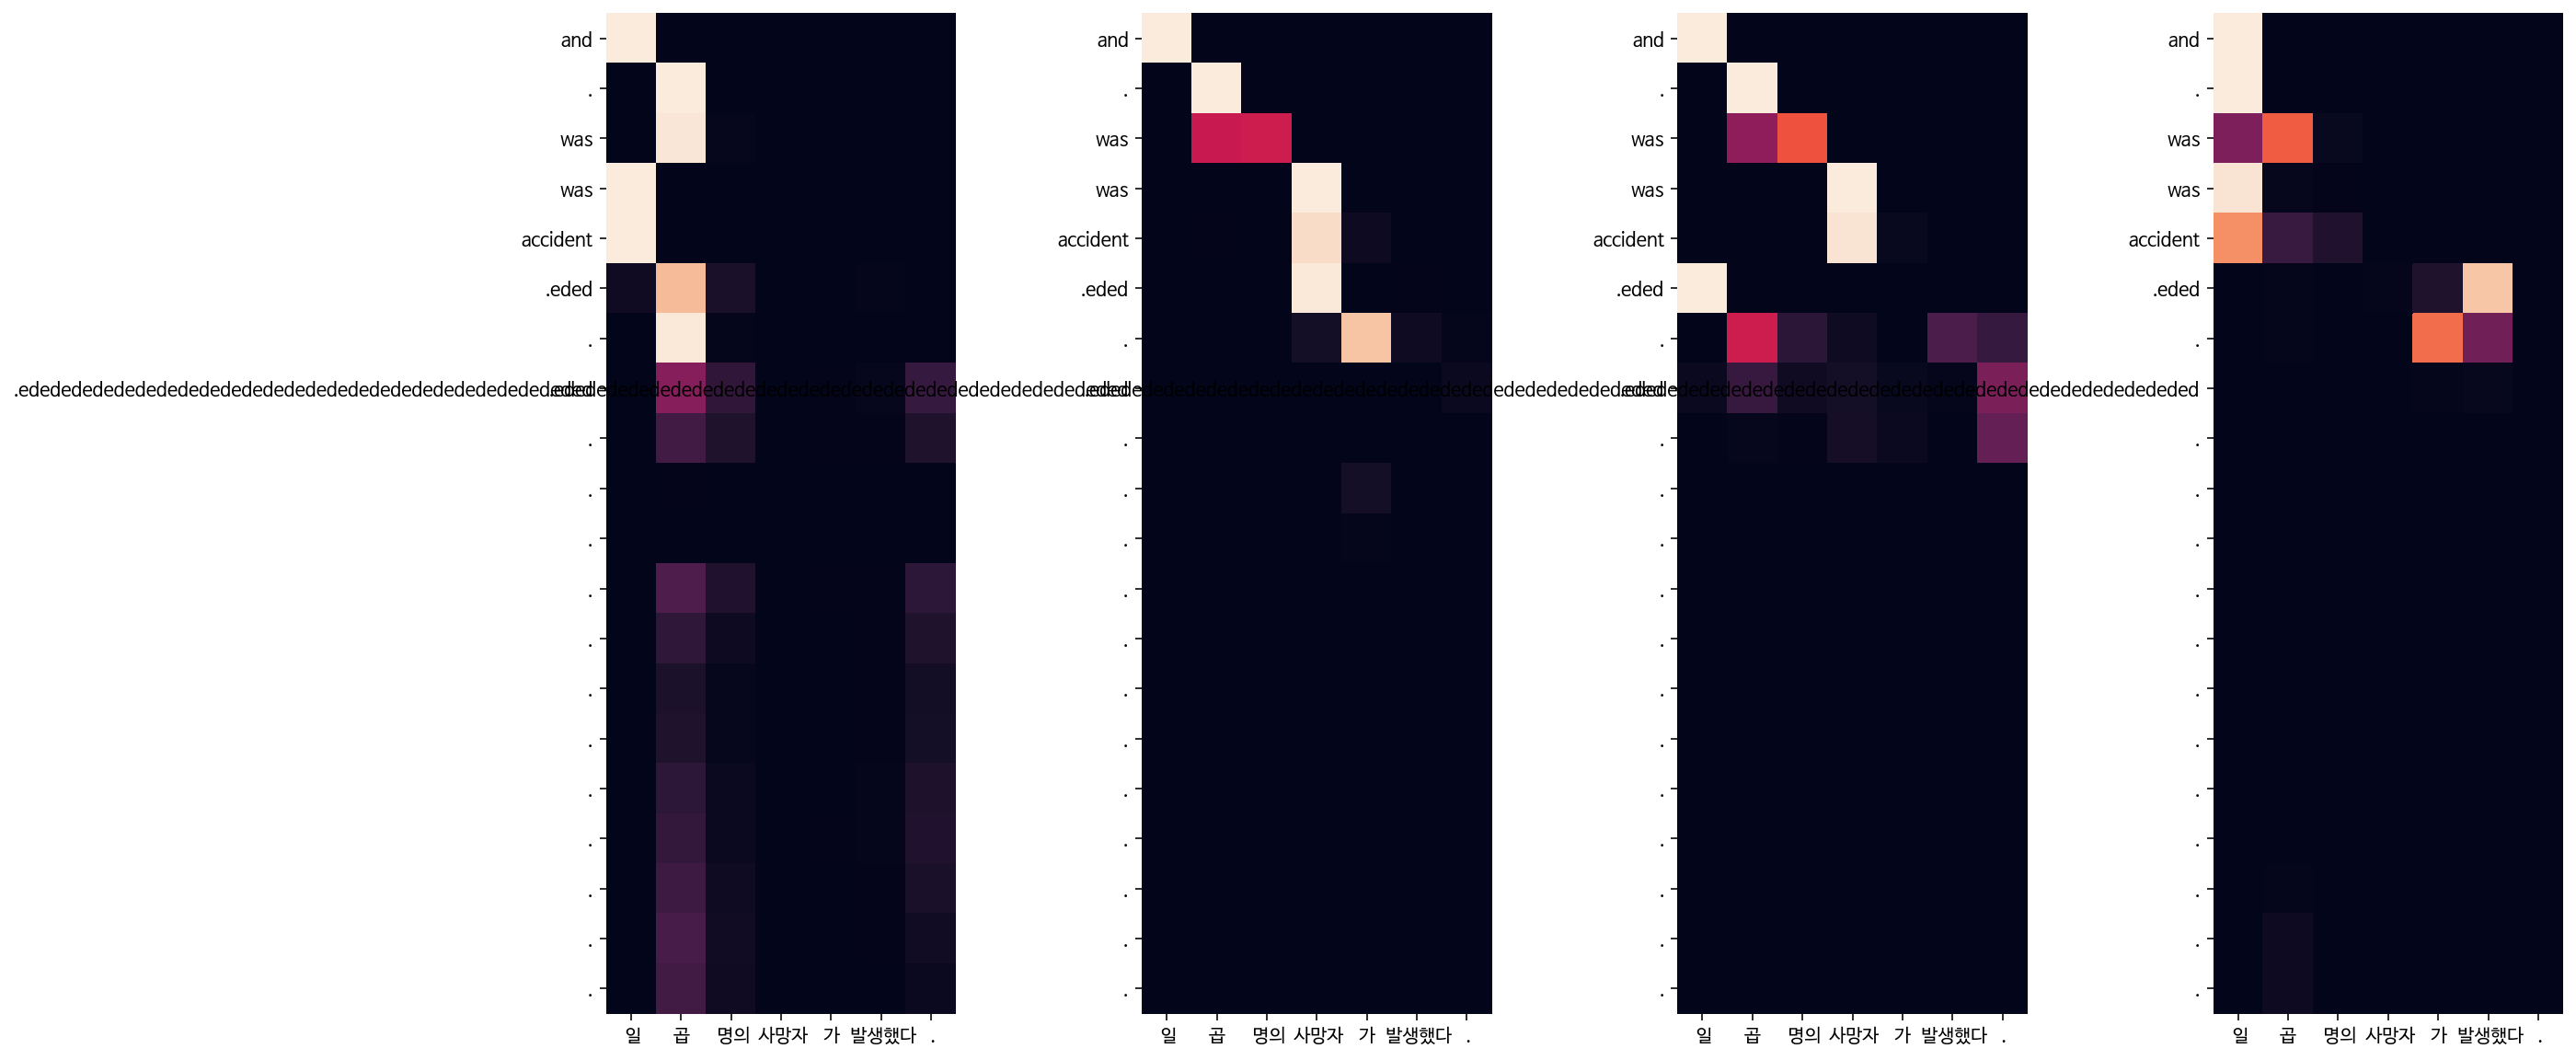

In [39]:
for example in examples:
    translate(example, model_t, ko_tokenizer, en_tokenizer,True)

## 회고 및 루브릭 평가

### 루브릭 평가 항목
1. 번역기 모델 학습에 필요한 텍스트 데이터 전처리가 잘 이루어졌다.
	(데이터 정제, SentencePiece를 활용한 토큰화 및 데이터셋 구축의 과정이 지시대로 진행되었다.)
2. Transformer 번역기 모델이 정상적으로 구동된다.
	(Transformer 모델의 학습과 추론 과정이 정상적으로 진행되어, 한-영 번역기능이 정상 동작한다.)
3. 테스트 결과 의미가 통하는 수준의 번역문이 생성되었다.
	(제시된 문장에 대한 그럴듯한 영어 번역문이 생성되며, 시각화된 Attention Map으로 결과를 뒷받침한다.)

### 평가 항목에 대한 수행
1. 데이터 정제 및 SentencePiece를 활용하여 적절한 데이터 전처리를 하였다.
2. Transformer 모델을 완성하고 정상적으로 학습과 추론과정이 진행되었다.
3. 테스트 결과 일부 의미가 통하는 수준의 번역문을 볼 수 있었다.(attention map 시각화 포함)

### 회고

노션에 공지된 꼭 포함이 되어야 할 점
- 이번 프로젝트에서 **어려웠던 점,**
- 프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점**.
- 루브릭 평가 지표를 맞추기 위해 **시도한 것들**.
- 만약에 루브릭 평가 관련 지표를 **달성 하지 못했을 때, 이유에 관한 추정**.
- **자기 다짐**

---
- **어려웠던 점**    
학습 시간이 좀 오래 걸리고 하이퍼 파라미터를 크게 주었을 때, OOM 문제로 커널이 죽어 나가서 학습하는데 어려움이 있었다. 또한 노드에서 레이어의 수를 2로 하라 해서 다른 하이퍼 파라미터를 바꿔도 성능에 크게 변화가 없어서 힘들었다. 

---
- **알아낸 점**    
SentencePiece에 여러 가지 옵션을 활용하는 것을 알 수 있었다.


- **모호한 점**    
트랜스포머 모델의 성능이 그렇게 좋지 않다는 점이 이상한 것 같다. 오히려 이전 seq2seq가 더 성능이 좋은 것 같다.(물론 모델을 심하게 제한을 했지만)

---
- **시도한 것들**   
여러 가지 하이퍼 파라미터에 대해서 실험을 하였다. 특별히 토크나이저에 옵션을 바꿔서 실험을 하였다.

---
- **루브릭 평가 관련 지표**   
제 예상에는 모두 달성되었다고 생각한다. 그 이유는 위에 있는 **평가 항목에 대한 수행**에 나와있다.  
- **자기 다짐** 및 **나의 생각들**      
트랜스포머 모델에 성능을 보기 위해서 여러 가지 하이퍼 파라미터에 대해서 실험을 하였다. 그런데 하이퍼 파라미터가 달라진다고 해서 성능이 변화되는 것은 느끼지 못했다. 아마 노드에서 가장 중요한 하이퍼 파라미터인 레이어의 수를 고정시켜서 그렇다고 생각을 한다. 원래 논문에서도 레이어의 수를 기본 6개로 하는데  왜 레이어의 수를 2로 고정해야 하는지 궁금하다. 

### 하이퍼 파라미터 실험들

In [44]:
dim_m = [128,256,512]
dim_ff = [128,256,512]
heads = [4,8,16]
for i in dim_m:
    for j in dim_ff:
        for k in heads:
            print("hyperparameters :",i,j,k)
            pipeline(i,j,k)
            

hyperparameters : 128 128 4


/home/aiffel-dj28/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:45: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama inss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: to . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: in      were . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama  to obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: to   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama  obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: but that that . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: were in   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: inss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: but it it . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: wed at  were death in . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: and the the
Input: 커피는 필요 없다.
Predicted translation: if it it it . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: at at  were death death . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama in in in . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: ss the the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: it it it it . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: at in  death death death people . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama in . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: old  the is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: if if . you you . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: at at death death death death death . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama in . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: if it .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: wed at were death death death death . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama    . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s  the is
Input: 커피는 필요 없다.
Predicted translation: i i ll . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: at at death death death death death . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama     . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: ss  the thes . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: ss . how how . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: wed at at death death death death . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: ss  the the
Input: 커피는 필요 없다.
Predicted translation: ors per per per . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: monda at at death death death death . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama    . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: ss the the the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: s you how t how . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: monda monda at death death death the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama     . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s  the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: s iflerler . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: thursday at at death death death the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama     . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: ssss the
Input: 커피는 필요 없다.
Predicted translation: ors how how how . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: monda at death death death death the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama now   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: ssss the
Input: 커피는 필요 없다.
Predicted translation: ssler or you . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: monda at death death death death death . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama    . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s ss the .
Input: 커피는 필요 없다.
Predicted translation: orslerler should . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: tuesday at at were . death the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: ss city city the
Input: 커피는 필요 없다.
Predicted translation: orslerler should . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: wed at death death death death death . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s  city city is the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: sslerler how . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: wed at death death death death death . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama now   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s s city be city city . city city . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: orslerler should . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: wed at death death death death death . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama him   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: ssss s
Input: 커피는 필요 없다.
Predicted translation: sslerler should . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: monda at death death death death death . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama him   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: ssss s
Input: 커피는 필요 없다.
Predicted translation: sslerlerler . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: monda at at death at death death . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama him    . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s nows city .
Input: 커피는 필요 없다.
Predicted translation: orslerler? . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: thursday at at death death death the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s now city city be city city . . . . . city city city city city city city city city city . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: sslerler don . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: thursday at death death death the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama him    . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: sd s is the .
Input: 커피는 필요 없다.
Predicted translation: sdlerlerler . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: weds at death death death death . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama him    . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s s city be s . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: sdlerlerler . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: thursday thursday death death at death the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama him    . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s is city city is the
Input: 커피는 필요 없다.
Predicted translation: sslerler don . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: thursday thursday death death death death death . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama him    . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s  city city is city
Input: 커피는 필요 없다.
Predicted translation: sslerler don . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: thursdays death death death death the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama him    . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: dlerlerlerlerler . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: monda at death death death death were death . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama him    . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: dlerlerlerlerler
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: monda at death death death death at . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama him    . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: sd is city . .
Input: 커피는 필요 없다.
Predicted translation: ddlerlerler
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: thursdayssd death death the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
hyperparameters : 128 128 8


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: to    . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: ss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: to to    . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: sssss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: ssssss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: sssss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sssssss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obamass
Input: 시민들은 도시 속에 산다.
Predicted translation: sssss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: ssss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: ins sss  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obamass obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: sssss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: ssss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sss in of of . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: in 
Input: 시민들은 도시 속에 산다.
Predicted translation: ssss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: ssss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: in   s were of of . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama
Input: 시민들은 도시 속에 산다.
Predicted translation: sss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: ss
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: in s in  of of . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama
Input: 시민들은 도시 속에 산다.
Predicted translation: sss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: ss
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: in      of . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obamas obama obama
Input: 시민들은 도시 속에 산다.
Predicted translation: sss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: ss
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: in in were  of of . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama
Input: 시민들은 도시 속에 산다.
Predicted translation: sss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: in in were   of of . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obamaly
Input: 시민들은 도시 속에 산다.
Predicted translation: s arely . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: that that
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: in in were in  of . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama obama
Input: 시민들은 도시 속에 산다.
Predicted translation: ins s . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: in
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: in in were in    . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama obama obama
Input: 시민들은 도시 속에 산다.
Predicted translation: in arely . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: that that
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: at in killss ly . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama obama
Input: 시민들은 도시 속에 산다.
Predicted translation: in that that .s . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: that that
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: in in were were sundaylyly . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama
Input: 시민들은 도시 속에 산다.
Predicted translation: in that that . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: that that
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: in kills kill killsly . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: in thatly . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: in
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: at kill kill kill kill killssss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama obama obama obama
Input: 시민들은 도시 속에 산다.
Predicted translation: in that s . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: that that
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: in in were were kill deaths . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obamaly
Input: 시민들은 도시 속에 산다.
Predicted translation: in that s . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: that that
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: in kills kills killss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama obama obama
Input: 시민들은 도시 속에 산다.
Predicted translation: that that at . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: that that
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: at in were were dead dead  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama
Input: 시민들은 도시 속에 산다.
Predicted translation: that that  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: that that
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: in in were were were deadly . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obamaly president president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: in that  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: that that
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: in in were were death  of . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obamalyly
Input: 시민들은 도시 속에 산다.
Predicted translation: in thats . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: that that
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: in in were were dead deadly . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obamalyly
Input: 시민들은 도시 속에 산다.
Predicted translation: that that to . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: that that
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: at that kill kill kill killsssssss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama obama obama obama
Input: 시민들은 도시 속에 산다.
Predicted translation: that that to .s . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: that that
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: at in were kill death dead  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obamaly
Input: 시민들은 도시 속에 산다.
Predicted translation: that that at . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: that that
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: at in were  death and of . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obamalyly
Input: 시민들은 도시 속에 산다.
Predicted translation: that that were . to . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: that that
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: in kill kill death kill kills . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obamalylyly
Input: 시민들은 도시 속에 산다.
Predicted translation: that that  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: that that
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: at that death death death death be . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obamalylyly
Input: 시민들은 도시 속에 산다.
Predicted translation: in that  . . . of . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: that that
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: at that death death death death  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obamaly president
Input: 시민들은 도시 속에 산다.
Predicted translation: that that  . . . of . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: that that
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: in in kill kill kill killlysss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obamalylyly . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: in that  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: that that
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: in in kill kill kill killlyssss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama presidently president
Input: 시민들은 도시 속에 산다.
Predicted translation: that to  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: that that
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: in in kill kill kill killlys . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
hyperparameters : 128 128 16


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: thes . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: i said . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the s .ss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: ings . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: i  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: cnn  . . .s . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: ings .ss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: ?  .  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: .   .s . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: ings . .s . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: but . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: . s .s . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: thes . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: but . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: s . .s . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: thes . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: but . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: .ss was . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: thes . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: but . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: . sssly . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: thes . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: but  . does you you . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: . s s of . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: thes .s . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: but not .s . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: . sss dead were . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: thes .s . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: don  . you you you you you . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: . ss dead were of . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: thes  the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: don  to you you you . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: . ss dead died . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: thes . the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: to  you to coffee you you you . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: .s dead died dead died . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: thes . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: don to coffee coffee . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: .s  dieds died . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: thes  the . . is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: don to coffee coffee coffee coffee . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: . s dead was dead in . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: thes the . . . is is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: don to coffee coffee coffee coffee . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: .  wass dead died . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: thes to .s . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: to to coffee coffee coffee coffee coffee coffee . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a  dead dead dead dead was . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: thes to . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: to to coffee coffee coffee coffee coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a   death death death . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: thes to . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: to to coffee coffee coffee coffee coffee coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a s died death died . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: thes to  the . . . . .
Input: 커피는 필요 없다.
Predicted translation: to to  to coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee you you you you you you you you you you you
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a   death death of . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama to . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: thes to  the . is is . .
Input: 커피는 필요 없다.
Predicted translation: don to  to coffee coffee coffee coffee coffee coffee coffee coffee coffee you you you you you you you you you . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a   death death was of . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama to . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: thes to . 
Input: 커피는 필요 없다.
Predicted translation: don to coffee coffee coffee coffee coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a  died was  to . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama to . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: thes to . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: don to to coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: s  was bes dead . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama to to . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the the is . to . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: don to coffee coffee coffee coffee coffee . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: s  was bes dead of . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama to . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the the is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: don to to coffee coffee coffee coffee coffee coffee coffee coffee . . . coffee coffee . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: s  was bes to . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama to to to . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the the to  the . is is is
Input: 커피는 필요 없다.
Predicted translation: don to to coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a  was died and died . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama to . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the the to is . . . .
Input: 커피는 필요 없다.
Predicted translation: don to to coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: more dead dead was died to . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama to to . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the the to is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: to to coffee coffee coffeelllllllllllllllllllllll
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: more  dead was bes of . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama to . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the to to  to . dynast dynast
Input: 커피는 필요 없다.
Predicted translation: to to you to you you yousonsonsonsonsonsonsonsonsonsonsonsonsonsonsonsonsonsonsonsonsonsonsonsonsonsonsonsonsonsonsonsonsonsonsonsonsonsonfordfordfordford
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a  was be was to . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama to . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the the is to . . . iss
Input: 커피는 필요 없다.
Predicted translation: to to to coffeelllllllllllllllllllllllllllllllllllllllllllll
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a was  died to  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama to . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the to to  to .ss
Input: 커피는 필요 없다.
Predicted translation: don to to coffee coffeellllllllllllllllllllll . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven was  to to to . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
hyperparameters : 128 256 4


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the the  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the  to   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: but
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: in  inginginging . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the   ss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: we to to  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the     in  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: ing sss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: i not to to . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: inging sss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: ing sss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: inging kills kill kill . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: inging s . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: ing  ins s . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: inging  s . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: to you you you . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: s  kill in in in . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: ing s in . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: not you you you . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: s  kills in in . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s the  . .s . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: not it you you . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: s  kills kills in . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: areing ings . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: if can you you you . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: s the the the kill near . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the is  in . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: if is you you . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: in  thes the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the s   .s . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: if if you you t . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: in  thes kills . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the  is in . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: if will you you good . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: in  thes were at . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the the  s . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: if will you you you . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: in  thes t were . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the the   is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: if you you you t . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: in  thes the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the the city city city is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: if t you you t . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: in  polices t t were . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the  poor poor is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: if you you you you you . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: in  at s at were . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the the red city city is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: if will you you you . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: weres polices t t at . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the the red city is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: don t t t t . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: in  thes t t . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the the red city . is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: don t t t t . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: in the the the  death . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the the red city city is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: if you you you t . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: weres polices t militant were . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the the city city is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: if you you you t . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: weres polices t were at . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the the city city is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: do t you you t . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: weres police t t t were . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the  streets  is in . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: don you you you t . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: in  seven seven t seven seven . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the the city city is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: do you you you you t . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: in  thes t the were . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the the city city is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: if you you you you . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: in  thes the death . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city city city is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: do you you you you . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: in  ss at were . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city city city is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: do you you you you . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: in  sevens t seven were . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama s . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city city city is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: do you you you you . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: in  thes police t were were . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city streets  is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: do you you you you . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: weres t t t t . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the the city city is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: do you you you you . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: in  thes t death . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
hyperparameters : 128 256 8


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: yyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy .
Input: 시민들은 도시 속에 산다.
Predicted translation: yyyyyyyyyyyyyyyyyiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesies .
Input: 커피는 필요 없다.
Predicted translation: yyyyyyyyyyyyyyyyyyyyyyyyyyyyyyiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesies .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: yyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obamayyyyyyyyyyyyyyyyyyyyyyyyyyyiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesies .
Input: 시민들은 도시 속에 산다.
Predicted translation: yyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy .
Input: 커피는 필요 없다.
Predicted translation: yyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: yyyyyyyyyyyyyyyiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesies .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obamayyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy .
Input: 시민들은 도시 속에 산다.
Predicted translation: yyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy .
Input: 커피는 필요 없다.
Predicted translation: yyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: yyyyyiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesies .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: yyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy .
Input: 시민들은 도시 속에 산다.
Predicted translation: yyyydddddddddddyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy .
Input: 커피는 필요 없다.
Predicted translation: yyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: ydyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: yyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy .
Input: 시민들은 도시 속에 산다.
Predicted translation: yyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy .
Input: 커피는 필요 없다.
Predicted translation: yyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: yyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: yyyyddddddddyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy .
Input: 시민들은 도시 속에 산다.
Predicted translation: yyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy .
Input: 커피는 필요 없다.
Predicted translation: yyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: yyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: yyyydddyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy .
Input: 시민들은 도시 속에 산다.
Predicted translation: yyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy .
Input: 커피는 필요 없다.
Predicted translation: yyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: yyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: yyyyddddddyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy .
Input: 시민들은 도시 속에 산다.
Predicted translation: yyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy .
Input: 커피는 필요 없다.
Predicted translation: yyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: yyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: yyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: yyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy .
Input: 커피는 필요 없다.
Predicted translation: yyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: yyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: yyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy .
Input: 시민들은 도시 속에 산다.
Predicted translation: yyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy .
Input: 커피는 필요 없다.
Predicted translation: yyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: yyyyyyenyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: yyyyddddddyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: iesyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy .
Input: 커피는 필요 없다.
Predicted translation: yyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: yyyyyyenyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: yyyyyddyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: iesyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy .
Input: 커피는 필요 없다.
Predicted translation: yyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: yyyyyyenenenyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: yyyydddddy . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: yyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy .
Input: 커피는 필요 없다.
Predicted translation: yyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: yyyyyyenedyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: yyyydddenenenenenenenenenenenenenenenenenenenen . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: iesyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy .
Input: 커피는 필요 없다.
Predicted translation: yyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: yyyyyenedededededededededededededededededededededededededededededededededededed . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obamayyyyyyyyyyyyyyyyyyyyyyyyyyyy . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: iesyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy .
Input: 커피는 필요 없다.
Predicted translation: yyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyenenenenen
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: yyyyyedededededededededededededededededededededededededededededededed . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obamayyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyen . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: iesyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy .
Input: 커피는 필요 없다.
Predicted translation: yyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyenenenenenenenenenenenenenenen
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: edyyyyedenededededededededededededededyyyyyyyyedededyyyyyyyy . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obamayyyyyyyyyyyyyyyyyyyyyyy . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: iesyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyies .
Input: 커피는 필요 없다.
Predicted translation: yyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyenenenenenenenenenenenenenenenen
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: yyyyedyedededededededtttttttttttttttttttttttttttttttttttt .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obamayyyddddenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenen . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: iesyyyyyyyyyyyyyyyyyyyyyyenenenenenenenenenenenenenenenenenenenenenenenenenen .
Input: 커피는 필요 없다.
Predicted translation: yyyyenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenen
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: yyyedyedenenenenenenenenenenenenenenenenenenenenenenenenttttttttttttttttttt .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obamayyyyenyyyededenenenenenenenenenenenenenenenenenenenenenenenenenenenen . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: iesyyyyyyyyyyyyyyyyyyy up up up up up up up up up up up up up up up up up up up up up up up up up up up up up .
Input: 커피는 필요 없다.
Predicted translation: yyyyenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenen
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: edtyyyed injuredededededededyyededededededededededededededededededededededtttt . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obamayyydedededededededededededededededededededenenenenenenenenenenenenenen . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: iesyyyyyeeenedededed up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up .
Input: 커피는 필요 없다.
Predicted translation: yyyyenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenen
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: edyyedyedededededededededededededededededededededededededededededededededed . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obamayyyyedededededededededenenenenenenenenenenenenenenenenenenenenenenenen . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: iesyyyyyeenenen up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up .
Input: 커피는 필요 없다.
Predicted translation: yyyyeenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenen
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: edtyyyedededededededededededededededededededededededededededededededededed . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obamayyyyenenenenenen . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: iesyyyyyeeee up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up .
Input: 커피는 필요 없다.
Predicted translation: yyyyenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenen
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: edtyedyyedededededededededededededededededededededededededed up up up . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obamayyyedenenenenenenenenenenen . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: ieslyyyyy up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up .
Input: 커피는 필요 없다.
Predicted translation: yyyyeenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenen
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: edyedyedyionionionionionionionededededededededededed at at at at at at at at at at at at at at . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obamayyyenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenen . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: ieslyyyyye up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up .
Input: 커피는 필요 없다.
Predicted translation: yyyeenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenen
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: edyedyyeden up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obamayyyededenen . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: ieslyyy upyyyyyyyyyyyyyyyyyyyyyyyyyyedededededededededededededededededed .
Input: 커피는 필요 없다.
Predicted translation: yyyeenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenen
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: edyedyyed injur up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obamayyyedenenenen . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: ieslyyy upyyyyyyyyyyyededediesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesies .
Input: 커피는 필요 없다.
Predicted translation: yyyeenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenen
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: ededyyyedionionionionionionionion up up up up up up up up up up up up up up up up up up up up up up up up up up up up . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obamayy obamayyy . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: ieslyy upyyyyyyyyededededededededededededededededededededededededededededededededededededed .
Input: 커피는 필요 없다.
Predicted translation: yyyeerer up up up up up up up up up up up up up up up up up up up up up up up up up up upenenenenenenenenenenenenenenenen
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: ededyyyed injur injur injur injur injur injur injur up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obamayy obamayyyyy . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: ieslyy upedyyyyyyyyiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesies .
Input: 커피는 필요 없다.
Predicted translation: yyyye up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: edyyedyed injur injur injur injur injur injur injur up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obamayy obamaedyyed . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: iesly up up upyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy .
Input: 커피는 필요 없다.
Predicted translation: yyyye up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: ededy upyediesiesiesiesiesiesiesiesiesiesiesedededededededededededededediesiesiesededededededededededededededed .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obamay obama obamayyyy . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: iesly up up upyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyttttttt .
Input: 커피는 필요 없다.
Predicted translation: yyyeeren up up up up up up up up up up up up up up up up up up up up up up up up up up upenenenenenenenenenenenenenenenen
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: ededyedyyionionion at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at . . . . . .
hyperparameters : 128 256 16


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: to to
Input: 시민들은 도시 속에 산다.
Predicted translation: .s   to to to . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: ed to to to to to to to to . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: s    to the to to to . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: . . .    . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: . .   to t t t t . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: .enenen in in in . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: barack barack barack barack barack barack
Input: 시민들은 도시 속에 산다.
Predicted translation: . . .    . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: . . .     . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: .enen  in     . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: . mccain mccain mccain mccain
Input: 시민들은 도시 속에 산다.
Predicted translation: . . . and . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: . . .  i . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: . . .          said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: . . . mccain
Input: 시민들은 도시 속에 산다.
Predicted translation: . . .   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: . . .    . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: . . sunday    a  in in in in in in in in in in in in in in in in in in in in in in in in said said said said said said said said said said said said said said said said said .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: . .
Input: 시민들은 도시 속에 산다.
Predicted translation: . .
Input: 커피는 필요 없다.
Predicted translation: . . .   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: . .       said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: . .
Input: 커피는 필요 없다.
Predicted translation: . . .  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sunday sunday sunday sunday sunday a a a a a . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: . .
Input: 커피는 필요 없다.
Predicted translation: . . .  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: . . sunday       said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: . .
Input: 커피는 필요 없다.
Predicted translation: . . .  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sunday sunday wed wed of     said said said said said said . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama
Input: 시민들은 도시 속에 산다.
Predicted translation: . .
Input: 커피는 필요 없다.
Predicted translation: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sunday sunday sunday sunday a a a a  


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: . .
Input: 커피는 필요 없다.
Predicted translation: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sunday sunday wed wed of a a 


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: . .
Input: 커피는 필요 없다.
Predicted translation: . . . to . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: . . of  a a people  s s . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama . obama obama
Input: 시민들은 도시 속에 산다.
Predicted translation: . . . christmas . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: . .   a a a . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama . obama obama
Input: 시민들은 도시 속에 산다.
Predicted translation: . .
Input: 커피는 필요 없다.
Predicted translation: . . . to . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sunday . of  of      


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama . obama obama
Input: 시민들은 도시 속에 산다.
Predicted translation: . .
Input: 커피는 필요 없다.
Predicted translation: . . . to . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sunday .  people a a a


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama . obama obama to
Input: 시민들은 도시 속에 산다.
Predicted translation: . . . american . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: . . . to . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sunday . a wed wed a died died died died died said said said . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama . obama obama
Input: 시민들은 도시 속에 산다.
Predicted translation: . . . people  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: . . . don . to . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sunday .   a a a


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama . obama to
Input: 시민들은 도시 속에 산다.
Predicted translation: . . . american american .
Input: 커피는 필요 없다.
Predicted translation: . . . don . to . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: . .  of a a people people . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama . obama obama to
Input: 시민들은 도시 속에 산다.
Predicted translation: . . . american shop shop
Input: 커피는 필요 없다.
Predicted translation: . . . don . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: . .   a a park park . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama . obama obama to
Input: 시민들은 도시 속에 산다.
Predicted translation: . . . american shop shop
Input: 커피는 필요 없다.
Predicted translation: . . don want to to to to . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sunday . of of a a a die


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama to
Input: 시민들은 도시 속에 산다.
Predicted translation: . . . states man shop . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: y visa than to . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: monda . of  people a a


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama . obama obama to to to to
Input: 시민들은 도시 속에 산다.
Predicted translation: . . . states man shop
Input: 커피는 필요 없다.
Predicted translation: . . . don . to . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sunday a a of of a park


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama . obama obama to to
Input: 시민들은 도시 속에 산다.
Predicted translation: . . . states man urban . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: . . want don to to . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sunday of of  of a the


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama . .
Input: 시민들은 도시 속에 산다.
Predicted translation: . . . american american shop
Input: 커피는 필요 없다.
Predicted translation: y . want we to . . to to to to . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sunday of of  saturday   saturday saturday saturday saturday saturday saturday saturday saturday saturday                        . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama . obama barack
Input: 시민들은 도시 속에 산다.
Predicted translation: . to
Input: 커피는 필요 없다.
Predicted translation: y . want we to . to to to to to . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sunday a of of of a park


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama . obama obama to to to to to to
Input: 시민들은 도시 속에 산다.
Predicted translation: . to
Input: 커피는 필요 없다.
Predicted translation: y . to we to to to to to to . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: monda  of monda monda two  saturday saturday monda monda . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama . obama obama to to to
Input: 시민들은 도시 속에 산다.
Predicted translation: . to shop shop shop shop . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: y visa . we to to to to to to . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sunday sunday a wed wed of a


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama . obama obama to to to
Input: 시민들은 도시 속에 산다.
Predicted translation: . to
Input: 커피는 필요 없다.
Predicted translation: y . want we to . to to to to to to . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: monda monda  people people a saturday saturday saturday saturday saturday saturday saturday saturday saturday saturday saturday wed wed wed wed wed wed wed wed wed wed wed wed wed wed wed wed wed wed wed wed wed wed wed wed wed wed . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama . obama
Input: 시민들은 도시 속에 산다.
Predicted translation: . to shop shop shop shop . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: y . want we to . . . to to . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: monda monda saturday of saturday  s


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama . obama obama to to to to to to to
Input: 시민들은 도시 속에 산다.
Predicted translation: . to shop shop shop shop . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: y . want want . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sunday sunday of of of a park saturday saturday saturday saturday saturday saturday wed wed wed wed wed wed wed wed wed wed wed wed wed wed wed wed wed . . . . . . . . . . . . . . . . . . .
hyperparameters : 128 512 4


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: was wased . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: ededseded . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: is is  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: edededededs . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama     . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: eded . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: eded      . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama barack clinton   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: enly . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: ly  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: eded     . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama mccain   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: iesly . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: enly      . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama barack  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: iesly . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: you . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: aly     . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama  the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: ily . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: you you . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: uly     . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: ily . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: say you . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: u      . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: eyly . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: your you you . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: uly     . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: ily . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: your you you . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: uly  report  the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: eyly . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: say you you you . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: uly   the report . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: eyly . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: your you you you . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: anly  report the report . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: laly . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: your you you you you . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: bly  report the the report report . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: es is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: your you you you you . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: tly report the report the report report report report . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: eyly . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: your you you you you . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: ministrlyly the the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: ey is . . . . . .
Input: 커피는 필요 없다.
Predicted translation: your you you you you . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: ministrlyly the the the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: ey is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: your you you you you you . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: ministrly of the the the the report report . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: ey is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: you you you you you you . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: ministrly of the the the the death death . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: ey is . . . . . .
Input: 커피는 필요 없다.
Predicted translation: your you you you you you . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: ministrlyly the the the the death report reported . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: palace is in . .
Input: 커피는 필요 없다.
Predicted translation: your you you you you you . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: ministrly of the the the the the people . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: y is . . .
Input: 커피는 필요 없다.
Predicted translation: your you you you you you you . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: ministrly of the the the death death death death . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: y is . . .
Input: 커피는 필요 없다.
Predicted translation: your you you you you you you . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: ministrly of the the the death death death . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: snowly . . .
Input: 커피는 필요 없다.
Predicted translation: your you you you you you you . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: ministrly of the the the the the reported . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: cloudr . . .
Input: 커피는 필요 없다.
Predicted translation: how you you you you you you you . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: saidly of the the the the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: yes . . .
Input: 커피는 필요 없다.
Predicted translation: how you you you you you you you . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: ministrly of the the the death death death death . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: cloud is . . .
Input: 커피는 필요 없다.
Predicted translation: you you you you you you you you you . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: ministrly of the the the people people people reported reported reported reported reported reported reported reported reported reported reported reported reported reported reported reported reported reported . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: cloud . . . .
Input: 커피는 필요 없다.
Predicted translation: you you you you you you you you you . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: saidly of the the the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: cloudr . . .
Input: 커피는 필요 없다.
Predicted translation: your you you you you you you you . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: ministrly of the the the people people people reported . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: cloudr . . .
Input: 커피는 필요 없다.
Predicted translation: you you you you you you you you you you you . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: ministrly of the the the people people kill reported reported . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama the obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: cloudr . . .
Input: 커피는 필요 없다.
Predicted translation: your you you you you you you you you you . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: ministrly of the the the people people people people . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: cloud cloud . . .
Input: 커피는 필요 없다.
Predicted translation: your you you you you you you you you you . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: ministrly of the the the people people people people . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
hyperparameters : 128 512 8


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: 
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: .sssssssss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: i  said said . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: . in inss in . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama    . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: . .ss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: . . .    . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama    . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: . s . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama    . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama     . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: .  said said . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama    . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: . .  said . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama    . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: .  said said . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama     . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: .  said said . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama  obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: .  said said . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: . . . was in  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: .  said said . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: .  said  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: .  said  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: . . . was dead dead . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: .  said said . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: . . dead dead dead . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: . said did . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: . . dead dead reported . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: .  said did . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: . . dead died dead dead . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: . said would special . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: . dead reported reported reported reported reported reported . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: . said did if . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: . dead said died dead dead . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: .  said did . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: . dead injur injur reported . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: . said would . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: . dead dead said kill death . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: . said would . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: . dead dead said kill . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: . said would if . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: . dead said injur kill s . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: . said would would . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: . dead said kill died dead . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: . said would would if . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: . dead said kill died dead . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: . said would would if . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: dead dead said died dead dead . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: . said would s if . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: dead dead said died dead dead . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: . said would would if . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: . injur said fatalit reported reported . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: . said would if . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: dead dead said kill kill kill . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama barack obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: . said would would if . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: . fatalit said kill was fatalit . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: . said would would if . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: . saidaba died in in . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
hyperparameters : 128 512 16


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: ssssedededededededededededededededededededededededededededededingingingingingyyyyyyyyyyyy
Input: 시민들은 도시 속에 산다.
Predicted translation: sssssedededededededededededededededededededededededededededededededededededededededededededed .
Input: 커피는 필요 없다.
Predicted translation: sssyedededededededededededededededededededededededededededededededededed . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: ssssededededededededededededededededededededededed . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: ssedinginginginginginging . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: ssinginginginginginginging . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: singinginging . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: singingedinginginginging . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: sssinginging . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: singinginginginginginginginging . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: singinginging . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: singingededinginginginging . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: ssinginging . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: singinginginginging . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sing .edinging . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: clintoningingsing . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: singinginginginging . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sing .sed . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: clintonsinging . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: singinginginging . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sing .inginging . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: clintoningings . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: singsinginging . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: .ing .sing . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obamainging . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: singinginging . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: .ing .ing  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obamasing . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: singsinging . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: .s .inged . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obamaing . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: singinginging . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: .ing .sed . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obamaingy . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: singingingy
Input: 커피는 필요 없다.
Predicted translation: 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: .ing .y was . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obamaingy . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: sings the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: .s . of  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obamaingy . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: singingingy
Input: 커피는 필요 없다.
Predicted translation: 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: .ingss   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obamaingy . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: sss the the . . . . .
Input: 커피는 필요 없다.
Predicted translation: 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: .s . of  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obamaingy . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: singing the the
Input: 커피는 필요 없다.
Predicted translation: 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: .sing of   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obamaingy . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: singing the the
Input: 커피는 필요 없다.
Predicted translation: butingss or or . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: .s . of of . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obamaingy . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: sy ofy the
Input: 커피는 필요 없다.
Predicted translation: syt . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: .s of of   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obamayed  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: singy the the
Input: 커피는 필요 없다.
Predicted translation: 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: deathsingsedy . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obamaingy . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: singy the
Input: 커피는 필요 없다.
Predicted translation: 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: deathsingsedy . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obamaingyy  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: siesy
Input: 커피는 필요 없다.
Predicted translation: 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: .inging of   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: clintonyyed . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: syy
Input: 커피는 필요 없다.
Predicted translation: 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: deathsingingsy . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obamaingy . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: sy ofy
Input: 커피는 필요 없다.
Predicted translation: 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: .s of of of  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obamaingy . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: syy
Input: 커피는 필요 없다.
Predicted translation: 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: deathingingedyyy . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: clintonyy . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: siesyy
Input: 커피는 필요 없다.
Predicted translation: 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: .s . of . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obamaingy . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: singyed
Input: 커피는 필요 없다.
Predicted translation: .ingsa .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: .inging of y . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obamaingy . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: .s . of of of . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama clinton clinton . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: siesy ofy
Input: 커피는 필요 없다.
Predicted translation: butsta .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: .s . of of of . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obamaing  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: syy ofy
Input: 커피는 필요 없다.
Predicted translation: cupiesiesa .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: .inging ofingy . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obamaing  .ed . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: singyedy
Input: 커피는 필요 없다.
Predicted translation: cupss
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: .s . of . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obamaing  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: siesy .
Input: 커피는 필요 없다.
Predicted translation: cupssa .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: deathinginging yy . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
hyperparameters : 256 128 4


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obamassssssssssssssssssssssssssssssssssssssssssssssss .
Input: 시민들은 도시 속에 산다.
Predicted translation: sssssssededededededededededededededededededededededededededededed . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: .sss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: ededededededsssssssssssssssssssssssssss . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: sssssssssssssssssss . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: sssedssededededededededed . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: .ss the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sssededsssssssssss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: sssedsssssssss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: ssedssedsssssssssssssssssssssssssssss . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: .s the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: ssedsedssssssssssssssssssssssssss . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: sss saidssssss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: ssedsss .ededededededed . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: . the the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: .sedsss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: sn  said said said said . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: sededsrs .ssssssssssssssssssssssssssssss . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: is . the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: .ededs dieds . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama saidsssssss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: ssedsss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: . the the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: .sedssed . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president president president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: . the the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: .ededs kill death . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: . the the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: onsss kill kill . .edededed . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the president president president president
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: . the the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: ons  death deathnnsedededs . . . . . . . . . . . .ssssssssssssss . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the president
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: the the and the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: ons saturdaysrrrededededededededededededededededededed . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the the . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: . the the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: ons sunday kill kill killssedededededededededededededededededed . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: . the the the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: ons sunday kill kill killsssssssssssssssssssssssssssssssssssssssssss .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president president the  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: in ins live  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: . the there there . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: ons sunday kill kill kill death  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: in thess  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: . the the there no . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: ons saturday saturdayeds . . . . . . . . . . . . . . .ssssssssssssssssssssssssssss .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: in ins . live
Input: 커피는 필요 없다.
Predicted translation: . there the no the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: ons saturday saturdayededsssssssssssssssssssssssssssssssssssssssssss .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: in ins .  the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: . the there no need . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on    kill death deathlylylylylyly . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: in in as . .
Input: 커피는 필요 없다.
Predicted translation: . the the there need  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on  sunday kill kill death death   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: in the the .  the where . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: . there there no need . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on  sunday kill  kill death    . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: in in as . .
Input: 커피는 필요 없다.
Predicted translation: . there there no no . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on  saturday saturday saturday death saturdayededededededededededededed . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: in in the .  the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: . there the there need be be be be be . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on  saturday saturday  cnn kededed . . . . . . .ssssssssssssssssssssssssssssssss .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: in the as . . . that . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: . there the you need you . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on  sunday    said cnn    death death death . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: in the the . .
Input: 커피는 필요 없다.
Predicted translation: . no there there no . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on     sunday     death reported reported reported reported reported reported reported reported reported reported reported reported reported reported reportedsssssssss reported . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: in . the . . . that . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: . no there there no . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on  sunday    said  cnn cnn death death death . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: in the the . . .  . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: there no there there no is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on     sunday      death death . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: in the the . .
Input: 커피는 필요 없다.
Predicted translation: no no at there be be . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on  sunday    said cnn death death death death death death . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: in the the . .
Input: 커피는 필요 없다.
Predicted translation: . there there there no s . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on    kill kill be .ly . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the the the it . . is is is is is is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: . no there there need . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on    kill tuesday        . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: in the on . it . is . . . festival . . . . . . . festival festival festival festival festival festival festival festival festival festival festival festival festival festival festival festival festival . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: . no the there it . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on    kill kill be belylyly . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: in the the . this
Input: 커피는 필요 없다.
Predicted translation: . the it there need . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on    kill kill . be be . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the the the it this . is festival festival festival festival festival . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: . the it the need be be be be be . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on    kill the the be be be . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
hyperparameters : 256 128 8


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: 
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: cnnsssssssiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesiesies . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: cnn cnnddddddddddddddddddddddddddddddddddddddddd . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: cnn baghdaduverhosehosehosedcececececececececececececekokkokkokkokkokkokkokkokkokkokkokkokkokkokkokkokkokkokkokkokkokkokkokkokkokkokkokkokkok .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obamalylylylylylylylyly . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: . rightabledddable . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: cnn cnn cnnhosehose cnn cnn cnnkokkokkokkokkokkokkokkokkokwomanwomanwoman cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obamalylylylylylylyly . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: . rightableabledableableableableableableableable . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: xin xin leas leas leas leas leas xin cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: . rightableableableableable . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sunday xin xin leas leas leas leas xin xin xin xin xin xin xin xin xin xin xin xin xin xin xin xin xin xin xin xin xin xin xin xin xin xin xin xin xin xin xin xin xin xin xin xin xin xin xin xin xin xinhua


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: . you you youable . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sunday leas leas leas leas leas leas leas leas reut reut reut reut reut reut reut reut reut reut reut reut reut reut cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obamalylyly . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: . rightabletherableableableableableableableableableableableableableableableableableinininininininininininininininininininininininin
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sunday sunday death deathhosehosed violen wed wed wed wed wed wed sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obamalylyly . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: . s water water water . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: . thethertherableable . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sunday sunday nepal death leas leas leas leaseatheatheatheatheatheatheathidididididrrrrrrrrrrrrrrrrrrrrrrrrrrrrr .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obamaly obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: .  man townss water . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: . andable bindd drink drink . said said said . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sunday death sunday deathhosehosed accidentrrrrrrrrrrr sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: . andable bindd drink . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sunday  sunday deathungsd baghdad baghdad baghdad sunday baghdad baghdad baghdad baghdad sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: man city gass gas gas
Input: 커피는 필요 없다.
Predicted translation: . the needthertherableableableableableableableableableableableableableableableableableableableableableableableableableableableableableddddddddddddddd .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: death leas leas leas leas leas leas leas leas leas leas cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obamaly . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the citysly . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: . the needther coffee coffee coffee . . . . . . . . . .ableableableableable donation donation donation donation donation donation . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sunday death leas leas leas leas leas leas cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obamaly . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the citysly . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: . the need coffee coffee coffee drink said said said said . . . . . donation donation donation donation donation donation donation donation donation donation donation donation donation donation donation donation donation donation donation donation donation donation donation donation donation donation donation donation donation donation donation donation donation .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: death leas leas leas leas accident cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the citys
Input: 커피는 필요 없다.
Predicted translation: . the need coffee coffee coffee coffee . . . . . . . . . . . . donation donation donation donation donation donation donation donation donation donation donation donation donation donation donation donation donation donation donation donation donation donation donation donation . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: leas leas leas leas leas cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn s


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: . the need coffee coffee coffee . . . . . . . . . . . . . donation donation donation donation donation donation donation donation donation donation donation donation donation donation donation donation donation donation donation donation donation donation donation donation donation donation donation donation donation donation .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: leas leas leas leas leas leas leas cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn s


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: .
Input: 커피는 필요 없다.
Predicted translation: . the need coffee coffee . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: leas leas leas leas leas leas cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obamaly . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: .
Input: 커피는 필요 없다.
Predicted translation: . the need drink coffee coffee . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: death leas leas leas leas leas cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: .  the city
Input: 커피는 필요 없다.
Predicted translation: . the need drink drink . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: death leas leas leas leas leas cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn s


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: .
Input: 커피는 필요 없다.
Predicted translation: . the need drink coffee . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: death leas leas leas leas leas cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn s


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: .
Input: 커피는 필요 없다.
Predicted translation: . the need drink drink . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: death leas leas leas leas leas cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn s


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: .
Input: 커피는 필요 없다.
Predicted translation: . the need drink drink . . . . . . . said donation donation donation donation donation donation donation donation donation donation donation donation donation donation donation donation donation donation . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: death leas leas leas leas leas cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn s


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: .
Input: 커피는 필요 없다.
Predicted translation: . the need need need need . . . . . . . . . . . . . . . said said said said said said said . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: death leas leas leas leas leas cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: .
Input: 커피는 필요 없다.
Predicted translation: . the needally need . . . . . . said said said said said said said said said said said said said said said said said said said . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: death leas leas leas leas leas cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama president obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: .  the
Input: 커피는 필요 없다.
Predicted translation: . the need drink drink . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: death leas leas leas leas leas cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama whitely . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: .
Input: 커피는 필요 없다.
Predicted translation: . the need need need need . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: death leas leas leas leas leas cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama in . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: .  the
Input: 커피는 필요 없다.
Predicted translation: . the need need donation function . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: death leas leas leas leas police the the cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama whitely . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: .  the
Input: 커피는 필요 없다.
Predicted translation: . theprint drink drink drink . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: death leas leas leas leas foreign cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama whitely . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: .  the
Input: 커피는 필요 없다.
Predicted translation: . it it a it . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: death leas leas leas leas cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama whitely . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: .  the
Input: 커피는 필요 없다.
Predicted translation: . the need donationaid need . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: death leas leas leas leas leas cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn
hyperparameters : 256 128 16


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: is   
Input: 시민들은 도시 속에 산다.
Predicted translation: is is is
Input: 커피는 필요 없다.
Predicted translation: is is it
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: s s s     s s


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama he 
Input: 시민들은 도시 속에 산다.
Predicted translation: s was s
Input: 커피는 필요 없다.
Predicted translation: it is
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: cnn cnn  cnn cnn                 


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama     . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s is is
Input: 커피는 필요 없다.
Predicted translation: is    . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: cnn cnn  cnn cnn      . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s is is   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: it is  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: ss died in    . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama   . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s is    . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: s is   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: s died died     . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: is s is
Input: 커피는 필요 없다.
Predicted translation: is    . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: died died died died on on . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s is    . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: is    . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: died s died     . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: is is    . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: coffee is   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: died died died on on on s . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: is is is
Input: 커피는 필요 없다.
Predicted translation: coffee is   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: died kill died died died  s . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: is is    . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: is you  if can . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: kill kill kill kill kill   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: iss is in
Input: 커피는 필요 없다.
Predicted translation: coffee coffee  coffee coffee . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: died kill died kill on kill on . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: iss is 
Input: 커피는 필요 없다.
Predicted translation: coffee is  if can s . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: kill kill kill kill   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: is is is in  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: if if  if if . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: kill kill died kill on s on . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: iss is in
Input: 커피는 필요 없다.
Predicted translation: if if  caffein caffein . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: kill kill kill kill kill on s . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: burn is is intown . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: if if  coffee if . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: died died died on on s . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: iss is in are . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: if if  if if . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: died died died on on s . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: iss is in are . swamp . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: if you  if can is is is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: kill kill kill kill on kill . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: burn is is in are . city . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: if if  if you you . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: kill kill kill on died kill . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: iss is in in . swamp . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: if if  if if . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: kill kill on on on on . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the are are are in . swamp . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: if you  if have . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: kill kill on on on on . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the are are it there . city . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: if if  if if . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: kill kill on on on on s . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the are are are are . forest . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: if if  if if . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: kill kill kill on died died . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the are is is are .ea . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: if if  if have be . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: kill kill kill on on on  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the are is is in
Input: 커피는 필요 없다.
Predicted translation: if if  if if . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: kill kill kill on on on s . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the are are are is
Input: 커피는 필요 없다.
Predicted translation: if if  if if . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: kill on s on    . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama  
Input: 시민들은 도시 속에 산다.
Predicted translation: the are are are are
Input: 커피는 필요 없다.
Predicted translation: if do  if have . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: kill kill on on on on s . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama . obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the are are it are is river forest . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: if if  if if . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: kill on     . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the are are are is is forest . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: if if  if the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: kill death death among were kill . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the are are is is . is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: if if  if the be . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: kill kill kill on on on . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the are are is are forest river sissssssss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: if if  we have . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: kill death death died died died of . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
hyperparameters : 256 256 4


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: is is is to . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: sssssssssssssssssss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: ssss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sssssssssssssssssss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: sssssingss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: is to . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: ssss were were were . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obamasss are
Input: 시민들은 도시 속에 산다.
Predicted translation: sss wereinginginging . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: not not . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: ss were were were ofsen . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s s  said said said said said said said said said said said said said said said said said said said said said said said said said said said . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: sss were toing . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: s s s . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: s   were in were ininging of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s  is toinginginginginging . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: sss were to .edinging . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: not not not no . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: s in  were in in  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama is to . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: ss   wasenenen . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: not not not . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: s in  were in  dieden . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s s  said said said said said said said said said said said said said . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: ss  s  wasinginginginginging . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: s s not not . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: s s  in  died died died . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s s  said said said said said said said said . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: ss  s  wasinginginginginginging . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: s s not s . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: s in  were in in died . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s s  said said said said said said said said said said . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: in     is to to to to . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: not not not no . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: s   in were in  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s is   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: ins  s  riveringing . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: coffee s coffee does coffee coffee . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: s   in were in   . said said said . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s s is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s s s s  riveringinginginging . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: coffee s does does . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: s   s died died died said said said said said said . . . . . . . . of of of of of of of of of of of of of of of of . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s s  said said said said said . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: in s s s  rivert . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: coffee s does does . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: s s  kill kill was was said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s  is  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s to s s s river . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: coffee s does does does . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on s s kill died dieds . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s  is  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s the s s  river river . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: coffee s does does . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: s   s kill died was . said said said said said said said . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s  is  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s the s s s river river . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: s s does does no . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on s  s kill died was said said said said said said said said said said . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s  is 
Input: 시민들은 도시 속에 산다.
Predicted translation: s the s s s river river river
Input: 커피는 필요 없다.
Predicted translation: no does does no . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on s  s kill kill  said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s president is . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s the s s to river .ssss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: no does does does no . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on s  s kill died was said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s president is . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s the s s to ocean crossing . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: s s no does drink . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on s  s kill died was said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s president is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s the is to s
Input: 커피는 필요 없다.
Predicted translation: s s does does no . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on s  s kill died was said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s president is . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s the is s to mountain . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: s s does does no no . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on s  s kill kill  said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s president he . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s s s s s river crossing
Input: 커피는 필요 없다.
Predicted translation: s s does does no . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on  s s kill died was said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s president he .
Input: 시민들은 도시 속에 산다.
Predicted translation: s the is to s . . . . .s . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: no does does does no . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on   s kill kill  said said said said said said said said said said said said said said said said said said said said said said said said said said said said said . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s president he .
Input: 시민들은 도시 속에 산다.
Predicted translation: s the is s to mountain . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: no does does does no . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on  s kill kill casualt  said said said said said said said said said said said said said said said said . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s president he . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s the is s to . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: no does does does no . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on  s kill kill kill  said said said said said said said said said said said said said said said said said said said said said said said said said . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s is  .
Input: 시민들은 도시 속에 산다.
Predicted translation: s the is s to . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: no that s does . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on  s fatalit kill casualt  said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s president he . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s the is s s river mountain
Input: 커피는 필요 없다.
Predicted translation: no does does does no . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on  s casualt kill casualt  said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s president he . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s the can s s river mountain
Input: 커피는 필요 없다.
Predicted translation: don s does does . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on  s kill kill kill  said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s president he .
Input: 시민들은 도시 속에 산다.
Predicted translation: s the is s to jak mountain
Input: 커피는 필요 없다.
Predicted translation: no that s does s . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on  s kill kill casualt  said said said said said said said said said said said said said said said said . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s president he he
Input: 시민들은 도시 속에 산다.
Predicted translation: s the are on to jak . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: no does no no drink drink . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: were in  and and and and and and . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s president he . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: nothing s does does does does
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on  s died died died died said said said said said said said said said said said said said said said said said hospital hospital hospital hospital hospital said said said said said said said said . . . . . . . . . . . .
hyperparameters : 256 256 8


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: s . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: in in      . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: be . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: t  be   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: be  died kill kill died kill . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: lot know  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: two   died died died . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: said . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: cnn   died died . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama president president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: t  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: tuesday   died died died . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama president president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: you t don t don do do . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: tuesday two  died died died . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama president obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: coffee t don t do do . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: tuesday cnn kill kill kill kill kill kill . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama president obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: coffee not not . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: tuesday tuesday kill kill kill kill kill . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: no t any . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: tuesday cnn kill kill kill kill kill . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama president obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: no t t . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: tuesday cnn kill kill died died . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama president obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: no other t . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: tuesday cnn kill kill kill kill kill . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama president obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: no special . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: tuesday tuesday kill . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama president obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: no there does any any any . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: tuesday tuesday kill kill kill kill kill . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama president obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: any  ban . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: tuesday tuesday  kill kill kill cnn . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama president president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: any there does any any any . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: tuesday tuesday kill  died dead . dead . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama the president obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: any  ban any . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven of kill  died died . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama president president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: other t any any . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven of seven  died died . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama president president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: any there any any never ban . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven of seven . . died . death dead dead dead dead dead . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama president president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: ly ban . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven of of  died dead kill . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama the president obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: any there any any ban
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: tuesday of kill  . died  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama president obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: any any any any .byby . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven of seven  died kill death . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama the president obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the the .s . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: other  special special . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: of of seven  kill kill . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama president president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: other any special any . immigratbyby . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven of kill the wed kill . death death death death death death . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama president president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the the .s . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: other any special any .by
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: tuesday of seven s dieds dead dead dead . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama president president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the the .s . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: other any special any specialbybybyby . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven of seven the seven seven kill seven seven seven kill kill kill kill . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama president president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the the .s . l . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: other other special special specialbybyby . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven of seven the seven seven kill seven seven seven kill kill kill kill kill . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama the president president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the the .s . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: other the any any wal walbyby . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: of of seven  died seven seven death . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama president president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the the .s .  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: other other special any wal walby
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven of seven  seven seven deathly . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama president president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the the .s .  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: other there does any never never never never . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven of seven of wed seven death death death death death death death death death . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama the president president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the the .s .  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: other the any any walbybybyby . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven of of  kill kill deathlyly . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
hyperparameters : 256 256 16


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: ss   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: is is   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: was was was   cnn  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: is     cnn . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: was   was cnn  cnn . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: is is    . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: is  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: was was  cnn was . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: is  is   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: is   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: was died  was . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: is is     . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: is   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: was   was  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: is is  in  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: or    . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: was died  was . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: is is  in  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: i    . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: died died died was . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama is obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: is is  in  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: don to  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: was were    . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: is is  a city city . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: don don   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: was died  died . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: is is in    . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: i don   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: thursday died  died and . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama is president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: is the is  is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: i might   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: thursday was   died . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama is  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: is is the  city in . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: it isn   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: thursday was  thursday  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the is is city in  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: don don  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: thursday died was thursday . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama is obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s is istown city a . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: i was  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: thursday was  thursday  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama is obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s is  is city is s . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: i isn   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: was died were tuesday tuesday . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama is obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s is thetown citytown . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: i need   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: thursday died was thursday thursday thursday . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama is president  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the is the city city a . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: need need   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: was were  friday . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama president is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s is intown city a . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: need isn .  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: was were sunday  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama is president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s is the city towns city city . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: i isn . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: was died were thursday .side . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama is obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the was towns city city in city . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: don don .  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: was nine death death . death was was was  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the was the city city in city . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: don don . don . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: was were thursday thursday . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama president is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s is thetown city s s . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: need your .  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: was people were . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama president is  .
Input: 시민들은 도시 속에 산다.
Predicted translation: s is thetown city city s . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: don don . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: was were dead . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama president president is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the sea is in city in city . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: it isn . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: was people were . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama president is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the sea istown is city a . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: don don . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: was people were . dead . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama president is  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the sea towns city city is a in . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: don that .  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: was people were . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama president is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the sea the city city date the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: don your .  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: was people were . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama president is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the museum the city city city the locat . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: don your . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: was people were . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama president is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the sea is in  city city center . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: don don . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: was people dead . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
hyperparameters : 256 512 4


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: .    . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: .ss   the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: .  the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the . was    . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the is lyly  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: i not not not not . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: police  kill kill kill kill . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama president obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: and the the    . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: i . .  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: in      . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the is the of   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: if not not t . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on       . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama president president obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the the is the of . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: no no no no no . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: . in ss  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president president president obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the the are of the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: if no you no you . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sunday on kill kill  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the are of the the  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: if no you you you . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on in   ss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the is of the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: no no no no no . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: . on kills kill . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama to obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the to to the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: if you you you you . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: . on kill kill kill . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the to to the place . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: if no no no no . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: . on kill kill kill . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the to of the area . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: no no no no no . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on on kill was kill kill . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the to of the area . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: nothing nothing you you no . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on on kill kill kill . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the to of the area . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: nothing to no no no . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on on kill kill kill kill . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the to of area area . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: to no no no no . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on on kill kill kill . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: city to the the sea . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: nothing nothing nothing no no . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on on kill kill kill kill . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: sea to to the sea . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: nothing to coffee coffee no . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on on kill  kill kill . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: sea to to the sea . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: coffee no coffee coffee no . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on on kill kill kill was . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: sea to to home area . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: to no sex no no . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sunday on kill kill kill kill . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: city to to in  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: to sex coffee coffee no . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on was was on kill . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: city to to the area . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: to sex coffee coffee no . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on on  was kill kill at . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: city to to up in . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: to sex sex coffee no . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on  was was kill kill . in . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: sea to to to towns . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: to or sex sex no . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on on was kill  and kill . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: city to to to area . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: to sex sex coffee no . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on was was   the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama to obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: city to to to city city . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: to sex sex coffee no . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on in was was kill and in . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama to obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: at to to area sea . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: to sex sex coffee no . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on on was was  the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama to obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: city to to to s . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: to sex sex sex no . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sunday on was was kill and kill in . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama to obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: at to to home area city . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: sex to sex drink no . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on was was  kill and kill in . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama to obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: in to to to and . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: to sex sex drink no . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on on was was  and kill . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama to obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: at to to to towns . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: to sex sex coffee no . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on in was was kill in and . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama to to obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: at to to home towns . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: to sex sex sex sex . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on on was was  and kill . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
hyperparameters : 256 512 8


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama    . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s   the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: we we . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: s    . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: sss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: s    people . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: sss the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: is . .  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: s      . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: sss the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: s   cnn cnn  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: ss . the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: is . .  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: s   cnn cnn  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: ss the . in . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: is is .  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: s   cnn cnn  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: sss the . in . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: is does .  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: s  death death death  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: ss the in . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: is does .  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: s death death death  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: ss the in . in . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: is does .  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: death death death death death death  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s thes . in . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: card is .  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: death death death   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: ss the in . in . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: did did t t . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: death death death death death  death . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: ss the in . in . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: coffee does does does . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: death death death death  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: ss the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: coffee does can  not . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: s   death  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s is . in . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: coffee coffee does can . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: death death death death death  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s thes the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: coffee coffee coffee coffee . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: death death death death  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s thes in mountain . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: coffee coffee coffee coffee not . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: death death death death dead  dead . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s is . in . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: coffee coffee coffee coffee not . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: death death death death dead  dead . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s thes . quiet in . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: coffee coffee coffee coffee not . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: death death death  death  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s the urban . quiet . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: coffee coffee does t the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: death death death  death  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s s in the . quiet . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: coffee coffee coffee coffee not . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: death death death death seven  death . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s city the the . quiet . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: coffee coffee coffee coffee not . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: death death death death   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s city the the mountain . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: coffee coffee coffee coffee not . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: death death death death   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s city city the . and . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: coffee coffee does t not . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: death death death seven seven death death . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: is s city where . where . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: coffee coffee coffee coffee not . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: death death death death   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s s scream the . quiet . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: coffee media coffee t not . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: death death death seven seven members people  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s s urban . are quiet . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: coffee does coffee  the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: death death death seven seven death people . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: is s city . quiet and . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: coffee media can  coffee coffee . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven death seven seven death people  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: is s city where warr warr . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: coffee media can coffee not . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven death seven seven seven people people . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . in in in in . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: is s cit . quiet in . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: coffee media coffee not no . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: death death death seven seven seven members six . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: is s city where warrhood . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: media media coffee not no . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: death death death seven dead people  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
hyperparameters : 256 512 16


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: .sssss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: ss   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: in in in in in in in in in in in in in in in . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: ssssss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: sss   
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sssss was in in in in in in in in in in in in in in in in in in in in in . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is in   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: ssssss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: at ss kill in in in in in . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is in   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: ssssss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: sss in  
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: ssss kill in    . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama is  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: .sssss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: at ss at kill at . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama is is is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: .sssss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: ins  to  
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: at ss after in in in in . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: .sss tos . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: ins at at  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: at s at at  at . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama was . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: .sss tos . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: ins at at at . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: after s at after at in . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: .sss tos . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: ats at at at . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: at ats missing missing missing were . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: .sss ins . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: at at at  at
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: at s at at  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: ats at at at . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: at ss at at  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: at at at at  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: at atss at at . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: at at at at at . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: at atss at at . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: at at at at at . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: at at sevens death death . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . .
Input: 시민들은 도시 속에 산다.
Predicted translation: . ups ups in . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: at at at at at . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: at at seven seven deaths . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: at at at at  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: at atss at at . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . .
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: at at at at at . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: at at at after deads were . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: . ups ups in . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: at at at at  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: at . seven seven in  .sss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: . ups ups in . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: at at at at lunch . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: at atss at  at . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: . ups . shoes . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: at at at at lunch . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: at at seven seven kills . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: . up . . ins . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: at at at at at . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: at . seven seven sevens were . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: at at at at at
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: at . at seven at  .sss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: at at at at 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: at . sevens kill at at


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: at at at at 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: at . after seven kill  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: at lunch at at lunch
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: at . ups after dead at in in . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: . up up that as . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: at at at at lunch
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: at . up up after at at dead dead dead . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: . up up up up . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: at at at at lunch
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: at . sixs at dead at in in . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: . up life life olds . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: at at at at lunch
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: at . seven kill kill at . in in in in insssssssssssssssssss . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: lunch lunch at at lunch
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: at . at dead after dead were dead dead dead in in . . in in in in . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: at at at at lunch
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: at . fire kill kill at . in in in in . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
hyperparameters : 512 128 4


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: the the  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sunday                 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama  obama  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: the that  we . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: were     . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: the  we we . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sunday       . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: no need need to . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on         . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the  the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: no . need to . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the the the  the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: need to need need . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sunday kill kill dead kill  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the the the  the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: need need need need to . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on   kill kill  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the the the  the the  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: need need need need . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on sunday kill kill dead  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the  the  the the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: no need need need . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on kill kill kill kill  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama president obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the the the  the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: need need need need . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sunday kill kill dead kill  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama president obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the the the the one one one . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: need need need need . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: in wed  dead kill there . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama in obama president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the the the the one one one . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: need need need need . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: were sunday  kill dead there . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama president obamas . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the the the the one one one one . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: need need need need . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: in sunday tuesday kill killed . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is obama president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the the the just one one one . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: need need need need . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: in wed tuesday kill killed . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is president obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the the the just one one one one . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: need need need need . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: in wed tuesday kill kill there . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is obamas . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the the the just one one one one . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: need need need need . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: in wed tuesday killed there . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is obamas . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: city the is just one one . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: need need need need . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: in there tuesday killed there . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama presidents obamaedededed . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the the just just one one one . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: need need need need . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: in sunday tuesday killed there . . . . . . . . . . . . . . . . . . . . . . . . . .edededededededed . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama presidents obamaed . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the the just the one one one one . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: need need need need . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: in sunday tuesday killed there . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama presidents obamaededed . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the is in just one one . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: need need need need . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: in wed tuesday killed there . . . . . . . . . . . .ededed . . . . .eded . .ededededededededededed . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama iss president obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the thes just one from . . . . . . . . .edededededededededededededededededededededededededededededededededed .
Input: 커피는 필요 없다.
Predicted translation: need there need need . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: in tuesday tuesday kill dead there . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama presidents obamaedededededededededed . . . . .eded . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: need there need need . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: in were tuesday kill dead there . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obamas president obamaed . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: need there in need . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: in sunday wed killed amongingingingedededededededededededededededededededededededededededededededededededededededed .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obamas president obamaed . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: need need need need . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: in sunday wed kill dead there . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama presidents obamaedededededededededededed .edededededededededed . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: in wed on kill wed . . . .ingingingededededededededededededededededededededededededededededededededededededed .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obamas a obamaedededed . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: in sunday wed killed amongingingededededededededededededededededededededededededededededededededededededededed . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obamas president obamaededed . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: in wed wed killed amongededededededededededededededededededededededededededededededededededededededededededed .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obamas president obamaededed . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: needs need need . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: in wed wed  killedingingingingingingingingingingingingingingingingingingingingededededededededededededededededededededededed .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obamas president obamaededed . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: in sunday wed killed dead . . . . . . . . . . . . . . . . . . . . . . . . . .ededededededed . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obamas presidented obama obama obama . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: in sunday wed killeded . . . .ingingingingingingingingingingingingingingingingingingedededededededededededededededededed . . .
hyperparameters : 512 128 8


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama    . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the the the the the
Input: 커피는 필요 없다.
Predicted translation: the the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the the the                 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama   obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the the the the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: the the the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: tuesday tuesday the the   tuesday tuesday . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the the the the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: it the it the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sunday the the the   tuesday tuesday . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the the the the the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: you the you the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sunday the the the    . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the the the the the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: you the you you . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sunday   the    . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the the the the the the .
Input: 커피는 필요 없다.
Predicted translation: you the you the . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sunday sunday the the the  kill . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the the the the s be . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: you the you the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the the   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama  president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: thes the the be s . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: you the you need . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: s    the the seven  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: ss the the s the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: you the need need . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: s nine seven death death death death . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: thes urban urban urban urban . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: you the need need . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: s   the nine nine      . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: ss urban urban urban urban . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: you need need need . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: s nine  seven died nine        . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obamas obama  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: ss urban urban urban to . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: you the need need . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: s   seven kill death       . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: ss urban the the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: you the you need . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: s   dozen kill dozen               . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obamas obama  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: ss urban urban urban to . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: you need need need . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: s nine  fatalit kill fatalit kill died died on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on monda


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: ss urban urban urban spot .
Input: 커피는 필요 없다.
Predicted translation: you t need need . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: s nine nine nine kill fatalit kill


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: ss the spot spot urban . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: s t need and . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: ss on seven the fatalit  are            . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama the obama  that president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: ss the s s to city . . .
Input: 커피는 필요 없다.
Predicted translation: you t need need . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: s nine  nine kill hong kill                  on on on on on on on on on on on on on on on on on on on on on on on on on monda


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obamas   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: ss the spot spot spot . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: s t need need . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: s nine nine nine kill fatalit  died died on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on monda


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama the obama  he obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: ss the spot spot spot . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: s t need need . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: s nine nine nine kills hong     on on on on on on on    on on on on on on on on on on on on on on on on on on on on on on on on on on on on monda


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama the obama  he . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: ss the spot spot spot . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: s t need need . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: s nine


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obamas obama   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: sss spot spot spot . . . .
Input: 커피는 필요 없다.
Predicted translation: s t need need . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: ss nine nine kill hong hong . . on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obamas   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: ss spot spot spot spot . .
Input: 커피는 필요 없다.
Predicted translation: s t need need . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: ss nine nine kill hong hong  on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on monda


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obamas   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: sss spot spot spot . . . .
Input: 커피는 필요 없다.
Predicted translation: s t need need . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: ss nine nine kill hong       on on on on on on on on on . on on on on on on on on on on on on on on on on on on . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obamas   the obama . .
Input: 시민들은 도시 속에 산다.
Predicted translation: sss spot spot spot . . .
Input: 커피는 필요 없다.
Predicted translation: s t need need . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: s nineeded nine hong       at at at at at at at at at at at at at at on on on on on on on on on on on at at at at . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obamas   the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: sss this spot spot . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: s t need need . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: s nine


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obamas   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: sss spot spot spot . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: s t need need . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sseds nine hong 


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obamas   . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: sss spot spot spot . .
Input: 커피는 필요 없다.
Predicted translation: s t need need . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sseded nine hong    at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at 


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obamas   the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: ssss spot spot . . . .
Input: 커피는 필요 없다.
Predicted translation: s t need need . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: s nine


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obamas   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: sss rise spot spot . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: s t need need . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: ss


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obamas  obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: sss their spot spot . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: s t need need . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: s nineeded
hyperparameters : 512 128 16


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: barack barack barack obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the the the    . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: we we t t . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: cnn cnn  cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn cnn . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama president president president elect obama president president president president president president president president president president president president president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: t t the  t  t . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: we t t t  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: cnn   cnn cnn cnn  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the the the is in
Input: 커피는 필요 없다.
Predicted translation: t t t      . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: cnn death death death death . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: t t the the the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: coffee coffee coffee           . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: cnn death  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the the the the the is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: coffee coffee coffee coffee  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: death death death  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the the the the the is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: coffee coffee coffee coffee . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: death   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: the the the the the the the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: coffee coffee coffee coffee t . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death death death death death . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama obama obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the the the the the the the the space space . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: coffee coffee coffee coffee  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: death death death death death death . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: the the the the the the the the the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: coffee coffee t t . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: death death death death death death . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the the the the the the the a . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: coffee coffee t t . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sunday death  death death death . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the the the rubber the the the public public public public public public . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: coffee coffee coffee coffee t . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: death death death death death death . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama obama obama obama obama . . . . obama obama obama obama obama obama . . obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the the the the the is the in in . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: coffee coffee t coffee . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: death death death death death death . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the is in the the the the road road road road where . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: coffee coffee coffee coffee . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: death death death death death death . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the the local metro is a the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: coffee coffee t t . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: death death death death  death . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama president obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the road the bernard rubber is the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: coffee coffee t t . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: death death death death  death . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama president obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: yi the the metro metro is the a a where where . . where . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: coffee coffee coffee t . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: death death people sunday   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama a obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: yi the urban bernard is a the road road where where where where where where where where . . . . . . said said . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: coffee coffee coffee t . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: death death death death death the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: space rubber the jim is a the road road road road . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: death death sunday death death sunday . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: budget the local bernard a is the a a a                      . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: coffee coffee t t your . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: death death sunday death death the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama  obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: budget villager the is in a a a a a where where where where where where where where where where where where where where where where where . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: death death sunday sunday sunday sunday . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: budget the urban is jim a the a a a where where                    . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: death death sunday sunday sunday sunday . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama president president president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: space yi local a the the a a a a a a a a a . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: death death sunday sunday sunday sunday . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: budget yi local jim a is the a where where where where where where where where where where where where where where said said said said said    said . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: death death sunday sunday sunday sunday . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama president obama president president president president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: budget the urban sum a the the a a a a a a a a a a a a public district district district district district district district . district district district district . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: death death sunday sunday sunday sunday . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: yi yi local sum a is the sum sum sum sum sum sum sum sum sum sum sum sum sum sum sum sum sum sum sum sum . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: death death sunday sunday sunday sunday sunday . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama a president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: space yi local a the the a road road road road road road road road road road road road . . . road district district district . . district district district district district district district district district district district district district . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: death death sunday sunday sunday sunday sunday . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama president president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: yi yi urban a a a turn turn turn turn turn turn where where where where where fire fire fire fire fire fire fire fire fire fire fire fire fire fire fire fire fire fire
Input: 커피는 필요 없다.
Predicted translation: 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: death death sunday sunday sunday sunday sunday . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama a . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: yi yi the jim a a a where where where where where where where where where where where where where where where where where where where where where where where where . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: death death sunday sunday sunday sunday . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: budget the urban marine a a the a travel travel travel travel travel travel travel travel travel local local
Input: 커피는 필요 없다.
Predicted translation: 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: death death sunday sunday sunday sunday the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama president president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: yi yi local a for mi a where where climb climb climb climb climb climb climb climb climb climb climb climb climb climb ball ball ball ball . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: death death sunday sunday sunday sunday sunday . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
hyperparameters : 512 256 4


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s was and and and . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: s is s s . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: esday s official official  diedaboutaboutaboutaboutaboutaboutaboutabout . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama obama obama . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s s was s . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: don s don don don don don don s . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: esday kill kill kill kill kill diedaboutabout . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama president president president president president . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s discover discoverchildrenchildrenchildren . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: don did don don don don did did did . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: died province province province province province people people province province province province province province province province province province province province province province province province province province province province province province province province province province . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama president president president president president president president . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s discover s city city city . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: don don don don don don don don don don don don don don don don don don don don . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: died earthquake earthquake earthquake died died death . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . president president president . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s discover snow snow city city . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: don don don don don don know know know know know know know know know know know know know know know know know know know know know know know . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: kill kill kill kill kill kill . . . . . . .ssssssssssssss . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s s city city city city . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: don don don don don don don don don don don don don don
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: died s dead dead dead dead . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama president obama . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: urban urban urban urban urban urban urban city city city city city city city city city city . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: need need need don don did did did did did did did did did did did did . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: toll death death death death death death death death death was was was wassssssssssssssssssss said said said said said said said said said said said said said said said .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s president president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: urban urban urban urban urban urban urban urban urban city city city city city city city city city city city . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: don need need don don don don don don don don don don don don don don don . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: died earthquake dead dead dead dead . was was was was was was was was was was was was was was was was was was was was was was was was was was was . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama president president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: urbans urban urban urban urban urban city city city city . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: don need don don don don don don don don don don don don don don . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: toll earthquake s death dead dead death death was wasssssssssssssssssssssssssssssssssss . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama president president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s s urban urban city urban . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: need need need need need need need need need need need need need need need need . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: died s dead dead dead dead . . official official was was was was was was was was was was was was was was . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama president president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: urban s urban urban urban urban . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: don need need don don don don don . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: kill earthquake troop people dead were . was was was was was was was was was was was was was was was was was was was was troop troop troop troop troop troop troop reported reported reported reported reported reported


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: . obama president president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: urban s urban city urban urban . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: need need need need need need need need need need need need need need need need . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: died remain dead dead dead dead . was was was was was was was was was was was was was was was was was was was was was was was was was was was was was was


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama president president obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s s urban urban square urban . . . city . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: don need need don don don don don don don don don don don
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: died s members people   .tttotherotherotherotherotherotherotherotherotherotherotherotherotherotherotherotherotherotherotherotherotherother said said said said said said said said said said said said said said said said said .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: . obama president president obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: urban s city city urban urban . . . city city . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: don need need don don don don don don don don don don don
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: suffer remain troop troop were were was was was was was was troop troop troop troop troop troop troop troop troop troop troop troop troop troop troop troop troop troop troop troop troop troop troop troop troop troop troop troophhhhhhhhh


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama president president obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: urban s square city square urban .tt urban urban urban tradition tradition interior interior interior interior interior interior interior interior interior interior interior interior interior interior interior interior interior interior interior
Input: 커피는 필요 없다.
Predicted translation: need need need don need need need need need don don don don need . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: died remain members members were seven . was was was was troop troop troop troop troop troop troop troop troop troop troop troop troop troop troop troop troop troop troop troop troop troop troop troop troop reported reported reported reported reported reported reported reported


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: . obama president president obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: urban s city city urban urban . . . . . city city city city city
Input: 커피는 필요 없다.
Predicted translation: need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: suffer remain remain troop remain hhhhhtthhttttttthhhhhhhhhhhhhhhhhhhhhhhhhhh


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: . obama president president obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: sit s size area squarewhere snow snow snow snow snow snow snow snowttt snow tradition tradition
Input: 커피는 필요 없다.
Predicted translation: need need need don don need don don don don don don don don don don don don don don don don don don don don don don don . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: disappear remain troop members were were . wash was was was was was was was was troop troop troop troop troop troop troop troop troop troop troop troop troop troop troop troop troop reported reported reported reported reportedhhhhhhhhhh


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: . obama president president obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: child s size s square urban .tttt tradition tradition tradition . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: suffer remain troop members were  s s s s s sotherotherotherotherotherotherotherotherotherotherotherotherother


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama president president obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: child s city area squaretttttttttttttt
Input: 커피는 필요 없다.
Predicted translation: don need need don don don don don don don don don don don don don don don don
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: reach infection infection troop was was was was was was was was was was was was was was was was was was was was was was was was was was was troop troop troop troop troop troop troop troop troop troop troop troop troop troop troop troop troop troops


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: . obama guy guy .
Input: 시민들은 도시 속에 산다.
Predicted translation: makes area city city squaret . animal animal animal animal animal animal animal tradition
Input: 커피는 필요 없다.
Predicted translation: need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: reach drive troop people were  s s s s s s s s s s s s s s s s was was was was was was was was was reported reported reported reported reported reported reported reported reported reported official official official official official official official reported .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: . obama president president obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: see s city city square square .
Input: 커피는 필요 없다.
Predicted translation: need need need don don need need need need did did don don don don don did did did did did did did did did did did did did did did did
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: suffer infection infection people were were was was was was was was was was was was was was was was was was was was was troop troop troop troop troop troop troop troop troop troop troop troop troop troop troop troop troop troop troop troop


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: . obama guy guy .
Input: 시민들은 도시 속에 산다.
Predicted translation: territor s city city square city officer show show show show is is is is is is is is is is is is is is is is is . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: need need need coffee need don don don don don don don don did did did did did did did did did did did did did did did did did did did did did did did did did did did did did did did did did did . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: suffer suffer infection people were were was was was was was was was was was troop was was troop troop troop troop troop troop troop troop troop troop troop troop troop troop troop reported reported reported reported reported reported reported reported reported reported reported reported reported reported reported reported .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: . obama president president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: territor and city city square area visitor schools schools schools schools schools visitor visitor is is is is is .
Input: 커피는 필요 없다.
Predicted translation: need need need need need need need need did don don don don did did did did did did did did did did did did did did did did did did did did did did did did did did did did did did did did did did . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: disappear remain infection members were were was was was was was was was was was was was was was was was was was was was was troop troop troop troop troop troop troop reported reported reported reported reported reported reported reported reported reported reported reported reported reported


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama guy guy .
Input: 시민들은 도시 속에 산다.
Predicted translation: territor s area area square see tradition is is is is is is is is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: need need need need need need need need need don don don don don don don need need need need need need need need need need need need need need need need need need need need need need need need need need need need need . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: suffer remain remainh wereh was was was was was was was was was was was was was troop troop troop troop troop troop troop troop troop troop troop troop troop troop troop troop troop troop troop troop troop troop troophhhhhhh


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: . obama guy guy .
Input: 시민들은 도시 속에 산다.
Predicted translation: makes area city area square area
Input: 커피는 필요 없다.
Predicted translation: need need need need need need need need outdoor outdoor outdoor outdoor outdoor outdoor outdoor outdoor outdoor outdoor outdoor outdoor outdoor outdoor outdoor outdoor outdoor outdoor outdoor outdoor outdoor outdoor outdoor outdoor outdoor outdoor outdoor outdoor outdoor outdoor outdoor outdoor outdoor outdoor outdoor outdoor outdoor outdoor . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: suffer infection infection people were were was was was was was was was was was was was was was was was was was was was was was was was was was was reported reported was was reported reported reported reported reported reported reported reported


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: . obama president president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: makes s city city square area snowtttttmostmost tradition tradition tradition tradition
Input: 커피는 필요 없다.
Predicted translation: need need need need need need outdoor outdoor don don don don don don don don don don outdoor outdoor outdoor outdoor outdoor outdoor outdoor outdoor did did did did did did did did did did did did did did did did did did did . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: disappear person infection person were were was was was was was was was was was was was was was was was was was was was was was was was was was was was was was was was was troop troop troop troop troop


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: . obama president president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: makes area city area square square mountains tradition tradition tradition tradition tradition tradition tradition tradition tradition tradition tradition tradition tradition tradition tradition tradition tradition tradition tradition tradition
Input: 커피는 필요 없다.
Predicted translation: need need need need need need need need need need need need need did did did did did did did did did did did did did did did did did need need need need need need need need need need need need need need need did did . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: disappear remain infection people were were was was was was was troop troop troop troop troop troop troop troop troop troop troop troop troop troop troop troop troop troop troop troop troop troop reported reported reported reported reported r

  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: . obama president president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: makes s area area square tradition mountaintt tradition tradition tradition tradition tradition tradition tradition tradition tradition tradition tradition tradition tradition tradition tradition tradition tradition tradition tradition tradition tradition tradition tradition tradition tradition
Input: 커피는 필요 없다.
Predicted translation: need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: reach infection infection troop kill casualt was was was was was was was was was was was was was was was was was was was was was was was was was was was was was was was w

  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: . obama guy president .
Input: 시민들은 도시 속에 산다.
Predicted translation: territor area area area square mountain mountain mountain mountain mountain mountain tradition tradition tradition tradition tradition tradition tradition tradition tradition
Input: 커피는 필요 없다.
Predicted translation: need need need need need need need need did did did did did did did did did did did did did did did did did did did did did did did did did did did did did did did did did did did did did . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: suffer remain troop people kill kill was was was was was was was was was was was was was was was was was was was was was was was was was troop reported reported reported reported reported reported reported reported reported reported reported reported reported reported reported reported reported .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: . obama president president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: child area s area area area snow
Input: 커피는 필요 없다.
Predicted translation: need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need did . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: suffer remain trooph wereh was was was was was was was was was was was was was was was was was was was was was was was was was was troop troop troop troop troop troop troop troophhhh reported reported reported reported reported .
hyperparameters : 512 256 8


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama  is    . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: is     is . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: is is is  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: were were were   were  . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama    s . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s are   is . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: is is to . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: were in     of . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama    . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s is     . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: is to . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sundays were    of . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama    s . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: you  don don don don . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: of . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama is  . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s is  to . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: you  don don don don don don . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on      of . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama    president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: is     . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: your does  don don don don . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: of of . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama    president . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: is     of . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: coffee was   at . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: of    . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama   president . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: is    of . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: don don don don don don . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven seven seven were   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president s . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: urban is  in  . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: coffee is   don . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: of . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama    president . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: urban is  in .  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: coffee was   at s . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven seven seven were . were . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama    president s s . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: urban is  in city . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: at    it s s s s s s s . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven seven seven  were  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama the  s has . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: urban is  at . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: at    it s s s s s s s s s s . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven seven seven   were . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: s s s s s . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: urban is  urban to . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: to  necessar it s s s s . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: of . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: s s s s . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: urban is  urban to . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: at    it s s s s s s s s s at . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven      of . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president . obama . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: urban is  urban urban urban . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: at    it s s s s s s s s . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven seven seven  seven were . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: s s s s s . .
Input: 시민들은 도시 속에 산다.
Predicted translation: urban is  urban to . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: at    there at at at at at . . at at . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven seven seven    . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is   s to to . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: urban is  urban to . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: at    there  at at at at . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven      of . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: s president to to
Input: 시민들은 도시 속에 산다.
Predicted translation: urban are s urban . .s . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: at don the  don don don s s s s s s   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven seven seven    were . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: s obama obama . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: urban are s urban . .ss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: is  it at . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: s obama obama to . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: urban are s urban urban . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: at don the  don s s s s s s s s s . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven seven seven    were . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president . obama obama . . . . obama obama obama obama obama obama
Input: 시민들은 도시 속에 산다.
Predicted translation: urban are s urban . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: has  no s to s s s . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: that      . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the is s s obama . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: urban are s urban . toss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: at  the  necessar s s s s s s s s . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven seven seven    of . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president . . . . . . . . obama obama obama obama obama obama obama obama obama obama obama obama obama obama . . . . obama obama obama obama obama obama obama
Input: 시민들은 도시 속에 산다.
Predicted translation: urban are s to . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: is at no . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: that seven seven  is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: . obama . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: urban are s urban swing . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: at   there no no . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: that  seven    . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: that is  s obama to to . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: building aresss through . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: at    it no at at . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: that      . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: that  is s obama to to to . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: building aresss . urban . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: at  the  necessar s s s s s s s s s . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: that  seven    . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: s  president . obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: urban are toss . are . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: at    there at at at . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: that seven seven  is and . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: that  is s obama to . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: building aresss . through . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: at    it at at at at . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven seven seven  is and seven . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: that    s to to to to . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: building aresss swing . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: at    it at at . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: that  seven    . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: that    s obama to to now . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: urban are ss tall . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: at    it at at at at . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: that  seven  is and . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
hyperparameters : 512 256 16


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: ssssscecece . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: s .   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sunday at at       . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: sss in in in . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: we we we we . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sundayssss people were . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama
Input: 시민들은 도시 속에 산다.
Predicted translation: ins with in in in . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: does there there there any any any any any any . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sundayss sundayss sunday . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama
Input: 시민들은 도시 속에 산다.
Predicted translation: theress the is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: there there there there any any any any . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: mondass people the   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama
Input: 시민들은 도시 속에 산다.
Predicted translation: ins with withs ins . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: if does if any any any . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sundayssseeeeeee . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama
Input: 시민들은 도시 속에 산다.
Predicted translation: the is s theres there . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: if if if any you you . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sunday sunday       . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama
Input: 시민들은 도시 속에 산다.
Predicted translation: the is in alsss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: if if if there any . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sunday deathssse .e . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama president obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama
Input: 시민들은 도시 속에 산다.
Predicted translation: the is al .sss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: coffee if if s coffee . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sunday       . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama
Input: 시민들은 도시 속에 산다.
Predicted translation: the is al insss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: if if s if yousss yous . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sunday sunday  s s  death . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama
Input: 시민들은 도시 속에 산다.
Predicted translation: the is in .sss george george . . . . . .
Input: 커피는 필요 없다.
Predicted translation: if if s theressss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sunday sundays seseeeeeeeeeeeeeeeeeeee . .ee . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama
Input: 시민들은 도시 속에 산다.
Predicted translation: the is in alss george george . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: if if s if anyssssssss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sunday    s   was was . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama
Input: 시민들은 도시 속에 산다.
Predicted translation: the is in als that urban . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: your if ifs anys .e . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sunday     s death death death death . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama president obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama
Input: 시민들은 도시 속에 산다.
Predicted translation: the is urban urbansy urban urban . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: your if if hess s s s . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sunday seven   s seven death death death death . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama president president obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama
Input: 시민들은 도시 속에 산다.
Predicted translation: the is cit .y . . george george . . .
Input: 커피는 필요 없다.
Predicted translation: your your if if hess s s . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sunday seven   s death death death death death death death death death death death death death death death death death death death death death . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama president obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama
Input: 시민들은 도시 속에 산다.
Predicted translation: the is cit . . that . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: your if if he ifs s s s s . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sunday seven   s  death death death death death death death . . . . . death . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama president obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama . obama obama
Input: 시민들은 도시 속에 산다.
Predicted translation: the is cit . . that . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: your if ifs youssee you you s . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven seven   seven  death death died . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: barack president president president obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the is cit urban . that . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: your if if ifsssss s s s s . . s s s . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven seven   s  death death death death death but but . . . but but but but but but but but . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama president president obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: administration is in . . . urban urban urban . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: dr if if hessss
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven seven   seven  death was was death death . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama president obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the is cit urban . that . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: dr if ifs theresss
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sunday seven   and seven death death death death . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: barack president president obama obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the is cit urban . . . george . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: your if if theresss s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven seven    seven death was was was . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama president president obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the cit cit is . . . urban . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: dr if if theressssssssssssss s s s s s s s s s s s s s s s sssss . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: rock       was was was to to but death death but but but but but but on on death death death death death on on on on on on on . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president president president obama who  obama obama to to to to
Input: 시민들은 도시 속에 산다.
Predicted translation: the is cit . . that . capit . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: dr if if he ifs s s s
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven seven   . seven death death . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama president president obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama . . . . obama obama obama obama obama . obama obama obama obama obama obama obama obama . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the . is urban . . . george . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: dr if if he ifsss
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven seven     death was was was was . . but but . . but but . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president president obama president who     to to to . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the . landscape landscape . that is urban . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: must if if theresseeesssssssseeeeeesssssssssssssss . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven seven    seven death was was was . . . . . . . . . . . but but but . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama president president president obama obama obama obama to to . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the in cit is . at . capit . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: dr does if theressssssssssss s s s s s s s s s s s s s s s s s s s s s . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven seven   seven seven the was was . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama president president president who  obama obama to to to . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the in cit that is at . capit . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: dr does if theresssssss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven seven   seven seven death was was . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama president president president obama   to to to to to to . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the in is . . .s george george . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: dr if ifs theressssss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sunday seven   seven s death death death . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president obama president president who  to to to to to to to to . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the cit the is . . population one a . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: dr if if theressssssssss s s s s s s s ssssssssssssssssss . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sunday seven   and seven death . was . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama president president president who  obama to to to to to to . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the in cit that is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: dr current if theresssssssss . . s s s s s s s s s s s . . s s s . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven seven   that seven death was was . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president obama president president who       to to . . . . . . . . . that that that that that that that that that that that that that . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the is landscape . . . . george . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: dr if if hessssss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven seven   s s death was was . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
hyperparameters : 512 512 4


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama barack obama obama barack barack barack barack barack barack barack barack . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the thes thes . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: i you you you . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the sssssssssssssssssss . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the the thes the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: i i  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: s people the the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obamass . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: is the the thes . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: you   you . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: s peopless the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: is the the the the
Input: 커피는 필요 없다.
Predicted translation: you no . you . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: people    the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama  obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: is the the the the
Input: 커피는 필요 없다.
Predicted translation: no no . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: s people people  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama   obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: is the the the the city . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: you no no you . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: s people people . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama obama obama obama
Input: 시민들은 도시 속에 산다.
Predicted translation: is the  the the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: no no . no . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: s people people people . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama   obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: is the s the s the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: no no no coffee . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: s eights eight . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama  the  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: is s the s  the . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: is no no . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: s people people . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama   the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s is the s  a a the the . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: no no coffee coffee . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: s eight eight . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama  the  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s is the s  s a a . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: no no no coffee coffee coffee . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: estimates eight . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama   obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s is old the s s  
Input: 커피는 필요 없다.
Predicted translation: no no coffee coffee coffee coffee . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven eights eight . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s s is a s s old old
Input: 커피는 필요 없다.
Predicted translation: no should coffee coffee any any any any any any any any any any . any any . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: estimate seven eight eight . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama   he obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s is old a s s  old
Input: 커피는 필요 없다.
Predicted translation: is no no coffee coffee coffee coffee coffee coffee any any any any any any any any any any any any any any any . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven eight eight eight eight . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama the re t . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s is the s  s s old old old old
Input: 커피는 필요 없다.
Predicted translation: is coffee coffee coffee coffee coffee any any any any any any any any any any any any . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven seven people eight eight . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama the re t . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s s is a a a the
Input: 커피는 필요 없다.
Predicted translation: is no no coffee coffee coffee any any any any any any any any any any any any any any any any any any any any any any any any any any any any any
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven seven seven seven eight . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the  re . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s s  is a s a the the the the the the the the the
Input: 커피는 필요 없다.
Predicted translation: is no every every coffee any any any any any any any any any any any any any any any any any any any
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven eight eight eight . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama the re say . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s is the a a a .
Input: 커피는 필요 없다.
Predicted translation: is coffee coffee every coffee coffee any any any any any any any any any any any any any . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven seven eight eight eight . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama the re say . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s is the a a a old
Input: 커피는 필요 없다.
Predicted translation: is no word no coffee any any any . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven estimate seven eight . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the re out a . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s is the s  s old old s s s s old old old s s
Input: 커피는 필요 없다.
Predicted translation: is no no every coffee your any any any any any any any any any any any any any any any any any any any any any any any any any any any any any any
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven death seven seven eight . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the re say a . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s is the s  s s to to s s s s s s s s
Input: 커피는 필요 없다.
Predicted translation: is no no any coffee your any any any any any any any any any any any any any any any any any any any any any any any any any any any any any any any any any any any . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven estimate estimate . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the re re a . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s is the s   s the the the the the s s s s s s
Input: 커피는 필요 없다.
Predicted translation: is no word no any any any any any any any . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: was seven death leas a eight . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the re out a . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s is the s   s the the s s s s s s s s s s
Input: 커피는 필요 없다.
Predicted translation: is no word no any any any any . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven estimate seven seven . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the re with . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s is lake george s s s the the the the s s s s s s s s s s s s s s s the the the the the the the the the s s s s . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: is no word no coffee any any any any any any any any any any any any . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven estimate seven seven seven . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the re out a . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s is lake george s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: is out word no coffee any any . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: monda seven seven seven estimate . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the re out . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s is the a s  by by
Input: 커피는 필요 없다.
Predicted translation: is out word no no . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven elder seven seven civilian . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the re out a . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s is the s  s the the the the the s s s s s s s s s s s s s s s s s s s s
Input: 커피는 필요 없다.
Predicted translation: is out word no coffee any . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: one estimate seven seven seven . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the re with . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s is lake lake to mountain hills s s s s s s s s s s s s s s s s s s s s the
Input: 커피는 필요 없다.
Predicted translation: is out word no your . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: monda death ambushed active . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the re out a . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s is streets george s s s the the the the s s s s s s s s s s s s s s s s s the the s s s s s s s s s s s . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: is no word no any any any . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: monda one one . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the re out a . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s is streets george s s s the the the the the the the s s s s s s s s s s s s s s s s s s s s the s s s s s s s s s . . . . .
Input: 커피는 필요 없다.
Predicted translation: is no no coffee your your your any any any any any any any any any any any any any any out out out out out out out out out
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: estimat one . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
hyperparameters : 512 512 8


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: . . . . . the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: . . . the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sunday . . in   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: . . . the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: saturday saturday saturday . on . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: saturday saturday saturday saturday saturday on . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s . . the is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: . . . there . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: saturday saturday saturday saturday saturday saturday . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s . .s the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: to you you you you that that . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: saturday saturday saturday saturday saturday saturday . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s the city is with . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: to you that you don that that that that . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sunday saturday saturday saturday saturday sunday . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s . city the is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: coffee coffee coffee coffee coffee coffee coffee coffee . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sunday saturday sunday sunday sunday sunday sunday . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s . city the is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: coffee coffee need bill coffee coffee coffee . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: saturday saturday saturday saturday saturday saturday saturday . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama president obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s the city the is to . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: coffee coffee need coffee coffee coffee coffee coffee coffee coffee coffee . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sunday saturday saturday saturday saturday saturday saturday . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama . obama president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s the city the is . the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: saturday saturday saturday saturday saturday saturday saturday . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama . president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s the city is with the urban . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: coffee or need coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: saturday saturday saturday saturday saturday saturday saturday . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s that urban the is the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: coffee coffee need coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: saturday saturday saturday saturday saturday saturday saturday . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama president obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s the city is with the urban . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: or or need coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: saturday saturday saturday saturday saturday saturday saturday . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: s . obama president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s that urban the is the re . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: or or need any coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee . . . . . . . . . . coffee coffee coffee coffee . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: saturday saturday saturday saturday saturday saturday saturday . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: s . president obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s that for is with the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: or or need coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: saturday saturday saturday saturday saturday saturday saturday . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: s president obama president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s the urban is the the re . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: or need need coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: saturday saturday saturday saturday saturday saturday saturday . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: s obama president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s the city is with the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: or or need coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: saturday saturday saturday saturday saturday saturday saturday . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: s president obama president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s that for an the is the boom . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: to or need coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: saturday saturday saturday saturday saturday saturday saturday . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: s that president president president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s that for an is the re . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: or there need need need coffee coffee coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: saturday saturday saturday saturday saturday saturday saturday . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: s president obama president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s that for is with the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: to you don don coffee coffee coffee coffee coffee that that that that that that that that that that that that that that that that that that that that that that . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: saturday saturday saturday saturday saturday saturday saturday . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: s . president president obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s that for an the is the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: or there need need need coffee coffee coffee room . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven . . . . . saturday . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: s president obama president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s that for an the is the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: or there need coffee coffee coffee coffee coffee coffee coffee . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sunday saturday saturday saturday saturday saturday saturday . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: s president that president president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s that for is to . old city city . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: or there need coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven . . saturday saturday saturday saturday . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: s president with president obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s that for an is to old . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: at you coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven . . saturday saturday saturday saturday . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: s president with president president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s that for an is to re . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: at there coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven . . . . saturday saturday . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: s president president president . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s that for is to old home box . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: at you need coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven . . . . . saturday . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: s president that president president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s that for is to home home box box . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: or there need need need coffee coffee coffee coffee coffee coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven . . saturday saturday saturday saturday . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: s president president president one . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s that for an is to hold old . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: or there nothing need need coffee coffee coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven . . . . saturday saturday . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: s and president . president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s that for an is . the who who . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: at there need coffee stadium coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven . . . . saturday saturday . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: s president president president . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s that city is to . staple city city city city . . . . . . . . . . . . . . . . who who who who . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: at there need coffee coffee mind coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sunday seven . . . . saturday . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
hyperparameters : 512 512 16


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obamasssss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: thesssssss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: .s thes . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: at at at in                  . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: barack barack obama the the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: ss in  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: . . thes . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: at at at people             . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: withss in in in . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on on dead at dead the the the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama barack . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: sss in in in . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: . up there no . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: s dead dead dead dead dead . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: offs off in in in . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: coffee coffeess . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: ss missing missing missing missing . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: waterss in in in . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: coffee coffee with out . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: s from seven missing missing seven the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: waters in in in their . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: coffee coffee out out . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sevenss seven dead death the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obamas . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: waters the in in in . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: coffee coffee out out . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sevenss seven sevens their . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama up . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: waters in in in in . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: coffee coffee out out .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sevenss sevenss .  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obamas .
Input: 시민들은 도시 속에 산다.
Predicted translation: off the the in in in . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: coffee coffee with out . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sevens seven sevenss death  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obamas obamas .
Input: 시민들은 도시 속에 산다.
Predicted translation: water wheres in in in . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: coffee coffee up out . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sevens seven sevenss their . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obamas obamas .
Input: 시민들은 도시 속에 산다.
Predicted translation: off where the through tourists in
Input: 커피는 필요 없다.
Predicted translation: coffee coffee from coffee t me
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sevens death sevenss toll . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obamas .
Input: 시민들은 도시 속에 산다.
Predicted translation: ing where towns through in their .
Input: 커피는 필요 없다.
Predicted translation: coffee coffee with down t
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: ss seven sevenss death     . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obamas the
Input: 시민들은 도시 속에 산다.
Predicted translation: s where towns in in their . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: coffee coffee is for t
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven death death deathss death  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obamas obamas .
Input: 시민들은 도시 속에 산다.
Predicted translation: towns indoor through through cleans in
Input: 커피는 필요 없다.
Predicted translation: coffee coffee froms .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: ssssss their . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obamas obamas .
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: coffee coffee from down .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: ss seven sevenss death   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obamas obamas the
Input: 시민들은 도시 속에 산다.
Predicted translation: towns indoor through through clean urban in
Input: 커피는 필요 없다.
Predicted translation: coffee coffee from down .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: ss seven sevens toll . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obamas obamas mccain
Input: 시민들은 도시 속에 산다.
Predicted translation: towns similar through through clean urban in
Input: 커피는 필요 없다.
Predicted translation: coffee coffee from down .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: ss tolls tolls . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obamas obamas their
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: coffee coffee is to . for . . . . for . . . . with with with with with with with with with with with with with with with with
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sss sevenss died  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obamass
Input: 시민들은 도시 속에 산다.
Predicted translation: indoors through through clean
Input: 커피는 필요 없다.
Predicted translation: coffee coffee is at for for cup
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sss sevenss died   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: s obama baracks obama
Input: 시민들은 도시 속에 산다.
Predicted translation: indoors towns through cleans in
Input: 커피는 필요 없다.
Predicted translation: coffee coffees out .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: ss toll tollss by . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obamass mccain
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: than coffees downs for for
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: ss services tolls were . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obamas baracks obama for . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s indoor through through where urban in
Input: 커피는 필요 없다.
Predicted translation: coffee coffees down . out at at at at at at at . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: ss services tolls left . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: s obama baracks mccain
Input: 시민들은 도시 속에 산다.
Predicted translation: s indoors clean clean clean in
Input: 커피는 필요 없다.
Predicted translation: than coffees down . out out
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: ss services tolls left . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: s obama baracks obama in in . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s indoors through clean urban in
Input: 커피는 필요 없다.
Predicted translation: than coffees down . for for
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sss tollss on on in . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: s obama baracks obama
Input: 시민들은 도시 속에 산다.
Predicted translation: s indoors through in in where
Input: 커피는 필요 없다.
Predicted translation: than coffees downs for
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sssss toll on on . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: s obama baracks obama
Input: 시민들은 도시 속에 산다.
Predicted translation: s indoors through clean clean in
Input: 커피는 필요 없다.
Predicted translation: georgeeds downsss
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: ss services hospitalizs lefts      . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: s obama barackss by by by . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s indoors through clean clean in
Input: 커피는 필요 없다.
Predicted translation: than coffeess . out out . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: ss sevensss are dead dead . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: s obama baracks mccain
Input: 시민들은 도시 속에 산다.
Predicted translation: s indoors clean cleans in
Input: 커피는 필요 없다.
Predicted translation: apart coffeess . at . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sssss toll on on . . with with with with with with . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: s obama baracks mccain
Input: 시민들은 도시 속에 산다.
Predicted translation: sss clean clean clean in
Input: 커피는 필요 없다.
Predicted translation: than themeds . . . . of for for for for for for for for for for for . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: ss sevensss are in in in . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


In [32]:
dim_m = [512,1024]
dim_ff = [1024,2048]
heads = [8,16]
for i in dim_m:
    for j in dim_ff:
        for k in heads:
            print("hyperparameters :",i,j,k)
            pipeline(i,j,k,epochs=10)            

hyperparameters : 512 1024 8


/home/aiffel-dj28/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:45: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obamaedinging . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: sssedings . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: edsedseded . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obamas president president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: ssingingsed . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: does does . does . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sededseds . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obamas president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: ssss cityed . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: sss need for . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sedssedss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obamass . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: ssnnn  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: no does does does . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: ssedssd . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obamass . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: sssssed in in . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: does does there there there . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: ssedssss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obamasss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: sssn cityn urban towns towns . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: nosss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sedsedss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: 
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: nos is go . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: ssedsss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: 
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: no to tos stop stop stop stop stopss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: 


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: 
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: nosssssssssssssssssssssssssssssssssssss . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sssssly elder elder confirm confirm elder elder elder elder elder elder elder people people people dozen dozen dozen dozen dozen people people people people


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: 
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: nos isssssssssssssss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: s
hyperparameters : 512 1024 16


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama . is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: .      . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama president president president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: . s cit city is city . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: need need . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: . was   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama . is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: is . cit cit citings . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: is . need need . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: was . kill . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama . is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: cit cit cit cit cit live cit . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: need need need need need . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: s killsss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: . president is . president . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: was cit cit cit city cit of of of of . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: is kill kill . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: . president is . president . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: was killinging was dead dead . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: . is  . president is . . . . . . . . s s . . . . . . . . . s s s s s s s s . . . s s s s s s s s s . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: was
Input: 커피는 필요 없다.
Predicted translation: 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: s kill     fatalit rise . . rise rise rise . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: 
Input: 시민들은 도시 속에 산다.
Predicted translation: was
Input: 커피는 필요 없다.
Predicted translation: 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: kill was kill   . fatalit . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: is president   president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: was
Input: 커피는 필요 없다.
Predicted translation: 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: kill was    . die . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: .
Input: 시민들은 도시 속에 산다.
Predicted translation: was
Input: 커피는 필요 없다.
Predicted translation: 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: kill seven kill    loss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
hyperparameters : 512 2048 8


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama . .
Input: 시민들은 도시 속에 산다.
Predicted translation: . is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: is   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on       . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama
Input: 시민들은 도시 속에 산다.
Predicted translation: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: death death death death death death . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama
Input: 시민들은 도시 속에 산다.
Predicted translation: .
Input: 커피는 필요 없다.
Predicted translation: coffee coffee coffee . need need need need need
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: wed . four death death death . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: presiden is obama
Input: 시민들은 도시 속에 산다.
Predicted translation: . . urban x
Input: 커피는 필요 없다.
Predicted translation: coffee . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven seven seven death seven seven people people people people . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: presiden . obama . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: .  sss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: does . need . need . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: death seven nine were .  death . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama . the president obama obama president president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: dut dut cit cit cit cit . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: coffee coffee need need coffee coffee coffee coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: friday seven death death  death death death death . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is president . obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: friday seven seven seven seven seven seven  lives lives . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: 
Input: 시민들은 도시 속에 산다.
Predicted translation: citys cit cit . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: does . need need . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: friday seven death death seven seven seven . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: 
Input: 시민들은 도시 속에 산다.
Predicted translation: city house cit citss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: need
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven seven seven death seven seven death . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama . presiden in . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: need need
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: friday wed death death death . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
hyperparameters : 512 2048 16


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obamass . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: ssss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: ssssssing . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: barack is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: ons  kill . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: coffee . you you . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: ons killsss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama . president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: is city for . .yyyyyyyyyyyyyy . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: no is . you . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: onsssss kill . . . . . . . . . . . . . . . . . . . . . . . . . .ssssssssss . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama . president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: is is .y . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: no is . you . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: .ysss the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: 
Input: 시민들은 도시 속에 산다.
Predicted translation: is . syy . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: never . you you you is is is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: 


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: 
Input: 시민들은 도시 속에 산다.
Predicted translation: is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: coffee no you is you you you . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: 


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: 
Input: 시민들은 도시 속에 산다.
Predicted translation: city is . . is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: is or if our . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: 


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: 
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: it no your is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: 


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama . da president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: no is you your . your your your . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: 
hyperparameters : 1024 1024 8


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obamasss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: sss .s . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sssss  of . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama presidents his . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: city city city town town city the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: is no need need . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sunday death death deathss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president president is president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: city town city city city cityddddddddddddddddddddddd . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: . need need blood . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: saturday death death death deaths  saturday . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: illin presidentss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: city city city city city city city city . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: coffee no need coffee coffee . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: dead   death   seven . . . . . of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: presidentss president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: city city city city city urban urban where where where where where where where . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: does does necessar no or . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sunday seven seven seven seven death seven seven seven seven . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama illin presidents . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: city city de de the the zone here city city city . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: death death death seven saturday mostsssss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: does does if drink or don coffee cup cup cup cup cup cup cup cup cup cup cup cup cup cup cup cup cup cup cup cup cup cup cup cup cup cup cup cup cup cup cup cup cup cup . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven death death death saturday seven death death death death death death death death death death death death death death death count . . count . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama
Input: 시민들은 도시 속에 산다.
Predicted translation: city town city city city city there urban any any city city city . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: no need
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: death death death kill seven seven in reported reported reported reported reported reported reported reported reported reported reported . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama presidentss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: city
Input: 커피는 필요 없다.
Predicted translation: 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven death death death death seven most most most most most most report report report report report report report report report report report report report report report report . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: 
hyperparameters : 1024 1024 16


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama    . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: wed died    at . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: never need need . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: wed died seven dead dead dead . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: that is that . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: need need need need . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: nine  death death death  was said said said said . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president is that
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: need need need never . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: may s  death police exact was . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president is that . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: need need need never . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: may    death  cnn . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: 
Input: 시민들은 도시 속에 산다.
Predicted translation: took . city city shore shore . in in in in in . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: need need need need . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: died .           s . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: is that s . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: took . cit city towns towns in in in in in in in in in in . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: need need need was .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: may  figure figure died suspect . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: 
Input: 시민들은 도시 속에 산다.
Predicted translation: took become thought justss in in in . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: need to s . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sunday died


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: 
Input: 시민들은 도시 속에 산다.
Predicted translation: took
Input: 커피는 필요 없다.
Predicted translation: need need need need . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sunday s on death deads  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: is . s . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: took be cit city city city . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: need need or  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sundayal died figure wheres . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
hyperparameters : 1024 2048 8


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president is president president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: ss      . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: coffeess  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: mondassss  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: . is . president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: ss urban . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: coffee islyly . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: wed death death death death death death . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: is . president president president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s is urban urban . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: no is ly  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: death death death deaths casualt . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: are that . president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: s is city in in . in in . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: no is there there . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: death death deaths casualt casualt casualt casualt casualt . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: is . president obamas . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: city is in and in . in . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: no is no no . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven death death casualt casualt casualt . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is .d . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: are is in . in . in in in in in in in to . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: no is is . there . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: death death death toll death toll casualt toll toll toll toll toll toll toll toll toll toll toll . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: s obama is president by . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: city is in streets streets streets indaydaydaydaydaydayday . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: less is be there forageageageageageageageageageageageageageageageageageageageage . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: 


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: marks marks
Input: 시민들은 도시 속에 산다.
Predicted translation: town is in in streets in in toward . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: no is is there . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: death death death deaths casualt casualt casualt casualt toll . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: is among . that . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: city
Input: 커피는 필요 없다.
Predicted translation: has islyly it . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: 


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: ss
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: he of don don   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: 
hyperparameters : 1024 2048 16


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president is presidenting . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: ssss the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: sss the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: ss     . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: ss
Input: 시민들은 도시 속에 산다.
Predicted translation: sss the the city . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: coffee is  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sunday death death death deaths . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is . . .ssssssss
Input: 시민들은 도시 속에 산다.
Predicted translation: ss the district district district . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: coffee coffee is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: s deaths deathss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: is president baracks obama obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: sss the the the .sssssssssssssssssssssssss . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: coffee is coffee coffee . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: s   ss .ededededededededededededed . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president is baracks barack barack barack barack barack barack barack barack barack barack barack barack barack barack barack barack barack barack barack barack barack barack barack barack barack barack . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: coffee is coffees . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: s  six sssssssssssssssssssssssssssssssssssssssssesdayesdayesday .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: 
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: is coffee coffee coffeeed coffeesssssssssssssssssssssssssssssss . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: s sixssss thessssss the the the the the the the the the the the the the the the the the the the the the district district district district district . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: iss barack that . president president president president president president president president president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: coffee is there thereed . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: s leftsss the nine nine nine nine nine nine nine . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: iss .s president barack
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: s church or there before store . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: s seven sixssslylylylylylylylyage fire fire fire fire fire fire fire fire fire fire fire fire fire fire fire fire fire fire fire fire fire fire fire fire fire fire . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: is is
Input: 시민들은 도시 속에 산다.
Predicted translation: ss
Input: 커피는 필요 없다.
Predicted translation: coffees coffee church beforessssssssssssssssssssssssssss . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: s sss  death deathededed rose rose rose rose rose rose . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/508 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: 
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: s ssssedsssssssss saturday saturday saturday saturday . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


In [ ]:
# preprocessing
for mi in range(4):
    SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 20000

    eng_corpus = []
    kor_corpus = []

    for k,e in zip(cleaned_corpus_ko, cleaned_corpus_en):
        kor_corpus.append(preprocess_sentence(k))
        eng_corpus.append(preprocess_sentence(e))

    ko_tokenizer = generate_tokenizer(kor_corpus, SRC_VOCAB_SIZE, "ko",m=mi)
    en_tokenizer = generate_tokenizer(eng_corpus, TGT_VOCAB_SIZE, "en",m=mi)
    en_tokenizer.set_encode_extra_options("bos:eos")

    from tqdm import tqdm_notebook    # Process 과정을 보기 위해

    src_corpus = []
    tgt_corpus = []

    assert len(kor_corpus) == len(eng_corpus)

    # 토큰의 길이가 50 이하인 문장만 남깁니다. 
    for idx in tqdm_notebook(range(len(kor_corpus))):
        tmp_ko = ko_tokenizer.EncodeAsIds(kor_corpus[idx])
        tmp_en = en_tokenizer.EncodeAsIds(eng_corpus[idx])
        if len(tmp_ko) <= 50 and len(tmp_en) <= 50:
            src_corpus.append(tmp_ko)
            tgt_corpus.append(tmp_en)


    # 패딩처리를 완료하여 학습용 데이터를 완성합니다. 
    enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post',maxlen=50)
    dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post',maxlen=50)


    dim_m = [512,1024]
    dim_ff = [1024,2048]
    heads = [8,16]
    for i in dim_m:
        for j in dim_ff:
            for k in heads:
                print("hyperparameters :",i,j,k)
                pipeline(i,j,k,epochs=10)            